In [1]:
import os
import sys
import math
import random
import numpy as np
import time
from tqdm import tqdm, trange


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import itertools
from tqdm import tqdm
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
from mpl_toolkits.mplot3d import Axes3D

font1={'family' : 'Times New Roman', 'size': 15}
font2={'family' : 'Times New Roman', 'size': 22}

D:\anaconda\envs\zhai_pytorch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda\envs\zhai_pytorch\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
D:\anaconda\envs\zhai_pytorch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def safemakefile(save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
setup_seed(123)

In [3]:
class Args:
    def __init__(self) -> None:
        self.batch_size = 32 
        self.lr = 0.01
        self.epochs = 300  
        self.valper = 1    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.layers = [3, 24, 24, 24, 24, 24, 3]  
        self.rho_pre = 100; self.rho_phy = 1  
        self.step_size = 10; self.lr_gamma = 0.9
        self.dt = 0.01
        self.s = 10
        self.r = 28
        self.q = 2.667
        self.data_path =r'Lorenz_data_train_noise1.npy' 


In [4]:
args = Args()

In [5]:
data_path = args.data_path
data_all = np.load(data_path)
data_all = data_all[:,:,:]
print(data_all.shape)

(20, 3, 3000)


In [6]:
track_num = data_all.shape[0]
ratio_split = 0.8
np.random.shuffle(data_all)
train_track = data_all[0:round(ratio_split*track_num),:,:]
val_track = data_all[round(ratio_split*track_num):,:,:]

In [7]:
def one_step_track(track): 
    input_np = np.zeros([track.shape[0]*(track.shape[2]-1),track.shape[1]])
    output_np = np.zeros([track.shape[0]*(track.shape[2]-1),track.shape[1]])
    idx = 0
    for mi in range(track.shape[0]):
        for ni in range(track.shape[2]-1):
            input_np[idx,:] = track[mi,:,ni]
            output_np[idx,:] = track[mi,:,ni+1]
            idx= idx + 1
    return torch.from_numpy(input_np) ,torch.from_numpy(output_np)

In [8]:
train_input,train_output = one_step_track(train_track)
val_input,val_output = one_step_track(val_track)

In [9]:
train_dataset = torch.utils.data.TensorDataset(train_input,train_output)
val_dataset = torch.utils.data.TensorDataset(val_input,val_output)

In [10]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1],bias=False))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [11]:
def Phyloss_K(SV,DNN,args):
    x =  SV[:, 0:1].clone().to(torch.float32).requires_grad_(True).to(args.device)
    y =  SV[:, 1:2].clone().to(torch.float32).requires_grad_(True).to(args.device)
    z =  SV[:, 2:3].clone().to(torch.float32).requires_grad_(True).to(args.device)
    K = DNN(torch.cat([x, y, z], dim=1))
    K0_x = torch.autograd.grad(K[:, 0:1], x, 
        grad_outputs=torch.ones_like(K[:, 0:1]),
        retain_graph=True,create_graph=True)[0]
    K0_y = torch.autograd.grad(K[:, 0:1], y, 
        grad_outputs=torch.ones_like(K[:, 0:1]),
        retain_graph=True,create_graph=True)[0]
    K0_z = torch.autograd.grad(K[:, 0:1], z, 
        grad_outputs=torch.ones_like(K[:, 0:1]),
        retain_graph=True,create_graph=True)[0]   
    K1_x = torch.autograd.grad(K[:, 1:2]+y+x*z, x, 
        grad_outputs=torch.ones_like(K[:, 1:2]),
        retain_graph=True,create_graph=True)[0]
    K1_y = torch.autograd.grad(K[:, 1:2]+y+x*z, y, 
        grad_outputs=torch.ones_like(K[:, 1:2]),
        retain_graph=True,create_graph=True)[0]
    K1_z = torch.autograd.grad(K[:, 1:2]+y+x*z, z, 
        grad_outputs=torch.ones_like(K[:, 1:2]),
        retain_graph=True,create_graph=True)[0]
    K2_z = torch.autograd.grad(-K[:, 2:3]+x*y, z, 
        grad_outputs=torch.ones_like(K[:, 2:3]),
        retain_graph=True,create_graph=True)[0]
    K2_x = torch.autograd.grad(-K[:, 2:3]+x*y, x, 
        grad_outputs=torch.ones_like(K[:, 2:3]),
        retain_graph=True,create_graph=True)[0]
    K2_y = torch.autograd.grad(-K[:, 2:3]+x*y, y, 
        grad_outputs=torch.ones_like(K[:, 2:3]),
        retain_graph=True,create_graph=True)[0]
    K0_xy =torch.cat([-K0_x,K0_y], dim=0)
    loss1=  torch.mean(torch.square(K0_xy-torch.mean(K0_xy))) /  torch.square(torch.mean( K0_xy ))
    loss2 = torch.mean(torch.square(K1_x-torch.mean(K1_x))) /  torch.square(torch.mean( K1_x ))
    loss3 = torch.mean(torch.square(K2_z-torch.mean(K2_z))) /  torch.square(torch.mean( K2_z ))
    # Addition: other partial derivatives are 0. Accelerating Training and Avoiding Local Optimization
    loss4 = torch.mean(torch.square(K0_z))
    loss5 = torch.mean(torch.square(K1_y))
    loss6 = torch.mean(torch.square(K1_z))
    loss7 = torch.mean(torch.square(K2_x))
    loss8 = torch.mean(torch.square(K2_y))
    loss_Phy = loss1 + loss2 + loss3  +loss4 + loss5 + loss6 +loss7 + loss8

    s = np.squeeze(K0_xy.cpu().detach().numpy())
    r = np.squeeze(K1_x.cpu().detach().numpy())
    q = np.squeeze(K2_z.cpu().detach().numpy())
    return K,loss_Phy,s,r,q

In [12]:
def print_inf(inf_list,args):   
    s_mean= inf_list[0]; s_std= inf_list[1]; r_mean = inf_list[2]; r_std= inf_list[3]; q_mean = inf_list[4]; q_std= inf_list[5]
    print(" s = {}: mean {} std {} ".format(args.s, s_mean, s_std) ) 
    print(" r = {}: mean {} std {} ".format(args.r, r_mean, r_std) )
    print(" q = {}: mean {} std {} ".format(args.q, q_mean, q_std) )

In [13]:
def train(train_dataset,val_dataset,args):
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True)
    DNN_gf = DNN(args.layers).to(args.device)   
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(DNN_gf.parameters(), lr=args.lr)  
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,args.step_size, args.lr_gamma)
    train_epochs_loss = []
    val_epochs_loss = []
    val_epochs_inf = []
    best_loss = torch.tensor(float('inf'))
    for epoch in range(args.epochs):
        DNN_gf.train() 
        train_epoch_preloss = []
        train_epoch_phyloss = []
        # =========================train=======================
        for idx, (SVi, SVj) in enumerate(tqdm(train_dataloader)):
            SVi = Variable(SVi).to(args.device)
            SVj = Variable(SVj).to(args.device)
            #  rk4 loss
            K1,loss_Phy_K1,s_K1,r_K1,q_K1 = Phyloss_K( SVi,DNN_gf,args)
            K2,loss_Phy_K2,s_K2,r_K2,q_K2= Phyloss_K( SVi+(args.dt/2)*K1,DNN_gf,args )
            K3,loss_Phy_K3,s_K3,r_K3,q_K3= Phyloss_K( SVi+(args.dt/2)*K2,DNN_gf,args )
            K4,loss_Phy_K4,s_K4,r_K4,q_K4 = Phyloss_K( SVi+args.dt*K3,DNN_gf,args)
            SVj_NN = SVi+(args.dt/6)*(K1+2*K2+2*K3+K4)
            loss_pre = args.rho_pre*criterion(SVj_NN, SVj)
            loss_phy = args.rho_phy*(loss_Phy_K1+loss_Phy_K2+loss_Phy_K3+loss_Phy_K4)/4
            loss = loss_pre + loss_phy   
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(DNN_gf.parameters(), 2.0) 
            optimizer.step()
            train_epoch_preloss.append(loss_pre.cpu().detach().numpy())
            train_epoch_phyloss.append(loss_phy.cpu().detach().numpy())
        train_epochs_loss.append([epoch,np.average(train_epoch_preloss),np.average(train_epoch_phyloss)])
        print("[train lr={}] epoch_{}   loss={}   loss_pre={}   loss_phy={}".format(lr_scheduler.get_last_lr()[0],epoch, np.average(train_epoch_preloss)+np.average(train_epoch_phyloss),np.average(train_epoch_preloss),np.average(train_epoch_phyloss)))
        lr_scheduler.step()
         # =========================val=========================
        if epoch % args.valper == 0 or epoch==args.epochs-1:
            DNN_gf.eval() 
            val_epoch_preloss = []
            val_epoch_phyloss = []
            for idx, (SVi, SVj) in enumerate(tqdm(val_dataloader)):
                SVi = Variable(SVi).to(args.device)
                SVj = Variable(SVj).to(args.device)
                #  val rk4 loss
                K1,loss_Phy_K1,s_K1,r_K1,q_K1 = Phyloss_K( SVi,DNN_gf,args)
                K2,loss_Phy_K2,s_K2,r_K2,q_K2= Phyloss_K( SVi+(args.dt/2)*K1,DNN_gf,args )
                K3,loss_Phy_K3,s_K3,r_K3,q_K3= Phyloss_K( SVi+(args.dt/2)*K2,DNN_gf,args )
                K4,loss_Phy_K4,s_K4,r_K4,q_K4 = Phyloss_K( SVi+args.dt*K3,DNN_gf,args)
                SVj_NN = SVi+(args.dt/6)*(K1+2*K2+2*K3+K4)
                loss_pre = args.rho_pre*criterion(SVj_NN, SVj)
                loss_phy = args.rho_phy*(loss_Phy_K1+loss_Phy_K2+loss_Phy_K3+loss_Phy_K4)/4
                loss = loss_pre + loss_phy   
                val_epoch_preloss.append(loss_pre.cpu().detach().numpy())
                val_epoch_phyloss.append(loss_phy.cpu().detach().numpy())
                s_idx = np.concatenate([s_K1,s_K2,s_K3,s_K4])
                r_idx = np.concatenate([r_K1,r_K2,r_K3,r_K4]) 
                q_idx = np.concatenate([q_K1,q_K2,q_K3,q_K4])
                if idx == 0:
                    s = s_idx
                    r = r_idx
                    q = q_idx
                else:
                    s = np.concatenate([s,s_idx]); r = np.concatenate([r,r_idx]); q = np.concatenate([q,q_idx])   
            val_epochs_loss.append([epoch,np.average(val_epoch_preloss),np.average(val_epoch_phyloss)])
            print("[val] epoch_{}   loss={}   loss_pre={}   loss_phy={}".format(epoch, np.average(val_epoch_preloss)+np.average(val_epoch_phyloss),np.average(val_epoch_preloss),np.average(val_epoch_phyloss)))
            s_mean = np.mean(s); s_std = np.std(s); s_mean = np.around(s_mean,4) ; s_std = np.around(s_std,4)
            r_mean = np.mean(r); r_std = np.std(r); r_mean = np.around(r_mean,4) ; r_std = np.around(r_std,4)
            q_mean = np.mean(q); q_std = np.std(q); q_mean = np.around(q_mean,4) ; q_std = np.around(q_std,4)
            inf_list = [ s_mean,s_std, r_mean,r_std, q_mean,q_std]
            print_inf(inf_list,args)
            val_epochs_inf.append(inf_list)                                                     
    train_epochs_loss = np.array(train_epochs_loss)
    val_epochs_loss = np.array(val_epochs_loss)
    val_epochs_inf = np.array(val_epochs_inf)
    return train_epochs_loss,val_epochs_loss,val_epochs_inf

In [14]:
def plot_loss_fig(train_epochs_loss,val_epochs_loss):
    plt.figure(figsize=(12, 12))
    plt.subplot(311)
    plt.plot(train_epochs_loss[:,0],train_epochs_loss[:,1]+train_epochs_loss[:,2], linewidth=2, color = 'orangered', label=r"$Train$")
    plt.plot(val_epochs_loss[:,0],val_epochs_loss[:,1]+val_epochs_loss[:,2], linewidth=2,color = 'dodgerblue', label=r"$Vaild$")
    plt.ylabel(r"$Loss$",fontdict=font2)
    plt.legend(loc='best',prop=font1)
    
    plt.subplot(312)
    plt.plot(train_epochs_loss[:,0],train_epochs_loss[:,1], linewidth=2, color = 'orangered', label=r"$Train$")
    plt.plot(val_epochs_loss[:,0],val_epochs_loss[:,1], linewidth=2,color = 'dodgerblue',label=r"$Vaild$")
    plt.ylabel(r"$Loss_{pred}$",fontdict=font2)
    plt.legend(loc='best',prop=font1)

    plt.subplot(313)
    plt.plot(train_epochs_loss[:,0],train_epochs_loss[:,2], linewidth=2, color = 'orangered', label=r"$Train$")
    plt.plot(val_epochs_loss[:,0],val_epochs_loss[:,2], linewidth=2,color = 'dodgerblue',label=r"$Vaild$")
    plt.ylabel(r"$Loss_{phy}$",fontdict=font2)
    plt.xlabel(r"$Epochs$",fontdict=font2)
    plt.legend(loc='best',prop=font1)
    plt.show()

In [15]:
def plot_inf_track(inf_val_epochs,val_epochs_loss):
    plt.figure(figsize=(12, 9))
    plt.subplot(311)  # s track 
    means = val_epochs_inf[:,0]
    stds = val_epochs_inf[:,1]
    epochs = val_epochs_loss[:,0]
    low_bound = means -1.96*stds
    up_bound = means +1.96*stds
    plt.plot(epochs, low_bound, 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.plot(epochs, up_bound , 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.fill_between(epochs,low_bound,up_bound,color='blue',alpha=0.15)
    plt.plot(epochs, means, color='dodgerblue',marker='o',markersize=4, linewidth=0.5, label=r'Estimated value')
    plt.hlines([args.s], epochs[0], epochs[-1], color='limegreen', label=r'True value')
    plt.ylabel(r"$s$",fontdict=font2)
    plt.legend(loc='lower right',prop=font1)
    
    plt.subplot(312)  # r track 
    means = val_epochs_inf[:,2]
    stds = val_epochs_inf[:,3]
    epochs = val_epochs_loss[:,0]
    low_bound = means -1.96*stds
    up_bound = means +1.96*stds
    plt.plot(epochs, low_bound, 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.plot(epochs, up_bound , 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.fill_between(epochs,low_bound,up_bound,color='blue',alpha=0.15)
    plt.plot(epochs, means,color='dodgerblue',marker='o',markersize=4, linewidth=0.5, label=r'Estimated value')
    plt.hlines([args.r], epochs[0], epochs[-1], color='limegreen', label=r'True value')
    plt.ylabel(r"$r$",fontdict=font2)
    plt.legend(loc='best',prop=font1)
    
    plt.subplot(313)  # s track 
    means = val_epochs_inf[:,4]
    stds = val_epochs_inf[:,5]
    epochs = val_epochs_loss[:,0]
    low_bound = means -1.96*stds
    up_bound = means +1.96*stds
    plt.plot(epochs, low_bound, 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.plot(epochs, up_bound , 'b',marker='.',markersize=0.0, linewidth=0.5)
    plt.fill_between(epochs,low_bound,up_bound,color='blue',alpha=0.15)
    plt.plot(epochs, means,color='dodgerblue',marker='o',markersize=4, linewidth=0.5, label=r'Estimated value')
    plt.hlines([args.q], epochs[0], epochs[-1], color='limegreen', label=r'True value')
    plt.ylabel(r"$q$",fontdict=font2)
    plt.xlabel(r"$Epochs$",fontdict=font2)
    plt.legend(loc='best',prop=font1)
    plt.show()

In [16]:
train_start = time.time()
train_epochs_loss,val_epochs_loss,val_epochs_inf= train(train_dataset,val_dataset,args)

100%|██████████| 1500/1500 [01:50<00:00, 13.61it/s]


[train lr=0.01] epoch_0   loss=202.8392577512912   loss_pre=28.016671691720887   loss_phy=174.8225860595703


100%|██████████| 375/375 [00:11<00:00, 32.48it/s]


[val] epoch_0   loss=158.95115290017844   loss_pre=28.154796699006567   loss_phy=130.79635620117188
 s = 10: mean 0.16580000519752502 std 0.11289999634027481 
 r = 28: mean 32.89870071411133 std 8.707200050354004 
 q = 2.667: mean -0.3711000084877014 std 0.4925000071525574 


100%|██████████| 1500/1500 [01:39<00:00, 15.14it/s]


[train lr=0.01] epoch_1   loss=118.23503842574318   loss_pre=21.10821500045022   loss_phy=97.12682342529297


100%|██████████| 375/375 [00:13<00:00, 27.69it/s]


[val] epoch_1   loss=89.60745354544916   loss_pre=17.90696068656244   loss_phy=71.70049285888672
 s = 10: mean 0.1014999970793724 std 0.08079999685287476 
 r = 28: mean 29.721599578857422 std 7.446800231933594 
 q = 2.667: mean 1.6859999895095825 std 1.5183000564575195 


100%|██████████| 1500/1500 [01:47<00:00, 13.96it/s]


[train lr=0.01] epoch_2   loss=64.61403915352886   loss_pre=17.44450256295269   loss_phy=47.16953659057617


100%|██████████| 375/375 [00:14<00:00, 25.70it/s]


[val] epoch_2   loss=59.696594559467584   loss_pre=16.33697541884258   loss_phy=43.359619140625
 s = 10: mean 0.23010000586509705 std 0.1316000074148178 
 r = 28: mean 29.84160041809082 std 6.845600128173828 
 q = 2.667: mean 2.1542000770568848 std 1.615399956703186 


100%|██████████| 1500/1500 [01:40<00:00, 14.97it/s]


[train lr=0.01] epoch_3   loss=46.86510281029978   loss_pre=15.526733440792945   loss_phy=31.338369369506836


100%|██████████| 375/375 [00:12<00:00, 28.86it/s]


[val] epoch_3   loss=42.40017053387292   loss_pre=13.899014680601434   loss_phy=28.501155853271484
 s = 10: mean 0.2732999920845032 std 0.10760000348091125 
 r = 28: mean 31.434799194335938 std 6.602700233459473 
 q = 2.667: mean 2.6974000930786133 std 1.1347999572753906 


100%|██████████| 1500/1500 [01:43<00:00, 14.48it/s]


[train lr=0.01] epoch_4   loss=35.04535695192834   loss_pre=13.56339665529748   loss_phy=21.48196029663086


100%|██████████| 375/375 [00:13<00:00, 28.65it/s]


[val] epoch_4   loss=32.354416275882244   loss_pre=12.464424515628338   loss_phy=19.889991760253906
 s = 10: mean 0.7013999819755554 std 0.34209999442100525 
 r = 28: mean 28.973100662231445 std 4.539400100708008 
 q = 2.667: mean 3.1768999099731445 std 1.3516000509262085 


100%|██████████| 1500/1500 [01:42<00:00, 14.70it/s]


[train lr=0.01] epoch_5   loss=26.82128712218409   loss_pre=11.590667691642098   loss_phy=15.230619430541992


100%|██████████| 375/375 [00:13<00:00, 28.74it/s]


[val] epoch_5   loss=21.734869805814647   loss_pre=9.98030456686201   loss_phy=11.754565238952637
 s = 10: mean 2.130000114440918 std 0.6820999979972839 
 r = 28: mean 30.620100021362305 std 5.122000217437744 
 q = 2.667: mean 2.7179999351501465 std 0.8476999998092651 


100%|██████████| 1500/1500 [01:38<00:00, 15.20it/s]


[train lr=0.01] epoch_6   loss=20.627555628881233   loss_pre=9.847821017370004   loss_phy=10.77973461151123


100%|██████████| 375/375 [00:12<00:00, 30.28it/s]


[val] epoch_6   loss=15.98279405689579   loss_pre=9.05723024463993   loss_phy=6.925563812255859
 s = 10: mean 4.067999839782715 std 1.079300045967102 
 r = 28: mean 28.858999252319336 std 3.5966999530792236 
 q = 2.667: mean 2.917799949645996 std 0.8015999794006348 


100%|██████████| 1500/1500 [01:38<00:00, 15.25it/s]


[train lr=0.01] epoch_7   loss=17.46003501412444   loss_pre=8.807333636255787   loss_phy=8.652701377868652


100%|██████████| 375/375 [00:13<00:00, 28.00it/s]


[val] epoch_7   loss=14.975845607693456   loss_pre=7.79063204186704   loss_phy=7.185213565826416
 s = 10: mean 6.565299987792969 std 1.923699975013733 
 r = 28: mean 30.377500534057617 std 4.631400108337402 
 q = 2.667: mean 2.474600076675415 std 0.6593999862670898 


100%|██████████| 1500/1500 [01:38<00:00, 15.26it/s]


[train lr=0.01] epoch_8   loss=15.309816758062654   loss_pre=8.17255775156241   loss_phy=7.137259006500244


100%|██████████| 375/375 [00:12<00:00, 30.61it/s]


[val] epoch_8   loss=13.40444703662794   loss_pre=8.475355106238535   loss_phy=4.929091930389404
 s = 10: mean 6.920400142669678 std 1.7609000205993652 
 r = 28: mean 29.541099548339844 std 3.2792999744415283 
 q = 2.667: mean 2.5571000576019287 std 0.5184000134468079 


100%|██████████| 1500/1500 [01:37<00:00, 15.33it/s]


[train lr=0.01] epoch_9   loss=14.942430916581566   loss_pre=8.131998482499535   loss_phy=6.810432434082031


100%|██████████| 375/375 [00:12<00:00, 29.98it/s]


[val] epoch_9   loss=28.16810404710144   loss_pre=14.707979077619019   loss_phy=13.460124969482422
 s = 10: mean 5.915599822998047 std 1.8174999952316284 
 r = 28: mean 30.42930030822754 std 3.2509000301361084 
 q = 2.667: mean 3.9340999126434326 std 1.476199984550476 


100%|██████████| 1500/1500 [01:41<00:00, 14.81it/s]


[train lr=0.009000000000000001] epoch_10   loss=13.053771821230711   loss_pre=7.532570210665527   loss_phy=5.5212016105651855


100%|██████████| 375/375 [00:15<00:00, 24.96it/s]


[val] epoch_10   loss=15.870103930490478   loss_pre=9.422896956460937   loss_phy=6.447206974029541
 s = 10: mean 4.8231000900268555 std 1.1337000131607056 
 r = 28: mean 29.3710994720459 std 3.569999933242798 
 q = 2.667: mean 2.6689000129699707 std 0.6053000092506409 


100%|██████████| 1500/1500 [01:42<00:00, 14.70it/s]


[train lr=0.009000000000000001] epoch_11   loss=12.259593608094562   loss_pre=7.335902335358966   loss_phy=4.923691272735596


100%|██████████| 375/375 [00:12<00:00, 29.37it/s]


[val] epoch_11   loss=10.60135247570172   loss_pre=7.1934976802457875   loss_phy=3.4078547954559326
 s = 10: mean 8.943400382995605 std 1.7045999765396118 
 r = 28: mean 28.778400421142578 std 3.0129001140594482 
 q = 2.667: mean 2.920099973678589 std 0.6837000250816345 


100%|██████████| 1500/1500 [01:45<00:00, 14.20it/s]


[train lr=0.009000000000000001] epoch_12   loss=12.646941357636631   loss_pre=7.519263440156162   loss_phy=5.127677917480469


100%|██████████| 375/375 [00:12<00:00, 29.56it/s]


[val] epoch_12   loss=11.953523438234367   loss_pre=6.760644715089836   loss_phy=5.192878723144531
 s = 10: mean 8.461700439453125 std 1.5839999914169312 
 r = 28: mean 27.29840087890625 std 2.6038999557495117 
 q = 2.667: mean 2.983599901199341 std 0.906000018119812 


100%|██████████| 1500/1500 [01:40<00:00, 14.99it/s]


[train lr=0.009000000000000001] epoch_13   loss=11.490297546568495   loss_pre=7.138399830046279   loss_phy=4.351897716522217


100%|██████████| 375/375 [00:12<00:00, 29.85it/s]


[val] epoch_13   loss=9.699355176538127   loss_pre=6.2603974853455   loss_phy=3.438957691192627
 s = 10: mean 8.442999839782715 std 1.5611000061035156 
 r = 28: mean 29.542200088500977 std 3.1319000720977783 
 q = 2.667: mean 2.5143001079559326 std 0.5346999764442444 


100%|██████████| 1500/1500 [01:41<00:00, 14.78it/s]


[train lr=0.009000000000000001] epoch_14   loss=11.692721412396061   loss_pre=7.2364402272459145   loss_phy=4.4562811851501465


100%|██████████| 375/375 [00:13<00:00, 27.41it/s]


[val] epoch_14   loss=12.474357323772418   loss_pre=7.580700593120563   loss_phy=4.8936567306518555
 s = 10: mean 8.240699768066406 std 1.4801000356674194 
 r = 28: mean 28.029499053955078 std 2.8721001148223877 
 q = 2.667: mean 3.2932000160217285 std 0.6092000007629395 


100%|██████████| 1500/1500 [01:41<00:00, 14.81it/s]


[train lr=0.009000000000000001] epoch_15   loss=11.723361874689429   loss_pre=7.318238640894263   loss_phy=4.405123233795166


100%|██████████| 375/375 [00:12<00:00, 30.69it/s]


[val] epoch_15   loss=12.4341682961648   loss_pre=8.0811147263711   loss_phy=4.353053569793701
 s = 10: mean 8.898799896240234 std 1.646299958229065 
 r = 28: mean 31.206199645996094 std 2.764699935913086 
 q = 2.667: mean 2.747999906539917 std 0.5490000247955322 


100%|██████████| 1500/1500 [01:40<00:00, 14.96it/s]


[train lr=0.009000000000000001] epoch_16   loss=11.909340753955146   loss_pre=7.303342237872382   loss_phy=4.605998516082764


100%|██████████| 375/375 [00:13<00:00, 28.70it/s]


[val] epoch_16   loss=14.275427007586874   loss_pre=8.832861089618124   loss_phy=5.44256591796875
 s = 10: mean 7.654300212860107 std 1.2878999710083008 
 r = 28: mean 27.570199966430664 std 2.7441999912261963 
 q = 2.667: mean 2.9388999938964844 std 1.260699987411499 


100%|██████████| 1500/1500 [01:41<00:00, 14.77it/s]


[train lr=0.009000000000000001] epoch_17   loss=11.069313348116236   loss_pre=7.0434086926596935   loss_phy=4.025904655456543


100%|██████████| 375/375 [00:12<00:00, 29.66it/s]


[val] epoch_17   loss=15.165175114306335   loss_pre=8.748045120867614   loss_phy=6.417129993438721
 s = 10: mean 7.72730016708374 std 1.4657000303268433 
 r = 28: mean 28.341999053955078 std 2.4946999549865723 
 q = 2.667: mean 3.1972999572753906 std 0.7246000170707703 


100%|██████████| 1500/1500 [01:39<00:00, 15.14it/s]


[train lr=0.009000000000000001] epoch_18   loss=11.198735761867301   loss_pre=7.060139227138296   loss_phy=4.138596534729004


100%|██████████| 375/375 [00:12<00:00, 29.59it/s]


[val] epoch_18   loss=12.98046724554282   loss_pre=8.259961531126317   loss_phy=4.720505714416504
 s = 10: mean 9.327099800109863 std 1.8015999794006348 
 r = 28: mean 28.190200805664062 std 2.7864999771118164 
 q = 2.667: mean 2.643699884414673 std 0.6808000206947327 


100%|██████████| 1500/1500 [01:38<00:00, 15.22it/s]


[train lr=0.009000000000000001] epoch_19   loss=12.716931113341097   loss_pre=7.408097991087679   loss_phy=5.308833122253418


100%|██████████| 375/375 [00:13<00:00, 27.39it/s]


[val] epoch_19   loss=8.43367671076464   loss_pre=6.398550501505608   loss_phy=2.035126209259033
 s = 10: mean 7.9542999267578125 std 1.3875999450683594 
 r = 28: mean 28.80459976196289 std 2.9249000549316406 
 q = 2.667: mean 2.7695000171661377 std 0.4447999894618988 


100%|██████████| 1500/1500 [01:42<00:00, 14.61it/s]


[train lr=0.008100000000000001] epoch_20   loss=9.881264341220453   loss_pre=6.70789588724096   loss_phy=3.173368453979492


100%|██████████| 375/375 [00:12<00:00, 30.08it/s]


[val] epoch_20   loss=11.865684871432547   loss_pre=7.418699626681571   loss_phy=4.446985244750977
 s = 10: mean 8.858699798583984 std 1.448699951171875 
 r = 28: mean 27.02899932861328 std 3.2281999588012695 
 q = 2.667: mean 2.2088000774383545 std 0.5202999711036682 


100%|██████████| 1500/1500 [01:41<00:00, 14.82it/s]


[train lr=0.008100000000000001] epoch_21   loss=10.378230437460566   loss_pre=6.885789021673822   loss_phy=3.492441415786743


100%|██████████| 375/375 [00:12<00:00, 30.04it/s]


[val] epoch_21   loss=12.107080555289969   loss_pre=8.009504413932547   loss_phy=4.097576141357422
 s = 10: mean 7.499499797821045 std 1.125599980354309 
 r = 28: mean 28.71470069885254 std 2.6728999614715576 
 q = 2.667: mean 2.5144999027252197 std 0.6351000070571899 


100%|██████████| 1500/1500 [01:41<00:00, 14.82it/s]


[train lr=0.008100000000000001] epoch_22   loss=10.417589620085533   loss_pre=6.92096062037545   loss_phy=3.496628999710083


100%|██████████| 375/375 [00:12<00:00, 31.21it/s]


[val] epoch_22   loss=11.596250003295484   loss_pre=8.30525416703755   loss_phy=3.2909958362579346
 s = 10: mean 7.317800045013428 std 1.5750999450683594 
 r = 28: mean 28.420400619506836 std 2.50219988822937 
 q = 2.667: mean 3.2297000885009766 std 0.7279000282287598 


100%|██████████| 1500/1500 [01:40<00:00, 14.93it/s]


[train lr=0.008100000000000001] epoch_23   loss=10.244307519302927   loss_pre=6.778642178879343   loss_phy=3.465665340423584


100%|██████████| 375/375 [00:13<00:00, 27.96it/s]


[val] epoch_23   loss=13.505492049779745   loss_pre=9.256008464422079   loss_phy=4.249483585357666
 s = 10: mean 7.862400054931641 std 1.4878000020980835 
 r = 28: mean 30.12660026550293 std 3.2263998985290527 
 q = 2.667: mean 2.3684000968933105 std 0.8812999725341797 


100%|██████████| 1500/1500 [01:39<00:00, 15.00it/s]


[train lr=0.008100000000000001] epoch_24   loss=10.110760472420822   loss_pre=6.7893164378444055   loss_phy=3.321444034576416


100%|██████████| 375/375 [00:12<00:00, 30.34it/s]


[val] epoch_24   loss=9.085551058805914   loss_pre=6.515873229063482   loss_phy=2.5696778297424316
 s = 10: mean 8.379599571228027 std 1.2657999992370605 
 r = 28: mean 28.871700286865234 std 2.2918999195098877 
 q = 2.667: mean 2.774399995803833 std 0.44209998846054077 


100%|██████████| 1500/1500 [01:38<00:00, 15.17it/s]


[train lr=0.008100000000000001] epoch_25   loss=10.118359325278522   loss_pre=6.777829406607868   loss_phy=3.3405299186706543


100%|██████████| 375/375 [00:12<00:00, 29.83it/s]


[val] epoch_25   loss=8.889534914882027   loss_pre=6.023359024913154   loss_phy=2.866175889968872
 s = 10: mean 8.525899887084961 std 1.3062000274658203 
 r = 28: mean 28.315099716186523 std 2.3392999172210693 
 q = 2.667: mean 2.4103000164031982 std 0.5105999708175659 


100%|██████████| 1500/1500 [01:40<00:00, 14.89it/s]


[train lr=0.008100000000000001] epoch_26   loss=10.11243604767818   loss_pre=6.819513550882526   loss_phy=3.2929224967956543


100%|██████████| 375/375 [00:13<00:00, 28.81it/s]


[val] epoch_26   loss=8.278890654703503   loss_pre=6.237517640253429   loss_phy=2.0413730144500732
 s = 10: mean 9.613800048828125 std 1.6456999778747559 
 r = 28: mean 28.32080078125 std 2.2044999599456787 
 q = 2.667: mean 2.57450008392334 std 0.5058000087738037 


100%|██████████| 1500/1500 [01:40<00:00, 14.93it/s]


[train lr=0.008100000000000001] epoch_27   loss=10.099770478390449   loss_pre=6.777653626583808   loss_phy=3.3221168518066406


100%|██████████| 375/375 [00:13<00:00, 26.81it/s]


[val] epoch_27   loss=10.049762256370256   loss_pre=7.1173057629925705   loss_phy=2.9324564933776855
 s = 10: mean 9.017800331115723 std 1.4701999425888062 
 r = 28: mean 29.005399703979492 std 2.1916000843048096 
 q = 2.667: mean 2.7941999435424805 std 0.5059000253677368 


100%|██████████| 1500/1500 [01:41<00:00, 14.74it/s]


[train lr=0.008100000000000001] epoch_28   loss=9.985270458929353   loss_pre=6.721125561468415   loss_phy=3.2641448974609375


100%|██████████| 375/375 [00:13<00:00, 27.76it/s]


[val] epoch_28   loss=10.361227749600854   loss_pre=6.678988932385887   loss_phy=3.682238817214966
 s = 10: mean 9.73390007019043 std 1.7461999654769897 
 r = 28: mean 27.720500946044922 std 1.847499966621399 
 q = 2.667: mean 3.115499973297119 std 0.5515000224113464 


100%|██████████| 1500/1500 [01:39<00:00, 15.01it/s]


[train lr=0.008100000000000001] epoch_29   loss=9.777512821972   loss_pre=6.676326546489821   loss_phy=3.1011862754821777


100%|██████████| 375/375 [00:11<00:00, 31.50it/s]


[val] epoch_29   loss=8.083839162260707   loss_pre=6.245744570166286   loss_phy=1.8380945920944214
 s = 10: mean 10.816399574279785 std 1.82669997215271 
 r = 28: mean 28.313899993896484 std 2.5820999145507812 
 q = 2.667: mean 2.869499921798706 std 0.4341999888420105 


100%|██████████| 1500/1500 [01:39<00:00, 15.07it/s]


[train lr=0.007290000000000001] epoch_30   loss=9.386871501394708   loss_pre=6.6169840540375295   loss_phy=2.7698874473571777


100%|██████████| 375/375 [00:12<00:00, 30.96it/s]


[val] epoch_30   loss=9.24337112227083   loss_pre=5.878873937517412   loss_phy=3.364497184753418
 s = 10: mean 9.256199836730957 std 1.3897000551223755 
 r = 28: mean 29.098100662231445 std 2.21589994430542 
 q = 2.667: mean 2.6486001014709473 std 0.5184999704360962 


100%|██████████| 1500/1500 [01:43<00:00, 14.56it/s]


[train lr=0.007290000000000001] epoch_31   loss=9.253068032570454   loss_pre=6.504383864708514   loss_phy=2.7486841678619385


100%|██████████| 375/375 [00:13<00:00, 28.26it/s]


[val] epoch_31   loss=8.795532704076106   loss_pre=6.154205322942072   loss_phy=2.641327381134033
 s = 10: mean 8.905400276184082 std 1.3940000534057617 
 r = 28: mean 28.19969940185547 std 2.061500072479248 
 q = 2.667: mean 2.7421000003814697 std 0.574400007724762 


100%|██████████| 1500/1500 [01:40<00:00, 14.94it/s]


[train lr=0.007290000000000001] epoch_32   loss=9.147736239141649   loss_pre=6.5210735079709945   loss_phy=2.6266627311706543


100%|██████████| 375/375 [00:12<00:00, 30.95it/s]


[val] epoch_32   loss=8.764172836711491   loss_pre=6.394495769908512   loss_phy=2.3696770668029785
 s = 10: mean 8.597599983215332 std 1.3437999486923218 
 r = 28: mean 28.22089958190918 std 1.7615000009536743 
 q = 2.667: mean 2.9070000648498535 std 0.49630001187324524 


100%|██████████| 1500/1500 [01:42<00:00, 14.71it/s]


[train lr=0.007290000000000001] epoch_33   loss=9.16507334797063   loss_pre=6.538042975351001   loss_phy=2.627030372619629


100%|██████████| 375/375 [00:12<00:00, 30.27it/s]


[val] epoch_33   loss=8.249349837245038   loss_pre=5.910254006327681   loss_phy=2.3390958309173584
 s = 10: mean 9.503800392150879 std 1.4530999660491943 
 r = 28: mean 28.544200897216797 std 1.6611000299453735 
 q = 2.667: mean 2.906100034713745 std 0.4465999901294708 


100%|██████████| 1500/1500 [01:38<00:00, 15.22it/s]


[train lr=0.007290000000000001] epoch_34   loss=9.491726061547645   loss_pre=6.621626755441077   loss_phy=2.8700993061065674


100%|██████████| 375/375 [00:12<00:00, 29.85it/s]


[val] epoch_34   loss=12.4249847276864   loss_pre=8.186001096552367   loss_phy=4.238983631134033
 s = 10: mean 10.046799659729004 std 1.84660005569458 
 r = 28: mean 27.86479949951172 std 2.7049999237060547 
 q = 2.667: mean 2.7988998889923096 std 0.44760000705718994 


100%|██████████| 1500/1500 [01:42<00:00, 14.64it/s]


[train lr=0.007290000000000001] epoch_35   loss=9.16587686878012   loss_pre=6.497256520803437   loss_phy=2.6686203479766846


100%|██████████| 375/375 [00:12<00:00, 30.43it/s]


[val] epoch_35   loss=7.486231001455299   loss_pre=6.005798014242164   loss_phy=1.4804329872131348
 s = 10: mean 9.586600303649902 std 1.625499963760376 
 r = 28: mean 28.67060089111328 std 1.8381999731063843 
 q = 2.667: mean 2.9265999794006348 std 0.3549000024795532 


100%|██████████| 1500/1500 [01:43<00:00, 14.53it/s]


[train lr=0.007290000000000001] epoch_36   loss=8.8346764242706   loss_pre=6.435998598342866   loss_phy=2.3986778259277344


100%|██████████| 375/375 [00:13<00:00, 27.85it/s]


[val] epoch_36   loss=9.036584960253915   loss_pre=5.9566954243499834   loss_phy=3.0798895359039307
 s = 10: mean 10.215299606323242 std 1.4851000308990479 
 r = 28: mean 28.090299606323242 std 2.1084001064300537 
 q = 2.667: mean 2.1638998985290527 std 0.33559998869895935 


100%|██████████| 1500/1500 [01:40<00:00, 14.90it/s]


[train lr=0.007290000000000001] epoch_37   loss=9.015315095896396   loss_pre=6.450424234385165   loss_phy=2.5648908615112305


100%|██████████| 375/375 [00:12<00:00, 30.36it/s]


[val] epoch_37   loss=8.894659680778084   loss_pre=6.549969834739264   loss_phy=2.3446898460388184
 s = 10: mean 8.96560001373291 std 1.187000036239624 
 r = 28: mean 28.13599967956543 std 1.7060999870300293 
 q = 2.667: mean 3.2246999740600586 std 0.42329999804496765 


100%|██████████| 1500/1500 [01:39<00:00, 15.13it/s]


[train lr=0.007290000000000001] epoch_38   loss=9.155167737241893   loss_pre=6.540813126798779   loss_phy=2.6143546104431152


100%|██████████| 375/375 [00:12<00:00, 29.56it/s]


[val] epoch_38   loss=7.704898997501426   loss_pre=6.104746028141075   loss_phy=1.6001529693603516
 s = 10: mean 8.145500183105469 std 1.094499945640564 
 r = 28: mean 27.52750015258789 std 1.3985999822616577 
 q = 2.667: mean 2.3324999809265137 std 0.3619000017642975 


100%|██████████| 1500/1500 [01:39<00:00, 15.04it/s]


[train lr=0.007290000000000001] epoch_39   loss=9.000443779714319   loss_pre=6.472256504781457   loss_phy=2.5281872749328613


100%|██████████| 375/375 [00:13<00:00, 28.37it/s]


[val] epoch_39   loss=7.978943020263365   loss_pre=6.056686192908934   loss_phy=1.9222568273544312
 s = 10: mean 8.790499687194824 std 1.2630000114440918 
 r = 28: mean 28.075300216674805 std 1.4896999597549438 
 q = 2.667: mean 2.6846001148223877 std 0.43880000710487366 


100%|██████████| 1500/1500 [01:41<00:00, 14.74it/s]


[train lr=0.006561000000000002] epoch_40   loss=8.506070020472924   loss_pre=6.290841224467675   loss_phy=2.215228796005249


100%|██████████| 375/375 [00:12<00:00, 29.82it/s]


[val] epoch_40   loss=7.408079883836188   loss_pre=5.8582902167066715   loss_phy=1.5497896671295166
 s = 10: mean 8.23840045928955 std 1.3859000205993652 
 r = 28: mean 28.96969985961914 std 2.1526999473571777 
 q = 2.667: mean 2.7235000133514404 std 0.36500000953674316 


100%|██████████| 1500/1500 [01:39<00:00, 15.01it/s]


[train lr=0.006561000000000002] epoch_41   loss=8.35248653669963   loss_pre=6.304651425081587   loss_phy=2.047835111618042


100%|██████████| 375/375 [00:12<00:00, 31.17it/s]


[val] epoch_41   loss=9.074676052806419   loss_pre=6.466313139674705   loss_phy=2.608362913131714
 s = 10: mean 8.418000221252441 std 1.3759000301361084 
 r = 28: mean 29.042499542236328 std 1.9809999465942383 
 q = 2.667: mean 2.2799999713897705 std 0.36489999294281006 


100%|██████████| 1500/1500 [01:41<00:00, 14.77it/s]


[train lr=0.006561000000000002] epoch_42   loss=8.647915370728928   loss_pre=6.344868190553147   loss_phy=2.3030471801757812


100%|██████████| 375/375 [00:12<00:00, 29.52it/s]


[val] epoch_42   loss=7.468745697630473   loss_pre=5.800298918379374   loss_phy=1.6684467792510986
 s = 10: mean 9.098600387573242 std 1.2242000102996826 
 r = 28: mean 28.251699447631836 std 1.7422000169754028 
 q = 2.667: mean 2.9842000007629395 std 0.5271999835968018 


100%|██████████| 1500/1500 [01:41<00:00, 14.78it/s]


[train lr=0.006561000000000002] epoch_43   loss=8.624160381354253   loss_pre=6.3552642784489795   loss_phy=2.2688961029052734


100%|██████████| 375/375 [00:13<00:00, 27.57it/s]


[val] epoch_43   loss=8.260466454448053   loss_pre=6.168128130854915   loss_phy=2.0923383235931396
 s = 10: mean 8.176899909973145 std 1.2829999923706055 
 r = 28: mean 28.700300216674805 std 1.8287999629974365 
 q = 2.667: mean 2.655400037765503 std 0.38749998807907104 


100%|██████████| 1500/1500 [01:42<00:00, 14.66it/s]


[train lr=0.006561000000000002] epoch_44   loss=8.485059443708987   loss_pre=6.306391421553225   loss_phy=2.1786680221557617


100%|██████████| 375/375 [00:13<00:00, 28.60it/s]


[val] epoch_44   loss=8.83307067192766   loss_pre=5.8283151749489   loss_phy=3.0047554969787598
 s = 10: mean 9.205400466918945 std 1.1279000043869019 
 r = 28: mean 28.004199981689453 std 1.5144000053405762 
 q = 2.667: mean 2.962599992752075 std 0.3653999865055084 


100%|██████████| 1500/1500 [01:41<00:00, 14.71it/s]


[train lr=0.006561000000000002] epoch_45   loss=8.561491542996729   loss_pre=6.286037975491846   loss_phy=2.275453567504883


100%|██████████| 375/375 [00:13<00:00, 28.80it/s]


[val] epoch_45   loss=7.128811318004916   loss_pre=5.6906635347254975   loss_phy=1.438147783279419
 s = 10: mean 9.822199821472168 std 1.3811999559402466 
 r = 28: mean 28.686500549316406 std 1.7949999570846558 
 q = 2.667: mean 2.6398000717163086 std 0.3930000066757202 


100%|██████████| 1500/1500 [01:41<00:00, 14.83it/s]


[train lr=0.006561000000000002] epoch_46   loss=8.491587219839126   loss_pre=6.331971941595108   loss_phy=2.1596152782440186


100%|██████████| 375/375 [00:12<00:00, 30.60it/s]


[val] epoch_46   loss=8.285457771638143   loss_pre=6.049060266831623   loss_phy=2.2363975048065186
 s = 10: mean 8.684800148010254 std 1.3553999662399292 
 r = 28: mean 28.21150016784668 std 1.7934000492095947 
 q = 2.667: mean 2.8096001148223877 std 0.4034999907016754 


100%|██████████| 1500/1500 [01:40<00:00, 14.92it/s]


[train lr=0.006561000000000002] epoch_47   loss=8.576504644994   loss_pre=6.390296873692729   loss_phy=2.1862077713012695


100%|██████████| 375/375 [00:13<00:00, 27.95it/s]


[val] epoch_47   loss=9.846020629798128   loss_pre=7.515423229132844   loss_phy=2.330597400665283
 s = 10: mean 9.704500198364258 std 1.7110999822616577 
 r = 28: mean 29.638999938964844 std 2.091099977493286 
 q = 2.667: mean 2.7244999408721924 std 0.6484000086784363 


100%|██████████| 1500/1500 [01:40<00:00, 14.86it/s]


[train lr=0.006561000000000002] epoch_48   loss=8.562945753741626   loss_pre=6.354068905520802   loss_phy=2.208876848220825


100%|██████████| 375/375 [00:12<00:00, 29.66it/s]


[val] epoch_48   loss=7.482607702382639   loss_pre=5.740094641812876   loss_phy=1.7425130605697632
 s = 10: mean 8.952899932861328 std 1.104099988937378 
 r = 28: mean 28.010499954223633 std 1.5563000440597534 
 q = 2.667: mean 2.8940999507904053 std 0.38920000195503235 


100%|██████████| 1500/1500 [01:40<00:00, 14.93it/s]


[train lr=0.006561000000000002] epoch_49   loss=8.485783284624096   loss_pre=6.33602065416145   loss_phy=2.1497626304626465


100%|██████████| 375/375 [00:12<00:00, 29.13it/s]


[val] epoch_49   loss=8.088304687354098   loss_pre=5.808602262351046   loss_phy=2.2797024250030518
 s = 10: mean 9.26099967956543 std 1.253600001335144 
 r = 28: mean 28.417400360107422 std 1.7289999723434448 
 q = 2.667: mean 2.5734000205993652 std 0.37700000405311584 


100%|██████████| 1500/1500 [01:40<00:00, 14.87it/s]


[train lr=0.005904900000000002] epoch_50   loss=8.18211882035358   loss_pre=6.23842232148273   loss_phy=1.9436964988708496


100%|██████████| 375/375 [00:12<00:00, 29.88it/s]


[val] epoch_50   loss=6.539540346064345   loss_pre=5.673946257033125   loss_phy=0.8655940890312195
 s = 10: mean 9.539600372314453 std 1.2736999988555908 
 r = 28: mean 27.66659927368164 std 1.4467999935150146 
 q = 2.667: mean 2.9827001094818115 std 0.39899998903274536 


100%|██████████| 1500/1500 [01:40<00:00, 14.97it/s]


[train lr=0.005904900000000002] epoch_51   loss=8.031128174619077   loss_pre=6.210420615033506   loss_phy=1.8207075595855713


100%|██████████| 375/375 [00:12<00:00, 29.92it/s]


[val] epoch_51   loss=6.86148745614762   loss_pre=5.640704103295752   loss_phy=1.2207833528518677
 s = 10: mean 9.22599983215332 std 1.0576000213623047 
 r = 28: mean 27.565000534057617 std 1.4742000102996826 
 q = 2.667: mean 2.9330999851226807 std 0.44940000772476196 


100%|██████████| 1500/1500 [01:40<00:00, 14.89it/s]


[train lr=0.005904900000000002] epoch_52   loss=8.045036692394337   loss_pre=6.168469924701772   loss_phy=1.876566767692566


100%|██████████| 375/375 [00:13<00:00, 27.88it/s]


[val] epoch_52   loss=7.701869032888114   loss_pre=6.020618222264945   loss_phy=1.681250810623169
 s = 10: mean 9.383000373840332 std 1.1687999963760376 
 r = 28: mean 28.374900817871094 std 1.4510999917984009 
 q = 2.667: mean 2.8963000774383545 std 0.3953999876976013 


100%|██████████| 1500/1500 [01:41<00:00, 14.81it/s]


[train lr=0.005904900000000002] epoch_53   loss=7.818720740610447   loss_pre=6.131871027284946   loss_phy=1.6868497133255005


100%|██████████| 375/375 [00:12<00:00, 29.95it/s]


[val] epoch_53   loss=8.056612415731747   loss_pre=6.785827084005673   loss_phy=1.2707853317260742
 s = 10: mean 8.897700309753418 std 1.0565999746322632 
 r = 28: mean 28.29599952697754 std 1.4845999479293823 
 q = 2.667: mean 2.785399913787842 std 0.28859999775886536 


100%|██████████| 1500/1500 [01:41<00:00, 14.78it/s]


[train lr=0.005904900000000002] epoch_54   loss=7.891946897007323   loss_pre=6.181203588940002   loss_phy=1.7107433080673218


100%|██████████| 375/375 [00:13<00:00, 28.69it/s]


[val] epoch_54   loss=6.461434155043891   loss_pre=5.608647554454139   loss_phy=0.8527866005897522
 s = 10: mean 8.935700416564941 std 1.0494999885559082 
 r = 28: mean 28.157100677490234 std 1.563599944114685 
 q = 2.667: mean 2.6138999462127686 std 0.3158999979496002 


100%|██████████| 1500/1500 [01:41<00:00, 14.80it/s]


[train lr=0.005904900000000002] epoch_55   loss=7.925150287269053   loss_pre=6.147904527305064   loss_phy=1.7772457599639893


100%|██████████| 375/375 [00:12<00:00, 29.73it/s]


[val] epoch_55   loss=6.811722401672118   loss_pre=5.600211504989379   loss_phy=1.2115108966827393
 s = 10: mean 10.534899711608887 std 1.4176000356674194 
 r = 28: mean 28.680599212646484 std 1.3478000164031982 
 q = 2.667: mean 3.0741000175476074 std 0.5539000034332275 


100%|██████████| 1500/1500 [01:43<00:00, 14.54it/s]


[train lr=0.005904900000000002] epoch_56   loss=8.133398399219274   loss_pre=6.203407034740208   loss_phy=1.929991364479065


100%|██████████| 375/375 [00:11<00:00, 31.34it/s]


[val] epoch_56   loss=10.606421522571093   loss_pre=6.443893484546191   loss_phy=4.162528038024902
 s = 10: mean 8.67240047454834 std 1.1442999839782715 
 r = 28: mean 28.37649917602539 std 1.9285000562667847 
 q = 2.667: mean 2.2762999534606934 std 0.40549999475479126 


100%|██████████| 1500/1500 [01:40<00:00, 14.86it/s]


[train lr=0.005904900000000002] epoch_57   loss=8.004352322988147   loss_pre=6.16994249003374   loss_phy=1.8344098329544067


100%|██████████| 375/375 [00:13<00:00, 28.43it/s]


[val] epoch_57   loss=8.628240151842457   loss_pre=6.3031766848167   loss_phy=2.325063467025757
 s = 10: mean 9.856499671936035 std 1.3722000122070312 
 r = 28: mean 28.97599983215332 std 1.4993000030517578 
 q = 2.667: mean 2.8742001056671143 std 0.36010000109672546 


100%|██████████| 1500/1500 [01:39<00:00, 15.07it/s]


[train lr=0.005904900000000002] epoch_58   loss=7.975575432747118   loss_pre=6.180818066566698   loss_phy=1.79475736618042


100%|██████████| 375/375 [00:12<00:00, 30.89it/s]


[val] epoch_58   loss=6.88134147724955   loss_pre=5.711294313286232   loss_phy=1.1700471639633179
 s = 10: mean 9.493399620056152 std 1.2344000339508057 
 r = 28: mean 27.944000244140625 std 1.7554999589920044 
 q = 2.667: mean 3.0594000816345215 std 0.34790000319480896 


100%|██████████| 1500/1500 [01:38<00:00, 15.25it/s]


[train lr=0.005904900000000002] epoch_59   loss=7.786132311640926   loss_pre=6.126757001696773   loss_phy=1.6593753099441528


100%|██████████| 375/375 [00:13<00:00, 28.71it/s]


[val] epoch_59   loss=8.447383943067075   loss_pre=5.897706094251157   loss_phy=2.549677848815918
 s = 10: mean 8.54259967803955 std 1.1913000345230103 
 r = 28: mean 27.487499237060547 std 1.75409996509552 
 q = 2.667: mean 2.5650999546051025 std 0.3919000029563904 


100%|██████████| 1500/1500 [01:44<00:00, 14.42it/s]


[train lr=0.005314410000000002] epoch_60   loss=7.512690035521554   loss_pre=6.036100355803536   loss_phy=1.4765896797180176


100%|██████████| 375/375 [00:12<00:00, 28.85it/s]


[val] epoch_60   loss=7.841966012199681   loss_pre=6.582759717186253   loss_phy=1.2592062950134277
 s = 10: mean 9.660200119018555 std 1.1998000144958496 
 r = 28: mean 28.36389923095703 std 1.4952000379562378 
 q = 2.667: mean 2.494800090789795 std 0.35190001130104065 


100%|██████████| 1500/1500 [01:42<00:00, 14.65it/s]


[train lr=0.005314410000000002] epoch_61   loss=7.575420051213218   loss_pre=6.105495601292564   loss_phy=1.4699244499206543


100%|██████████| 375/375 [00:12<00:00, 29.62it/s]


[val] epoch_61   loss=6.828001755157321   loss_pre=5.7209916290434295   loss_phy=1.1070101261138916
 s = 10: mean 9.328900337219238 std 1.2259999513626099 
 r = 28: mean 28.629600524902344 std 1.4228999614715576 
 q = 2.667: mean 2.3394999504089355 std 0.22339999675750732 


100%|██████████| 1500/1500 [01:39<00:00, 15.03it/s]


[train lr=0.005314410000000002] epoch_62   loss=7.755731920697719   loss_pre=6.085521916844875   loss_phy=1.6702100038528442


100%|██████████| 375/375 [00:13<00:00, 27.51it/s]


[val] epoch_62   loss=7.473778413946071   loss_pre=6.413128542119899   loss_phy=1.0606498718261719
 s = 10: mean 9.47659969329834 std 1.2380000352859497 
 r = 28: mean 27.467899322509766 std 1.590999960899353 
 q = 2.667: mean 3.132999897003174 std 0.4223000109195709 


100%|██████████| 1500/1500 [01:41<00:00, 14.76it/s]


[train lr=0.005314410000000002] epoch_63   loss=7.5731222683270705   loss_pre=6.07783544600804   loss_phy=1.4952868223190308


100%|██████████| 375/375 [00:14<00:00, 25.61it/s]


[val] epoch_63   loss=7.543286866707196   loss_pre=6.162356562179913   loss_phy=1.3809303045272827
 s = 10: mean 9.775400161743164 std 1.1022000312805176 
 r = 28: mean 27.79960060119629 std 1.4874000549316406 
 q = 2.667: mean 2.785799980163574 std 0.42260000109672546 


100%|██████████| 1500/1500 [01:50<00:00, 13.58it/s]


[train lr=0.005314410000000002] epoch_64   loss=7.624255499488831   loss_pre=6.082982024795533   loss_phy=1.5412734746932983


100%|██████████| 375/375 [00:12<00:00, 30.59it/s]


[val] epoch_64   loss=7.977425656482839   loss_pre=6.428572020694875   loss_phy=1.5488536357879639
 s = 10: mean 8.406299591064453 std 0.9265999794006348 
 r = 28: mean 28.600900650024414 std 1.3914999961853027 
 q = 2.667: mean 2.8185999393463135 std 0.367000013589859 


100%|██████████| 1500/1500 [01:50<00:00, 13.63it/s]


[train lr=0.005314410000000002] epoch_65   loss=7.626506750489622   loss_pre=6.067764227296262   loss_phy=1.5587425231933594


100%|██████████| 375/375 [00:14<00:00, 25.11it/s]


[val] epoch_65   loss=6.925267186009541   loss_pre=5.840180363499775   loss_phy=1.0850868225097656
 s = 10: mean 8.40999984741211 std 0.8650000095367432 
 r = 28: mean 29.042499542236328 std 1.3502999544143677 
 q = 2.667: mean 2.7832999229431152 std 0.3248000144958496 


100%|██████████| 1500/1500 [01:55<00:00, 13.01it/s]


[train lr=0.005314410000000002] epoch_66   loss=7.568480401389398   loss_pre=6.055808334700861   loss_phy=1.5126720666885376


100%|██████████| 375/375 [00:15<00:00, 24.78it/s]


[val] epoch_66   loss=9.489908141109979   loss_pre=6.143119734737908   loss_phy=3.3467884063720703
 s = 10: mean 9.925999641418457 std 1.0674999952316284 
 r = 28: mean 27.809799194335938 std 1.2695000171661377 
 q = 2.667: mean 2.7592999935150146 std 0.3709999918937683 


100%|██████████| 1500/1500 [01:41<00:00, 14.72it/s]


[train lr=0.005314410000000002] epoch_67   loss=7.8082940070440054   loss_pre=6.1174147813131095   loss_phy=1.690879225730896


100%|██████████| 375/375 [00:09<00:00, 39.37it/s]


[val] epoch_67   loss=7.349661243665965   loss_pre=6.265408886183055   loss_phy=1.0842523574829102
 s = 10: mean 9.2878999710083 std 1.1927000284194946 
 r = 28: mean 27.34869956970215 std 1.2862999439239502 
 q = 2.667: mean 2.4363999366760254 std 0.2858000099658966 


100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s]


[train lr=0.005314410000000002] epoch_68   loss=7.74471748458102   loss_pre=6.103465682136562   loss_phy=1.641251802444458


100%|██████████| 375/375 [00:08<00:00, 43.25it/s]


[val] epoch_68   loss=7.020493473398732   loss_pre=5.70228597103362   loss_phy=1.3182075023651123
 s = 10: mean 9.986700057983398 std 1.2453999519348145 
 r = 28: mean 28.666400909423828 std 1.208899974822998 
 q = 2.667: mean 2.5058000087738037 std 0.305400013923645 


100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


[train lr=0.005314410000000002] epoch_69   loss=7.523509555059975   loss_pre=6.021523409086769   loss_phy=1.5019861459732056


100%|██████████| 375/375 [00:09<00:00, 38.87it/s]


[val] epoch_69   loss=8.0657389665129   loss_pre=6.211122801351766   loss_phy=1.8546161651611328
 s = 10: mean 9.518699645996094 std 1.3766000270843506 
 r = 28: mean 28.592100143432617 std 1.5360000133514404 
 q = 2.667: mean 3.1171998977661133 std 0.3822000026702881 


100%|██████████| 1500/1500 [01:34<00:00, 15.80it/s]


[train lr=0.004782969000000002] epoch_70   loss=7.3173885371702445   loss_pre=5.978285076858355   loss_phy=1.3391034603118896


100%|██████████| 375/375 [00:10<00:00, 36.42it/s]


[val] epoch_70   loss=7.739568915272139   loss_pre=6.101660933399581   loss_phy=1.6379079818725586
 s = 10: mean 8.770299911499023 std 1.3199000358581543 
 r = 28: mean 27.875999450683594 std 1.2207000255584717 
 q = 2.667: mean 2.850100040435791 std 0.3091999888420105 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.004782969000000002] epoch_71   loss=7.361533793184049   loss_pre=6.012353571626432   loss_phy=1.3491802215576172


100%|██████████| 375/375 [00:10<00:00, 35.96it/s]


[val] epoch_71   loss=6.825067796801797   loss_pre=5.655442037677041   loss_phy=1.1696257591247559
 s = 10: mean 9.58489990234375 std 1.124899983406067 
 r = 28: mean 28.393600463867188 std 1.5341999530792236 
 q = 2.667: mean 2.9518001079559326 std 0.3314000070095062 


100%|██████████| 1500/1500 [01:31<00:00, 16.38it/s]


[train lr=0.004782969000000002] epoch_72   loss=7.205719315218222   loss_pre=5.94349964778353   loss_phy=1.2622196674346924


100%|██████████| 375/375 [00:16<00:00, 23.40it/s]


[val] epoch_72   loss=8.945601447326673   loss_pre=6.3346190292663715   loss_phy=2.6109824180603027
 s = 10: mean 8.880499839782715 std 1.0637999773025513 
 r = 28: mean 28.854299545288086 std 1.4693000316619873 
 q = 2.667: mean 2.673799991607666 std 0.3118000030517578 


100%|██████████| 1500/1500 [01:27<00:00, 17.17it/s]


[train lr=0.004782969000000002] epoch_73   loss=7.258674488620471   loss_pre=5.949853168086719   loss_phy=1.3088213205337524


100%|██████████| 375/375 [00:10<00:00, 37.05it/s]


[val] epoch_73   loss=7.210880207880176   loss_pre=5.843069004877246   loss_phy=1.3678112030029297
 s = 10: mean 9.919699668884277 std 1.1016000509262085 
 r = 28: mean 28.420400619506836 std 1.4714000225067139 
 q = 2.667: mean 2.789299964904785 std 0.4009999930858612 


100%|██████████| 1500/1500 [01:34<00:00, 15.90it/s]


[train lr=0.004782969000000002] epoch_74   loss=7.287525610011281   loss_pre=5.967595891040029   loss_phy=1.3199297189712524


100%|██████████| 375/375 [00:08<00:00, 42.80it/s]


[val] epoch_74   loss=7.534893884866396   loss_pre=5.948580756395022   loss_phy=1.5863131284713745
 s = 10: mean 10.054400444030762 std 1.2834999561309814 
 r = 28: mean 28.27429962158203 std 1.215399980545044 
 q = 2.667: mean 2.54259991645813 std 0.3970000147819519 


100%|██████████| 1500/1500 [01:34<00:00, 15.92it/s]


[train lr=0.004782969000000002] epoch_75   loss=7.436784678031058   loss_pre=6.013918929625602   loss_phy=1.4228657484054565


100%|██████████| 375/375 [00:09<00:00, 41.51it/s]


[val] epoch_75   loss=7.499733614660919   loss_pre=6.318192648626983   loss_phy=1.1815409660339355
 s = 10: mean 9.145000457763672 std 1.2146999835968018 
 r = 28: mean 28.1343994140625 std 1.5669000148773193 
 q = 2.667: mean 2.6617000102996826 std 0.24250000715255737 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.004782969000000002] epoch_76   loss=7.351501397027294   loss_pre=5.985441855325024   loss_phy=1.3660595417022705


100%|██████████| 375/375 [00:08<00:00, 44.96it/s]


[val] epoch_76   loss=8.634386665954619   loss_pre=7.312843330040008   loss_phy=1.3215433359146118
 s = 10: mean 9.685700416564941 std 1.2210999727249146 
 r = 28: mean 27.799999237060547 std 1.0916999578475952 
 q = 2.667: mean 3.1642000675201416 std 0.3569999933242798 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.004782969000000002] epoch_77   loss=7.300333651706037   loss_pre=5.9683789340699285   loss_phy=1.3319547176361084


100%|██████████| 375/375 [00:08<00:00, 44.53it/s]


[val] epoch_77   loss=6.61801790500064   loss_pre=5.749900691751433   loss_phy=0.8681172132492065
 s = 10: mean 9.688699722290039 std 0.9621999859809875 
 r = 28: mean 27.830299377441406 std 1.351699948310852 
 q = 2.667: mean 2.811199903488159 std 0.2669999897480011 


100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s]


[train lr=0.004782969000000002] epoch_78   loss=7.241897140437637   loss_pre=5.957847271853958   loss_phy=1.2840498685836792


100%|██████████| 375/375 [00:08<00:00, 42.40it/s]


[val] epoch_78   loss=7.180238354469875   loss_pre=5.806644785667995   loss_phy=1.3735935688018799
 s = 10: mean 9.253000259399414 std 0.9376999735832214 
 r = 28: mean 28.586599349975586 std 1.6303999423980713 
 q = 2.667: mean 2.509999990463257 std 0.2816999852657318 


100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s]


[train lr=0.004782969000000002] epoch_79   loss=7.322182088066004   loss_pre=5.959862857032679   loss_phy=1.3623192310333252


100%|██████████| 375/375 [00:08<00:00, 43.78it/s]


[val] epoch_79   loss=6.968752753141642   loss_pre=5.93493963420701   loss_phy=1.0338131189346313
 s = 10: mean 9.604700088500977 std 1.281999945640564 
 r = 28: mean 27.377700805664062 std 1.2800999879837036 
 q = 2.667: mean 2.3403000831604004 std 0.24869999289512634 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.004304672100000002] epoch_80   loss=6.987787331323505   loss_pre=5.875833595971942   loss_phy=1.1119537353515625


100%|██████████| 375/375 [00:08<00:00, 42.07it/s]


[val] epoch_80   loss=6.613215918078026   loss_pre=5.620694572462639   loss_phy=0.992521345615387
 s = 10: mean 9.28499984741211 std 1.0317000150680542 
 r = 28: mean 28.082000732421875 std 1.4055999517440796 
 q = 2.667: mean 2.5862998962402344 std 0.33709999918937683 


100%|██████████| 1500/1500 [01:37<00:00, 15.43it/s]


[train lr=0.004304672100000002] epoch_81   loss=7.116931539919355   loss_pre=5.909976822283246   loss_phy=1.2069547176361084


100%|██████████| 375/375 [00:08<00:00, 44.87it/s]


[val] epoch_81   loss=7.238422448703466   loss_pre=5.917288715907751   loss_phy=1.3211337327957153
 s = 10: mean 9.619600296020508 std 1.100000023841858 
 r = 28: mean 29.073699951171875 std 1.386199951171875 
 q = 2.667: mean 2.634000062942505 std 0.3005000054836273 


100%|██████████| 1500/1500 [01:36<00:00, 15.54it/s]


[train lr=0.004304672100000002] epoch_82   loss=7.112235196555068   loss_pre=5.92939461084645   loss_phy=1.1828405857086182


100%|██████████| 375/375 [00:09<00:00, 38.51it/s]


[val] epoch_82   loss=6.522862039725285   loss_pre=5.554132245699864   loss_phy=0.9687297940254211
 s = 10: mean 9.493599891662598 std 0.9789000153541565 
 r = 28: mean 28.05500030517578 std 1.4009000062942505 
 q = 2.667: mean 2.6974000930786133 std 0.30399999022483826 


100%|██████████| 1500/1500 [01:35<00:00, 15.79it/s]


[train lr=0.004304672100000002] epoch_83   loss=7.008345034840263   loss_pre=5.8839967520262375   loss_phy=1.1243482828140259


100%|██████████| 375/375 [00:11<00:00, 32.94it/s]


[val] epoch_83   loss=6.562965904614776   loss_pre=5.6922586907361445   loss_phy=0.8707072138786316
 s = 10: mean 9.643600463867188 std 1.059499979019165 
 r = 28: mean 28.252899169921875 std 1.2460999488830566 
 q = 2.667: mean 2.8529999256134033 std 0.25859999656677246 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.004304672100000002] epoch_84   loss=6.991943304321559   loss_pre=5.8667494700167495   loss_phy=1.1251938343048096


100%|██████████| 375/375 [00:12<00:00, 30.76it/s]


[val] epoch_84   loss=6.866681057300826   loss_pre=5.921419817295333   loss_phy=0.9452612400054932
 s = 10: mean 9.347599983215332 std 1.4050999879837036 
 r = 28: mean 28.211999893188477 std 1.4922000169754028 
 q = 2.667: mean 2.4309000968933105 std 0.3345000147819519 


100%|██████████| 1500/1500 [01:29<00:00, 16.74it/s]


[train lr=0.004304672100000002] epoch_85   loss=7.026833269245048   loss_pre=5.886947247630974   loss_phy=1.1398860216140747


100%|██████████| 375/375 [00:15<00:00, 24.39it/s]


[val] epoch_85   loss=6.3437586620332   loss_pre=5.653688509750485   loss_phy=0.6900701522827148
 s = 10: mean 9.776000022888184 std 1.1639000177383423 
 r = 28: mean 28.760299682617188 std 1.246999979019165 
 q = 2.667: mean 3.087899923324585 std 0.321399986743927 


100%|██████████| 1500/1500 [01:28<00:00, 16.91it/s]


[train lr=0.004304672100000002] epoch_86   loss=7.096575497196304   loss_pre=5.906716345356094   loss_phy=1.18985915184021


100%|██████████| 375/375 [00:08<00:00, 42.26it/s]


[val] epoch_86   loss=6.093362625314396   loss_pre=5.5275731641785315   loss_phy=0.5657894611358643
 s = 10: mean 9.948200225830078 std 1.1496000289916992 
 r = 28: mean 28.15679931640625 std 1.3530999422073364 
 q = 2.667: mean 2.8659000396728516 std 0.38960000872612 


100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


[train lr=0.004304672100000002] epoch_87   loss=7.05131203476406   loss_pre=5.904443925060996   loss_phy=1.146868109703064


100%|██████████| 375/375 [00:09<00:00, 40.99it/s]


[val] epoch_87   loss=6.775337638810958   loss_pre=5.659334244684066   loss_phy=1.116003394126892
 s = 10: mean 9.090999603271484 std 0.9793000221252441 
 r = 28: mean 28.560300827026367 std 1.1993000507354736 
 q = 2.667: mean 2.8652000427246094 std 0.3228999972343445 


100%|██████████| 1500/1500 [01:33<00:00, 15.96it/s]


[train lr=0.004304672100000002] epoch_88   loss=6.9678249637279395   loss_pre=5.85793235699271   loss_phy=1.1098926067352295


100%|██████████| 375/375 [00:08<00:00, 42.50it/s]


[val] epoch_88   loss=7.414440937003312   loss_pre=6.210601396521745   loss_phy=1.2038395404815674
 s = 10: mean 8.789199829101562 std 0.8658999800682068 
 r = 28: mean 28.341299057006836 std 1.0573999881744385 
 q = 2.667: mean 2.422499895095825 std 0.24580000340938568 


100%|██████████| 1500/1500 [01:31<00:00, 16.41it/s]


[train lr=0.004304672100000002] epoch_89   loss=7.005237748054823   loss_pre=5.871008088020643   loss_phy=1.1342296600341797


100%|██████████| 375/375 [00:08<00:00, 46.68it/s]


[val] epoch_89   loss=7.977312942181594   loss_pre=6.419548888836867   loss_phy=1.5577640533447266
 s = 10: mean 10.759400367736816 std 1.4519000053405762 
 r = 28: mean 28.04669952392578 std 1.0780999660491943 
 q = 2.667: mean 3.274399995803833 std 0.45890000462532043 


100%|██████████| 1500/1500 [01:31<00:00, 16.41it/s]


[train lr=0.003874204890000002] epoch_90   loss=6.791652659282634   loss_pre=5.83220765958781   loss_phy=0.9594449996948242


100%|██████████| 375/375 [00:08<00:00, 44.79it/s]


[val] epoch_90   loss=6.4163033126652325   loss_pre=5.611324882394084   loss_phy=0.8049784302711487
 s = 10: mean 9.988699913024902 std 1.1159000396728516 
 r = 28: mean 28.555099487304688 std 1.40910005569458 
 q = 2.667: mean 2.775399923324585 std 0.3066999912261963 


100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


[train lr=0.003874204890000002] epoch_91   loss=6.815563988086096   loss_pre=5.853494417067877   loss_phy=0.962069571018219


100%|██████████| 375/375 [00:09<00:00, 41.33it/s]


[val] epoch_91   loss=6.347612916133274   loss_pre=5.550201355121006   loss_phy=0.7974115610122681
 s = 10: mean 9.935799598693848 std 1.007699966430664 
 r = 28: mean 28.3169002532959 std 1.399399995803833 
 q = 2.667: mean 2.5755999088287354 std 0.2759999930858612 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.003874204890000002] epoch_92   loss=6.856922497591087   loss_pre=5.823122730096886   loss_phy=1.0337997674942017


100%|██████████| 375/375 [00:08<00:00, 43.10it/s]


[val] epoch_92   loss=7.287549138263887   loss_pre=6.4753944875757155   loss_phy=0.8121546506881714
 s = 10: mean 10.33899974822998 std 1.1025999784469604 
 r = 28: mean 27.875499725341797 std 1.3391000032424927 
 q = 2.667: mean 2.3750998973846436 std 0.2962000072002411 


100%|██████████| 1500/1500 [01:33<00:00, 16.10it/s]


[train lr=0.003874204890000002] epoch_93   loss=6.851228988611305   loss_pre=5.839178598367774   loss_phy=1.0120503902435303


100%|██████████| 375/375 [00:09<00:00, 41.09it/s]


[val] epoch_93   loss=6.598452168962474   loss_pre=5.676036376020427   loss_phy=0.9224157929420471
 s = 10: mean 9.859000205993652 std 1.0154000520706177 
 r = 28: mean 28.63920021057129 std 1.0721999406814575 
 q = 2.667: mean 2.622999906539917 std 0.27970001101493835 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.003874204890000002] epoch_94   loss=6.744711793595672   loss_pre=5.819122768575073   loss_phy=0.9255890250205994


100%|██████████| 375/375 [00:08<00:00, 43.34it/s]


[val] epoch_94   loss=6.288622840248399   loss_pre=5.658475919567399   loss_phy=0.6301469206809998
 s = 10: mean 9.548399925231934 std 0.9666000008583069 
 r = 28: mean 28.529600143432617 std 1.4773999452590942 
 q = 2.667: mean 2.405400037765503 std 0.2354000061750412 


100%|██████████| 1500/1500 [01:31<00:00, 16.42it/s]


[train lr=0.003874204890000002] epoch_95   loss=6.886603801035651   loss_pre=5.830493895792731   loss_phy=1.05610990524292


100%|██████████| 375/375 [00:12<00:00, 30.76it/s]


[val] epoch_95   loss=6.414471917038213   loss_pre=5.766958587055456   loss_phy=0.6475133299827576
 s = 10: mean 9.35949993133545 std 0.9286999702453613 
 r = 28: mean 29.011999130249023 std 0.9682000279426575 
 q = 2.667: mean 2.8775999546051025 std 0.24560000002384186 


100%|██████████| 1500/1500 [01:31<00:00, 16.37it/s]


[train lr=0.003874204890000002] epoch_96   loss=6.823298394956153   loss_pre=5.8272030356307445   loss_phy=0.9960953593254089


100%|██████████| 375/375 [00:12<00:00, 29.99it/s]


[val] epoch_96   loss=6.877761056258285   loss_pre=5.76434831841191   loss_phy=1.1134127378463745
 s = 10: mean 9.752599716186523 std 1.017899990081787 
 r = 28: mean 27.732500076293945 std 0.9800999760627747 
 q = 2.667: mean 2.681999921798706 std 0.33219999074935913 


100%|██████████| 1500/1500 [01:31<00:00, 16.42it/s]


[train lr=0.003874204890000002] epoch_97   loss=6.765489833292635   loss_pre=5.814260439810427   loss_phy=0.9512293934822083


100%|██████████| 375/375 [00:10<00:00, 37.27it/s]


[val] epoch_97   loss=6.2795102097038615   loss_pre=5.699314067507206   loss_phy=0.5801961421966553
 s = 10: mean 8.954899787902832 std 0.8482000231742859 
 r = 28: mean 27.515600204467773 std 1.253000020980835 
 q = 2.667: mean 2.7276999950408936 std 0.2849000096321106 


100%|██████████| 1500/1500 [01:30<00:00, 16.50it/s]


[train lr=0.003874204890000002] epoch_98   loss=6.769250379401101   loss_pre=5.814599321680917   loss_phy=0.9546510577201843


100%|██████████| 375/375 [00:08<00:00, 46.30it/s]


[val] epoch_98   loss=7.011451523911312   loss_pre=5.7758917027824666   loss_phy=1.2355598211288452
 s = 10: mean 10.011699676513672 std 0.9580000042915344 
 r = 28: mean 28.110700607299805 std 1.3777999877929688 
 q = 2.667: mean 2.5141000747680664 std 0.37209999561309814 


100%|██████████| 1500/1500 [01:33<00:00, 15.98it/s]


[train lr=0.003874204890000002] epoch_99   loss=6.863312074850418   loss_pre=5.846981951902725   loss_phy=1.0163301229476929


100%|██████████| 375/375 [00:08<00:00, 43.89it/s]


[val] epoch_99   loss=6.913693059923518   loss_pre=5.900524009706843   loss_phy=1.0131690502166748
 s = 10: mean 8.576800346374512 std 0.8054999709129333 
 r = 28: mean 28.80699920654297 std 1.0020999908447266 
 q = 2.667: mean 2.6263999938964844 std 0.3391999900341034 


100%|██████████| 1500/1500 [01:33<00:00, 16.04it/s]


[train lr=0.003486784401000002] epoch_100   loss=6.719881638495712   loss_pre=5.815813347308426   loss_phy=0.9040682911872864


100%|██████████| 375/375 [00:08<00:00, 42.55it/s]


[val] epoch_100   loss=6.283279861473018   loss_pre=5.553625966571742   loss_phy=0.7296538949012756
 s = 10: mean 9.873000144958496 std 0.9634000062942505 
 r = 28: mean 28.588499069213867 std 1.2512999773025513 
 q = 2.667: mean 2.922499895095825 std 0.30799999833106995 


100%|██████████| 1500/1500 [01:34<00:00, 15.86it/s]


[train lr=0.003486784401000002] epoch_101   loss=6.638155560466085   loss_pre=5.764258902045523   loss_phy=0.8738966584205627


100%|██████████| 375/375 [00:09<00:00, 41.25it/s]


[val] epoch_101   loss=6.370846406762182   loss_pre=5.640963093583166   loss_phy=0.7298833131790161
 s = 10: mean 9.881400108337402 std 1.0037000179290771 
 r = 28: mean 28.484699249267578 std 1.0257999897003174 
 q = 2.667: mean 2.8952999114990234 std 0.27489998936653137 


100%|██████████| 1500/1500 [01:33<00:00, 16.06it/s]


[train lr=0.003486784401000002] epoch_102   loss=6.652276586414562   loss_pre=5.778277229191051   loss_phy=0.8739993572235107


100%|██████████| 375/375 [00:08<00:00, 45.36it/s]


[val] epoch_102   loss=6.898154442994659   loss_pre=5.937788551538055   loss_phy=0.960365891456604
 s = 10: mean 9.219099998474121 std 1.051300048828125 
 r = 28: mean 28.325700759887695 std 1.153499960899353 
 q = 2.667: mean 2.708400011062622 std 0.26190000772476196 


100%|██████████| 1500/1500 [01:34<00:00, 15.95it/s]


[train lr=0.003486784401000002] epoch_103   loss=6.627967941036557   loss_pre=5.786831247082089   loss_phy=0.8411366939544678


100%|██████████| 375/375 [00:08<00:00, 45.23it/s]


[val] epoch_103   loss=6.672774015197229   loss_pre=5.64941578937478   loss_phy=1.0233582258224487
 s = 10: mean 9.586199760437012 std 0.8823999762535095 
 r = 28: mean 27.72260093688965 std 1.3078999519348145 
 q = 2.667: mean 2.524899959564209 std 0.22619999945163727 


100%|██████████| 1500/1500 [01:34<00:00, 15.95it/s]


[train lr=0.003486784401000002] epoch_104   loss=6.637178924952418   loss_pre=5.775644567881495   loss_phy=0.8615343570709229


100%|██████████| 375/375 [00:09<00:00, 40.30it/s]


[val] epoch_104   loss=7.194981842222132   loss_pre=6.359447806062617   loss_phy=0.8355340361595154
 s = 10: mean 9.607000350952148 std 0.9706000089645386 
 r = 28: mean 28.893600463867188 std 1.0693000555038452 
 q = 2.667: mean 3.0027999877929688 std 0.2689000070095062 


100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


[train lr=0.003486784401000002] epoch_105   loss=6.660079006602495   loss_pre=5.78473133270952   loss_phy=0.8753476738929749


100%|██████████| 375/375 [00:09<00:00, 39.60it/s]


[val] epoch_105   loss=6.847946379085406   loss_pre=6.042779538532122   loss_phy=0.8051668405532837
 s = 10: mean 9.404600143432617 std 1.007099986076355 
 r = 28: mean 27.674299240112305 std 1.4538999795913696 
 q = 2.667: mean 2.7172000408172607 std 0.22589999437332153 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.003486784401000002] epoch_106   loss=6.616359644329904   loss_pre=5.785823994076608   loss_phy=0.8305356502532959


100%|██████████| 375/375 [00:11<00:00, 31.83it/s]


[val] epoch_106   loss=6.3091121073974525   loss_pre=5.723090028406516   loss_phy=0.5860220789909363
 s = 10: mean 9.568099975585938 std 0.8978000283241272 
 r = 28: mean 28.261699676513672 std 1.1227999925613403 
 q = 2.667: mean 2.811000108718872 std 0.3970000147819519 


100%|██████████| 1500/1500 [01:32<00:00, 16.20it/s]


[train lr=0.003486784401000002] epoch_107   loss=6.680014495150339   loss_pre=5.796394888655436   loss_phy=0.8836196064949036


100%|██████████| 375/375 [00:14<00:00, 26.20it/s]


[val] epoch_107   loss=6.685576271262418   loss_pre=5.855660568919431   loss_phy=0.8299157023429871
 s = 10: mean 9.371399879455566 std 0.853600025177002 
 r = 28: mean 27.433700561523438 std 1.0006999969482422 
 q = 2.667: mean 2.776400089263916 std 0.2669000029563904 


100%|██████████| 1500/1500 [01:28<00:00, 17.01it/s]


[train lr=0.003486784401000002] epoch_108   loss=6.633577426710712   loss_pre=5.780695816317188   loss_phy=0.8528816103935242


100%|██████████| 375/375 [00:10<00:00, 37.42it/s]


[val] epoch_108   loss=7.277076977821791   loss_pre=5.649407047363722   loss_phy=1.6276699304580688
 s = 10: mean 9.61359977722168 std 0.9283999800682068 
 r = 28: mean 28.0625 std 1.163699984550476 
 q = 2.667: mean 2.9154999256134033 std 0.3328000009059906 


100%|██████████| 1500/1500 [01:33<00:00, 16.06it/s]


[train lr=0.003486784401000002] epoch_109   loss=6.603972251549791   loss_pre=5.770694728032183   loss_phy=0.8332775235176086


100%|██████████| 375/375 [00:08<00:00, 42.39it/s]


[val] epoch_109   loss=6.476995719422157   loss_pre=5.964108360756691   loss_phy=0.5128873586654663
 s = 10: mean 9.754500389099121 std 1.0458999872207642 
 r = 28: mean 28.25079917907715 std 1.156000018119812 
 q = 2.667: mean 2.8224000930786133 std 0.29019999504089355 


100%|██████████| 1500/1500 [01:32<00:00, 16.29it/s]


[train lr=0.003138105960900002] epoch_110   loss=6.49938630519904   loss_pre=5.7316569632152445   loss_phy=0.7677293419837952


100%|██████████| 375/375 [00:08<00:00, 41.86it/s]


[val] epoch_110   loss=6.650043575186636   loss_pre=5.738419978041556   loss_phy=0.9116235971450806
 s = 10: mean 9.425700187683105 std 0.953000009059906 
 r = 28: mean 28.270599365234375 std 1.0780999660491943 
 q = 2.667: mean 2.5982000827789307 std 0.29089999198913574 


100%|██████████| 1500/1500 [01:33<00:00, 16.11it/s]


[train lr=0.003138105960900002] epoch_111   loss=6.463647711265158   loss_pre=5.721085238444876   loss_phy=0.742562472820282


100%|██████████| 375/375 [00:08<00:00, 44.44it/s]


[val] epoch_111   loss=6.49196551729125   loss_pre=5.686026081332388   loss_phy=0.8059394359588623
 s = 10: mean 9.244600296020508 std 0.9226999878883362 
 r = 28: mean 27.768800735473633 std 1.170799970626831 
 q = 2.667: mean 2.8232998847961426 std 0.29809999465942383 


100%|██████████| 1500/1500 [01:31<00:00, 16.45it/s]


[train lr=0.003138105960900002] epoch_112   loss=6.397583009104551   loss_pre=5.70427954326135   loss_phy=0.6933034658432007


100%|██████████| 375/375 [00:08<00:00, 46.77it/s]


[val] epoch_112   loss=6.604763444586965   loss_pre=6.046947058364125   loss_phy=0.5578163862228394
 s = 10: mean 9.868900299072266 std 0.9394999742507935 
 r = 28: mean 27.813199996948242 std 0.9453999996185303 
 q = 2.667: mean 2.7464001178741455 std 0.22169999778270721 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.003138105960900002] epoch_113   loss=6.490368572957286   loss_pre=5.72605344463087   loss_phy=0.764315128326416


100%|██████████| 375/375 [00:08<00:00, 42.96it/s]


[val] epoch_113   loss=5.862327799325746   loss_pre=5.470131561284822   loss_phy=0.3921962380409241
 s = 10: mean 9.651200294494629 std 0.8654999732971191 
 r = 28: mean 27.765600204467773 std 0.9711999893188477 
 q = 2.667: mean 2.5977001190185547 std 0.25450000166893005 


100%|██████████| 1500/1500 [01:33<00:00, 16.07it/s]


[train lr=0.003138105960900002] epoch_114   loss=6.484145776926457   loss_pre=5.715073482691228   loss_phy=0.7690722942352295


100%|██████████| 375/375 [00:09<00:00, 40.58it/s]


[val] epoch_114   loss=6.495915156428692   loss_pre=5.470605593745587   loss_phy=1.0253095626831055
 s = 10: mean 9.080699920654297 std 0.8531000018119812 
 r = 28: mean 28.114900588989258 std 0.9973999857902527 
 q = 2.667: mean 2.8503000736236572 std 0.2962999939918518 


100%|██████████| 1500/1500 [01:34<00:00, 15.94it/s]


[train lr=0.003138105960900002] epoch_115   loss=6.517773811270822   loss_pre=5.744904283930887   loss_phy=0.7728695273399353


100%|██████████| 375/375 [00:08<00:00, 42.06it/s]


[val] epoch_115   loss=6.291990702198064   loss_pre=5.762380723999059   loss_phy=0.5296099781990051
 s = 10: mean 10.286299705505371 std 0.9797000288963318 
 r = 28: mean 28.662900924682617 std 1.0128999948501587 
 q = 2.667: mean 2.8540000915527344 std 0.21410000324249268 


100%|██████████| 1500/1500 [01:36<00:00, 15.49it/s]


[train lr=0.003138105960900002] epoch_116   loss=6.466702765849098   loss_pre=5.702258891489967   loss_phy=0.7644438743591309


100%|██████████| 375/375 [00:09<00:00, 41.61it/s]


[val] epoch_116   loss=6.114380905038668   loss_pre=5.59738344848807   loss_phy=0.5169974565505981
 s = 10: mean 9.966899871826172 std 0.870199978351593 
 r = 28: mean 28.275699615478516 std 1.0081000328063965 
 q = 2.667: mean 2.7460999488830566 std 0.22300000488758087 


100%|██████████| 1500/1500 [01:32<00:00, 16.20it/s]


[train lr=0.003138105960900002] epoch_117   loss=6.506434167773936   loss_pre=5.737296010406229   loss_phy=0.7691381573677063


100%|██████████| 375/375 [00:11<00:00, 34.03it/s]


[val] epoch_117   loss=6.24367496057144   loss_pre=5.47742625756851   loss_phy=0.7662487030029297
 s = 10: mean 10.15880012512207 std 0.972100019454956 
 r = 28: mean 27.977800369262695 std 1.0640000104904175 
 q = 2.667: mean 2.8873000144958496 std 0.2071000039577484 


100%|██████████| 1500/1500 [01:33<00:00, 16.07it/s]


[train lr=0.003138105960900002] epoch_118   loss=6.420035588151853   loss_pre=5.725953089601438   loss_phy=0.694082498550415


100%|██████████| 375/375 [00:12<00:00, 30.68it/s]


[val] epoch_118   loss=6.65189521865588   loss_pre=5.88088702516299   loss_phy=0.7710081934928894
 s = 10: mean 9.337400436401367 std 0.808899998664856 
 r = 28: mean 28.100400924682617 std 0.9830999970436096 
 q = 2.667: mean 3.0292999744415283 std 0.2305999994277954 


100%|██████████| 1500/1500 [01:31<00:00, 16.37it/s]


[train lr=0.003138105960900002] epoch_119   loss=6.409141219332026   loss_pre=5.6989137894652355   loss_phy=0.7102274298667908


100%|██████████| 375/375 [00:11<00:00, 33.88it/s]


[val] epoch_119   loss=6.664576813315444   loss_pre=5.686586603259139   loss_phy=0.9779902100563049
 s = 10: mean 9.79259967803955 std 0.9535999894142151 
 r = 28: mean 28.226999282836914 std 1.1325000524520874 
 q = 2.667: mean 2.668100118637085 std 0.24130000174045563 


100%|██████████| 1500/1500 [01:31<00:00, 16.36it/s]


[train lr=0.0028242953648100018] epoch_120   loss=6.3824185315796855   loss_pre=5.694598037404728   loss_phy=0.6878204941749573


100%|██████████| 375/375 [00:08<00:00, 41.74it/s]


[val] epoch_120   loss=6.649989780199697   loss_pre=5.633297022593191   loss_phy=1.0166927576065063
 s = 10: mean 9.251500129699707 std 0.8291000127792358 
 r = 28: mean 27.381999969482422 std 0.9670000076293945 
 q = 2.667: mean 2.5267999172210693 std 0.3815000057220459 


100%|██████████| 1500/1500 [01:31<00:00, 16.32it/s]


[train lr=0.0028242953648100018] epoch_121   loss=6.3580784493691995   loss_pre=5.68727675020767   loss_phy=0.6708016991615295


100%|██████████| 375/375 [00:08<00:00, 43.72it/s]


[val] epoch_121   loss=6.3199984952426895   loss_pre=5.645074777267073   loss_phy=0.6749237179756165
 s = 10: mean 9.574700355529785 std 0.817300021648407 
 r = 28: mean 28.110300064086914 std 0.9858999848365784 
 q = 2.667: mean 2.7995998859405518 std 0.23579999804496765 


100%|██████████| 1500/1500 [01:34<00:00, 15.92it/s]


[train lr=0.0028242953648100018] epoch_122   loss=6.3282485794199905   loss_pre=5.680387158311745   loss_phy=0.6478614211082458


100%|██████████| 375/375 [00:08<00:00, 42.02it/s]


[val] epoch_122   loss=6.2064073264834025   loss_pre=5.488356786989842   loss_phy=0.7180505394935608
 s = 10: mean 9.660099983215332 std 0.8658000230789185 
 r = 28: mean 28.200199127197266 std 1.023300051689148 
 q = 2.667: mean 2.6605000495910645 std 0.3441999852657318 


100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s]


[train lr=0.0028242953648100018] epoch_123   loss=6.298434761048202   loss_pre=5.679626670361404   loss_phy=0.6188080906867981


100%|██████████| 375/375 [00:08<00:00, 43.87it/s]


[val] epoch_123   loss=6.489715552154368   loss_pre=5.991109764400309   loss_phy=0.49860578775405884
 s = 10: mean 9.623700141906738 std 0.9162999987602234 
 r = 28: mean 28.081600189208984 std 0.8037999868392944 
 q = 2.667: mean 3.1379001140594482 std 0.3325999975204468 


100%|██████████| 1500/1500 [01:33<00:00, 16.06it/s]


[train lr=0.0028242953648100018] epoch_124   loss=6.402264181375208   loss_pre=5.718415740728083   loss_phy=0.6838484406471252


100%|██████████| 375/375 [00:08<00:00, 45.17it/s]


[val] epoch_124   loss=6.533004988468872   loss_pre=5.652631629742371   loss_phy=0.8803733587265015
 s = 10: mean 9.714300155639648 std 0.8434000015258789 
 r = 28: mean 28.54599952697754 std 0.9017000198364258 
 q = 2.667: mean 2.8148999214172363 std 0.193900004029274 


100%|██████████| 1500/1500 [01:34<00:00, 15.92it/s]


[train lr=0.0028242953648100018] epoch_125   loss=6.314986027743073   loss_pre=5.676220990683289   loss_phy=0.6387650370597839


100%|██████████| 375/375 [00:08<00:00, 45.82it/s]


[val] epoch_125   loss=6.008968444516408   loss_pre=5.589365096738088   loss_phy=0.4196033477783203
 s = 10: mean 9.929400444030762 std 0.8416000008583069 
 r = 28: mean 28.249000549316406 std 1.100100040435791 
 q = 2.667: mean 2.5148000717163086 std 0.16609999537467957 


100%|██████████| 1500/1500 [01:33<00:00, 15.98it/s]


[train lr=0.0028242953648100018] epoch_126   loss=6.399188781265206   loss_pre=5.704541886333413   loss_phy=0.6946468949317932


100%|██████████| 375/375 [00:09<00:00, 41.40it/s]


[val] epoch_126   loss=5.934819239478893   loss_pre=5.468558091026134   loss_phy=0.4662611484527588
 s = 10: mean 9.804400444030762 std 0.8439000248908997 
 r = 28: mean 27.432100296020508 std 1.0484999418258667 
 q = 2.667: mean 2.9554998874664307 std 0.23330000042915344 


100%|██████████| 1500/1500 [01:35<00:00, 15.68it/s]


[train lr=0.0028242953648100018] epoch_127   loss=6.359042125823888   loss_pre=5.691743928077611   loss_phy=0.6672981977462769


100%|██████████| 375/375 [00:09<00:00, 40.90it/s]


[val] epoch_127   loss=6.381764396723047   loss_pre=5.608624264295831   loss_phy=0.7731401324272156
 s = 10: mean 9.956999778747559 std 0.8901000022888184 
 r = 28: mean 28.1028995513916 std 1.1775000095367432 
 q = 2.667: mean 2.70989990234375 std 0.2526000142097473 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.0028242953648100018] epoch_128   loss=6.391247483288425   loss_pre=5.714376481567997   loss_phy=0.6768710017204285


100%|██████████| 375/375 [00:08<00:00, 41.95it/s]


[val] epoch_128   loss=7.052782701438067   loss_pre=5.800823019927142   loss_phy=1.2519596815109253
 s = 10: mean 9.530400276184082 std 0.8841999769210815 
 r = 28: mean 28.420900344848633 std 1.082800030708313 
 q = 2.667: mean 3.0116000175476074 std 0.241799995303154 


100%|██████████| 1500/1500 [01:32<00:00, 16.19it/s]


[train lr=0.0028242953648100018] epoch_129   loss=6.348211082094194   loss_pre=5.6874010287456525   loss_phy=0.6608100533485413


100%|██████████| 375/375 [00:12<00:00, 29.37it/s]


[val] epoch_129   loss=6.1933898571483805   loss_pre=5.621879422997685   loss_phy=0.5715104341506958
 s = 10: mean 9.907600402832031 std 0.8579999804496765 
 r = 28: mean 28.217300415039062 std 0.9715999960899353 
 q = 2.667: mean 2.7916998863220215 std 0.24140000343322754 


100%|██████████| 1500/1500 [01:31<00:00, 16.44it/s]


[train lr=0.0025418658283290017] epoch_130   loss=6.2928327965690745   loss_pre=5.678946082587446   loss_phy=0.6138867139816284


100%|██████████| 375/375 [00:12<00:00, 28.87it/s]


[val] epoch_130   loss=5.917066664562807   loss_pre=5.534800947771654   loss_phy=0.38226571679115295
 s = 10: mean 9.980799674987793 std 0.942799985408783 
 r = 28: mean 28.546600341796875 std 0.9793000221252441 
 q = 2.667: mean 2.8910999298095703 std 0.2581000030040741 


100%|██████████| 1500/1500 [01:30<00:00, 16.55it/s]


[train lr=0.0025418658283290017] epoch_131   loss=6.197474046911676   loss_pre=5.644180699552972   loss_phy=0.5532933473587036


100%|██████████| 375/375 [00:10<00:00, 34.72it/s]


[val] epoch_131   loss=5.854950741945436   loss_pre=5.4841152886735705   loss_phy=0.37083545327186584
 s = 10: mean 9.772199630737305 std 0.9322999715805054 
 r = 28: mean 27.756099700927734 std 0.8634999990463257 
 q = 2.667: mean 2.61899995803833 std 0.26339998841285706 


100%|██████████| 1500/1500 [01:31<00:00, 16.46it/s]


[train lr=0.0025418658283290017] epoch_132   loss=6.233604730024601   loss_pre=5.657527268781926   loss_phy=0.5760774612426758


100%|██████████| 375/375 [00:09<00:00, 41.10it/s]


[val] epoch_132   loss=6.926128281321965   loss_pre=5.480693234172307   loss_phy=1.4454350471496582
 s = 10: mean 9.437100410461426 std 0.8357999920845032 
 r = 28: mean 28.450300216674805 std 1.1021000146865845 
 q = 2.667: mean 3.145400047302246 std 0.2897999882698059 


100%|██████████| 1500/1500 [01:32<00:00, 16.17it/s]


[train lr=0.0025418658283290017] epoch_133   loss=6.243721593751158   loss_pre=5.653480399979796   loss_phy=0.5902411937713623


100%|██████████| 375/375 [00:08<00:00, 45.39it/s]


[val] epoch_133   loss=6.977248331615934   loss_pre=5.771596452305326   loss_phy=1.205651879310608
 s = 10: mean 9.76830005645752 std 0.9236999750137329 
 r = 28: mean 28.23940086364746 std 1.180299997329712 
 q = 2.667: mean 2.5966999530792236 std 0.26350000500679016 


100%|██████████| 1500/1500 [01:32<00:00, 16.29it/s]


[train lr=0.0025418658283290017] epoch_134   loss=6.209316633143573   loss_pre=5.645853898921161   loss_phy=0.5634627342224121


100%|██████████| 375/375 [00:08<00:00, 44.20it/s]


[val] epoch_134   loss=6.158352127733781   loss_pre=5.53304307765062   loss_phy=0.6253090500831604
 s = 10: mean 9.795700073242188 std 0.8058000206947327 
 r = 28: mean 28.40880012512207 std 0.923799991607666 
 q = 2.667: mean 2.793100118637085 std 0.2363000065088272 


100%|██████████| 1500/1500 [01:32<00:00, 16.15it/s]


[train lr=0.0025418658283290017] epoch_135   loss=6.210782381469205   loss_pre=5.646967085772946   loss_phy=0.5638152956962585


100%|██████████| 375/375 [00:09<00:00, 39.85it/s]


[val] epoch_135   loss=6.138494185837685   loss_pre=5.476236812504708   loss_phy=0.6622573733329773
 s = 10: mean 9.674799919128418 std 0.7095000147819519 
 r = 28: mean 28.4330997467041 std 0.9980000257492065 
 q = 2.667: mean 2.6575000286102295 std 0.3310000002384186 


100%|██████████| 1500/1500 [01:34<00:00, 15.85it/s]


[train lr=0.0025418658283290017] epoch_136   loss=6.274421604451546   loss_pre=5.680972846326241   loss_phy=0.5934487581253052


100%|██████████| 375/375 [00:08<00:00, 44.23it/s]


[val] epoch_136   loss=6.125250801288084   loss_pre=5.827642842971281   loss_phy=0.297607958316803
 s = 10: mean 9.463299751281738 std 0.8313000202178955 
 r = 28: mean 27.4242000579834 std 1.170699954032898 
 q = 2.667: mean 2.5292999744415283 std 0.25459998846054077 


100%|██████████| 1500/1500 [01:33<00:00, 16.05it/s]


[train lr=0.0025418658283290017] epoch_137   loss=6.252378507490149   loss_pre=5.6702632149410155   loss_phy=0.5821152925491333


100%|██████████| 375/375 [00:08<00:00, 41.76it/s]


[val] epoch_137   loss=6.006426523125522   loss_pre=5.541400591528766   loss_phy=0.465025931596756
 s = 10: mean 9.965900421142578 std 0.8414000272750854 
 r = 28: mean 28.190099716186523 std 0.8888000249862671 
 q = 2.667: mean 2.9254000186920166 std 0.1941000074148178 


100%|██████████| 1500/1500 [01:35<00:00, 15.64it/s]


[train lr=0.0025418658283290017] epoch_138   loss=6.240103790129719   loss_pre=5.657948085631428   loss_phy=0.582155704498291


100%|██████████| 375/375 [00:08<00:00, 46.02it/s]


[val] epoch_138   loss=6.275183583284729   loss_pre=5.714458132768982   loss_phy=0.5607254505157471
 s = 10: mean 9.843999862670898 std 0.984499990940094 
 r = 28: mean 28.11199951171875 std 0.9157999753952026 
 q = 2.667: mean 2.5557000637054443 std 0.211899995803833 


100%|██████████| 1500/1500 [01:32<00:00, 16.22it/s]


[train lr=0.0025418658283290017] epoch_139   loss=6.239904971579633   loss_pre=5.654473753432355   loss_phy=0.5854312181472778


100%|██████████| 375/375 [00:09<00:00, 38.90it/s]


[val] epoch_139   loss=6.195005752283541   loss_pre=5.786479391294924   loss_phy=0.40852636098861694
 s = 10: mean 9.55519962310791 std 0.8564000129699707 
 r = 28: mean 28.27589988708496 std 1.0514999628067017 
 q = 2.667: mean 2.677999973297119 std 0.3095000088214874 


100%|██████████| 1500/1500 [01:32<00:00, 16.18it/s]


[train lr=0.0022876792454961017] epoch_140   loss=6.1444706302680325   loss_pre=5.631326614002163   loss_phy=0.5131440162658691


100%|██████████| 375/375 [00:11<00:00, 32.37it/s]


[val] epoch_140   loss=5.998383746138972   loss_pre=5.598329946986598   loss_phy=0.40005379915237427
 s = 10: mean 10.252300262451172 std 0.8646000027656555 
 r = 28: mean 28.274200439453125 std 0.8691999912261963 
 q = 2.667: mean 2.9079999923706055 std 0.17739999294281006 


100%|██████████| 1500/1500 [01:32<00:00, 16.24it/s]


[train lr=0.0022876792454961017] epoch_141   loss=6.1242924409253146   loss_pre=5.623799331699088   loss_phy=0.5004931092262268


100%|██████████| 375/375 [00:11<00:00, 31.33it/s]


[val] epoch_141   loss=7.5237609515988755   loss_pre=6.1593248020017075   loss_phy=1.364436149597168
 s = 10: mean 10.357600212097168 std 1.0643999576568604 
 r = 28: mean 28.37459945678711 std 0.7214999794960022 
 q = 2.667: mean 2.6958999633789062 std 0.2921999990940094 


100%|██████████| 1500/1500 [01:31<00:00, 16.44it/s]


[train lr=0.0022876792454961017] epoch_142   loss=6.163485301798204   loss_pre=5.6409660709556135   loss_phy=0.5225192308425903


100%|██████████| 375/375 [00:13<00:00, 27.78it/s]


[val] epoch_142   loss=5.897888894810704   loss_pre=5.502026047244099   loss_phy=0.3958628475666046
 s = 10: mean 9.749500274658203 std 0.7164999842643738 
 r = 28: mean 28.026399612426758 std 0.7975999712944031 
 q = 2.667: mean 2.6767001152038574 std 0.1891999989748001 


100%|██████████| 1500/1500 [01:30<00:00, 16.60it/s]


[train lr=0.0022876792454961017] epoch_143   loss=6.128740886819555   loss_pre=5.616779963147833   loss_phy=0.5119609236717224


100%|██████████| 375/375 [00:08<00:00, 42.58it/s]


[val] epoch_143   loss=6.228416772705823   loss_pre=5.463377567154676   loss_phy=0.7650392055511475
 s = 10: mean 9.627300262451172 std 0.7127000093460083 
 r = 28: mean 28.41160011291504 std 0.8371000289916992 
 q = 2.667: mean 2.775899887084961 std 0.1509000062942505 


100%|██████████| 1500/1500 [01:33<00:00, 15.98it/s]


[train lr=0.0022876792454961017] epoch_144   loss=6.205949890060824   loss_pre=5.651132749958437   loss_phy=0.5548171401023865


100%|██████████| 375/375 [00:08<00:00, 41.95it/s]


[val] epoch_144   loss=6.261975062323343   loss_pre=5.4779428963191625   loss_phy=0.7840321660041809
 s = 10: mean 10.073599815368652 std 0.8622999787330627 
 r = 28: mean 27.62529945373535 std 0.9072999954223633 
 q = 2.667: mean 2.7611000537872314 std 0.22589999437332153 


100%|██████████| 1500/1500 [01:33<00:00, 15.99it/s]


[train lr=0.0022876792454961017] epoch_145   loss=6.15505721482752   loss_pre=5.63068970355509   loss_phy=0.5243675112724304


100%|██████████| 375/375 [00:08<00:00, 42.59it/s]


[val] epoch_145   loss=6.1873158644183395   loss_pre=5.571585936401677   loss_phy=0.6157299280166626
 s = 10: mean 10.004599571228027 std 0.8349999785423279 
 r = 28: mean 27.7406005859375 std 0.8862000107765198 
 q = 2.667: mean 3.0297999382019043 std 0.2363000065088272 


100%|██████████| 1500/1500 [01:33<00:00, 16.13it/s]


[train lr=0.0022876792454961017] epoch_146   loss=6.172045358866946   loss_pre=5.6369971720879235   loss_phy=0.5350481867790222


100%|██████████| 375/375 [00:08<00:00, 44.58it/s]


[val] epoch_146   loss=5.80830186134003   loss_pre=5.496539260202868   loss_phy=0.31176260113716125
 s = 10: mean 9.915499687194824 std 0.7760999798774719 
 r = 28: mean 28.48889923095703 std 0.9435999989509583 
 q = 2.667: mean 2.8464999198913574 std 0.22339999675750732 


100%|██████████| 1500/1500 [01:30<00:00, 16.58it/s]


[train lr=0.0022876792454961017] epoch_147   loss=6.156319111251916   loss_pre=5.625086873436059   loss_phy=0.5312322378158569


100%|██████████| 375/375 [00:08<00:00, 45.49it/s]


[val] epoch_147   loss=5.706063426825214   loss_pre=5.426389224621463   loss_phy=0.2796742022037506
 s = 10: mean 9.668100357055664 std 0.7965999841690063 
 r = 28: mean 28.41830062866211 std 0.970300018787384 
 q = 2.667: mean 2.7853000164031982 std 0.19050000607967377 


100%|██████████| 1500/1500 [01:32<00:00, 16.29it/s]


[train lr=0.0022876792454961017] epoch_148   loss=6.13199193701375   loss_pre=5.626814021917467   loss_phy=0.505177915096283


100%|██████████| 375/375 [00:08<00:00, 43.87it/s]


[val] epoch_148   loss=6.353042310893027   loss_pre=5.74436194342324   loss_phy=0.6086803674697876
 s = 10: mean 9.987500190734863 std 0.7659000158309937 
 r = 28: mean 28.87299919128418 std 0.9251000285148621 
 q = 2.667: mean 2.9105000495910645 std 0.2549000084400177 


100%|██████████| 1500/1500 [01:33<00:00, 15.97it/s]


[train lr=0.0022876792454961017] epoch_149   loss=6.172234764438919   loss_pre=5.633445730549148   loss_phy=0.5387890338897705


100%|██████████| 375/375 [00:08<00:00, 42.13it/s]


[val] epoch_149   loss=6.388697114392214   loss_pre=5.771469142838412   loss_phy=0.6172279715538025
 s = 10: mean 9.717900276184082 std 0.7724999785423279 
 r = 28: mean 28.020599365234375 std 1.0318000316619873 
 q = 2.667: mean 2.8066999912261963 std 0.2637999951839447 


100%|██████████| 1500/1500 [01:35<00:00, 15.72it/s]


[train lr=0.0020589113209464917] epoch_150   loss=6.06147880104896   loss_pre=5.604017652548517   loss_phy=0.4574611485004425


100%|██████████| 375/375 [00:09<00:00, 41.52it/s]


[val] epoch_150   loss=5.907235616615375   loss_pre=5.613254094293674   loss_phy=0.29398152232170105
 s = 10: mean 10.222299575805664 std 0.8136000037193298 
 r = 28: mean 28.034299850463867 std 0.8001000285148621 
 q = 2.667: mean 3.004499912261963 std 0.23350000381469727 


100%|██████████| 1500/1500 [01:36<00:00, 15.47it/s]


[train lr=0.0020589113209464917] epoch_151   loss=6.060826254742657   loss_pre=5.604620499270474   loss_phy=0.4562057554721832


100%|██████████| 375/375 [00:08<00:00, 43.42it/s]


[val] epoch_151   loss=5.687907303197384   loss_pre=5.4212699779105185   loss_phy=0.26663732528686523
 s = 10: mean 9.60830020904541 std 0.8026000261306763 
 r = 28: mean 28.355199813842773 std 0.794700026512146 
 q = 2.667: mean 2.620300054550171 std 0.1673000007867813 


100%|██████████| 1500/1500 [01:30<00:00, 16.60it/s]


[train lr=0.0020589113209464917] epoch_152   loss=6.082423142463238   loss_pre=5.604278943807156   loss_phy=0.47814419865608215


100%|██████████| 375/375 [00:11<00:00, 31.54it/s]


[val] epoch_152   loss=5.996114160264093   loss_pre=5.438318933690149   loss_phy=0.5577952265739441
 s = 10: mean 10.099599838256836 std 0.866100013256073 
 r = 28: mean 28.06879997253418 std 0.958299994468689 
 q = 2.667: mean 2.691200017929077 std 0.23309999704360962 


100%|██████████| 1500/1500 [01:33<00:00, 16.04it/s]


[train lr=0.0020589113209464917] epoch_153   loss=6.057769180045846   loss_pre=5.601897598014596   loss_phy=0.45587158203125


100%|██████████| 375/375 [00:11<00:00, 32.35it/s]


[val] epoch_153   loss=6.762022766462221   loss_pre=5.705621513715639   loss_phy=1.056401252746582
 s = 10: mean 10.474200248718262 std 1.003499984741211 
 r = 28: mean 28.60700035095215 std 0.9596999883651733 
 q = 2.667: mean 2.8008999824523926 std 0.23280000686645508 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.0020589113209464917] epoch_154   loss=6.028973516286336   loss_pre=5.5992888177046405   loss_phy=0.42968469858169556


100%|██████████| 375/375 [00:11<00:00, 33.97it/s]


[val] epoch_154   loss=5.986075607293375   loss_pre=5.669693050139673   loss_phy=0.3163825571537018
 s = 10: mean 10.307000160217285 std 0.7548999786376953 
 r = 28: mean 28.5757999420166 std 1.114300012588501 
 q = 2.667: mean 2.8561999797821045 std 0.20679999887943268 


100%|██████████| 1500/1500 [01:31<00:00, 16.44it/s]


[train lr=0.0020589113209464917] epoch_155   loss=6.067464274837527   loss_pre=5.613442642166171   loss_phy=0.4540216326713562


100%|██████████| 375/375 [00:08<00:00, 43.77it/s]


[val] epoch_155   loss=6.557060984487043   loss_pre=5.8055535234160285   loss_phy=0.7515074610710144
 s = 10: mean 9.936400413513184 std 0.7642999887466431 
 r = 28: mean 28.235700607299805 std 0.8041999936103821 
 q = 2.667: mean 2.9844000339508057 std 0.2011999934911728 


100%|██████████| 1500/1500 [01:31<00:00, 16.43it/s]


[train lr=0.0020589113209464917] epoch_156   loss=6.055267744103647   loss_pre=5.603427820245004   loss_phy=0.4518399238586426


100%|██████████| 375/375 [00:09<00:00, 41.61it/s]


[val] epoch_156   loss=6.342479190810637   loss_pre=5.769243798240141   loss_phy=0.5732353925704956
 s = 10: mean 10.090700149536133 std 0.9085000157356262 
 r = 28: mean 27.843399047851562 std 0.8689000010490417 
 q = 2.667: mean 3.026599884033203 std 0.21870000660419464 


100%|██████████| 1500/1500 [01:32<00:00, 16.25it/s]


[train lr=0.0020589113209464917] epoch_157   loss=6.078914588597094   loss_pre=5.604000574257647   loss_phy=0.474914014339447


100%|██████████| 375/375 [00:09<00:00, 40.70it/s]


[val] epoch_157   loss=5.985958267937   loss_pre=5.438914825210865   loss_phy=0.5470434427261353
 s = 10: mean 8.85669994354248 std 0.7250000238418579 
 r = 28: mean 28.149999618530273 std 0.7724000215530396 
 q = 2.667: mean 2.650700092315674 std 0.22939999401569366 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.0020589113209464917] epoch_158   loss=6.033905746230206   loss_pre=5.593027801999173   loss_phy=0.4408779442310333


100%|██████████| 375/375 [00:08<00:00, 43.71it/s]


[val] epoch_158   loss=5.8305831103342065   loss_pre=5.54590882349186   loss_phy=0.2846742868423462
 s = 10: mean 9.897100448608398 std 0.6920999884605408 
 r = 28: mean 28.166900634765625 std 1.0015000104904175 
 q = 2.667: mean 2.7356998920440674 std 0.1543000042438507 


100%|██████████| 1500/1500 [01:33<00:00, 16.01it/s]


[train lr=0.0020589113209464917] epoch_159   loss=6.035523731045085   loss_pre=5.599596429399806   loss_phy=0.43592730164527893


100%|██████████| 375/375 [00:08<00:00, 43.33it/s]


[val] epoch_159   loss=5.788901677482575   loss_pre=5.524159094446152   loss_phy=0.26474258303642273
 s = 10: mean 10.56149959564209 std 0.8062000274658203 
 r = 28: mean 28.51650047302246 std 1.0099999904632568 
 q = 2.667: mean 2.8961000442504883 std 0.15299999713897705 


100%|██████████| 1500/1500 [01:31<00:00, 16.36it/s]


[train lr=0.0018530201888518425] epoch_160   loss=5.977138373782493   loss_pre=5.573776546647407   loss_phy=0.40336182713508606


100%|██████████| 375/375 [00:08<00:00, 46.09it/s]


[val] epoch_160   loss=5.699223946558623   loss_pre=5.399592678772597   loss_phy=0.299631267786026
 s = 10: mean 9.848799705505371 std 0.6884999871253967 
 r = 28: mean 28.100099563598633 std 0.916700005531311 
 q = 2.667: mean 2.7248001098632812 std 0.19290000200271606 


100%|██████████| 1500/1500 [01:33<00:00, 16.09it/s]


[train lr=0.0018530201888518425] epoch_161   loss=5.984638651875844   loss_pre=5.583579173354497   loss_phy=0.40105947852134705


100%|██████████| 375/375 [00:08<00:00, 42.15it/s]


[val] epoch_161   loss=5.627840256034631   loss_pre=5.357444470464486   loss_phy=0.27039578557014465
 s = 10: mean 10.062000274658203 std 0.7354000210762024 
 r = 28: mean 28.1825008392334 std 0.7627000212669373 
 q = 2.667: mean 2.9584999084472656 std 0.1623000055551529 


100%|██████████| 1500/1500 [01:36<00:00, 15.55it/s]


[train lr=0.0018530201888518425] epoch_162   loss=5.974857471496879   loss_pre=5.570845357687293   loss_phy=0.40401211380958557


100%|██████████| 375/375 [00:09<00:00, 40.71it/s]


[val] epoch_162   loss=5.770902542706385   loss_pre=5.484696595307246   loss_phy=0.2862059473991394
 s = 10: mean 10.153400421142578 std 0.7042999863624573 
 r = 28: mean 27.969100952148438 std 0.8312000036239624 
 q = 2.667: mean 2.839400053024292 std 0.17170000076293945 


100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


[train lr=0.0018530201888518425] epoch_163   loss=5.967189888604109   loss_pre=5.572460810788099   loss_phy=0.3947290778160095


100%|██████████| 375/375 [00:09<00:00, 40.94it/s]


[val] epoch_163   loss=5.8068799133538   loss_pre=5.569056129002451   loss_phy=0.23782378435134888
 s = 10: mean 10.094400405883789 std 0.8414999842643738 
 r = 28: mean 27.885000228881836 std 0.7314000129699707 
 q = 2.667: mean 2.8322999477386475 std 0.14470000565052032 


100%|██████████| 1500/1500 [01:36<00:00, 15.55it/s]


[train lr=0.0018530201888518425] epoch_164   loss=5.976849608821163   loss_pre=5.569190793437252   loss_phy=0.40765881538391113


100%|██████████| 375/375 [00:11<00:00, 33.50it/s]


[val] epoch_164   loss=5.715816872016222   loss_pre=5.448920862571032   loss_phy=0.26689600944519043
 s = 10: mean 10.003000259399414 std 0.6970999836921692 
 r = 28: mean 27.936199188232422 std 0.7875000238418579 
 q = 2.667: mean 3.082900047302246 std 0.26660001277923584 


100%|██████████| 1500/1500 [01:30<00:00, 16.52it/s]


[train lr=0.0018530201888518425] epoch_165   loss=5.991682534698953   loss_pre=5.576566880230416   loss_phy=0.4151156544685364


100%|██████████| 375/375 [00:12<00:00, 30.17it/s]


[val] epoch_165   loss=6.03092486901273   loss_pre=5.4885572914599345   loss_phy=0.5423675775527954
 s = 10: mean 9.907699584960938 std 0.7432000041007996 
 r = 28: mean 28.41900062561035 std 0.8607000112533569 
 q = 2.667: mean 2.6194000244140625 std 0.22179999947547913 


100%|██████████| 1500/1500 [01:31<00:00, 16.34it/s]


[train lr=0.0018530201888518425] epoch_166   loss=5.962233170829831   loss_pre=5.57424341138464   loss_phy=0.38798975944519043


100%|██████████| 375/375 [00:09<00:00, 39.27it/s]


[val] epoch_166   loss=5.866120773266368   loss_pre=5.55286865205627   loss_phy=0.31325212121009827
 s = 10: mean 10.183699607849121 std 0.7189000248908997 
 r = 28: mean 27.540199279785156 std 0.8820000290870667 
 q = 2.667: mean 2.716200113296509 std 0.15199999511241913 


100%|██████████| 1500/1500 [01:32<00:00, 16.20it/s]


[train lr=0.0018530201888518425] epoch_167   loss=5.980650305756935   loss_pre=5.579359948644051   loss_phy=0.4012903571128845


100%|██████████| 375/375 [00:09<00:00, 39.64it/s]


[val] epoch_167   loss=6.411648711148447   loss_pre=5.814814051572031   loss_phy=0.596834659576416
 s = 10: mean 10.048399925231934 std 0.8321999907493591 
 r = 28: mean 28.473100662231445 std 1.0751999616622925 
 q = 2.667: mean 2.612600088119507 std 0.22939999401569366 


100%|██████████| 1500/1500 [01:33<00:00, 15.99it/s]


[train lr=0.0018530201888518425] epoch_168   loss=5.963840382341828   loss_pre=5.58019937777945   loss_phy=0.38364100456237793


100%|██████████| 375/375 [00:08<00:00, 45.11it/s]


[val] epoch_168   loss=5.784408107262692   loss_pre=5.470371052485547   loss_phy=0.3140370547771454
 s = 10: mean 9.860799789428711 std 0.6814000010490417 
 r = 28: mean 27.50510025024414 std 0.9279999732971191 
 q = 2.667: mean 2.6835999488830566 std 0.16599999368190765 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.0018530201888518425] epoch_169   loss=5.991281803098237   loss_pre=5.582079495635544   loss_phy=0.40920230746269226


100%|██████████| 375/375 [00:08<00:00, 44.65it/s]


[val] epoch_169   loss=6.162760334527297   loss_pre=5.737551199710174   loss_phy=0.4252091348171234
 s = 10: mean 10.033499717712402 std 0.7264999747276306 
 r = 28: mean 28.043100357055664 std 0.8718000054359436 
 q = 2.667: mean 2.6465001106262207 std 0.2296999990940094 


100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s]


[train lr=0.0016677181699666583] epoch_170   loss=5.921864138817286   loss_pre=5.567854301905131   loss_phy=0.35400983691215515


100%|██████████| 375/375 [00:09<00:00, 41.65it/s]


[val] epoch_170   loss=5.723115889848159   loss_pre=5.451079516232894   loss_phy=0.2720363736152649
 s = 10: mean 9.861300468444824 std 0.6507999897003174 
 r = 28: mean 28.332500457763672 std 0.7943999767303467 
 q = 2.667: mean 2.576900005340576 std 0.16760000586509705 


100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s]


[train lr=0.0016677181699666583] epoch_171   loss=5.9323360087103065   loss_pre=5.566259867114466   loss_phy=0.36607614159584045


100%|██████████| 375/375 [00:08<00:00, 41.89it/s]


[val] epoch_171   loss=6.092179021833651   loss_pre=5.44740124702286   loss_phy=0.644777774810791
 s = 10: mean 10.03320026397705 std 0.7501000165939331 
 r = 28: mean 27.884000778198242 std 0.739300012588501 
 q = 2.667: mean 3.0155999660491943 std 0.1428000032901764 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.0016677181699666583] epoch_172   loss=5.914530206423494   loss_pre=5.552826035719606   loss_phy=0.36170417070388794


100%|██████████| 375/375 [00:08<00:00, 45.00it/s]


[val] epoch_172   loss=5.733457735793522   loss_pre=5.4001051402258184   loss_phy=0.33335259556770325
 s = 10: mean 9.821700096130371 std 0.6685000061988831 
 r = 28: mean 27.972200393676758 std 0.7724999785423279 
 q = 2.667: mean 2.7927000522613525 std 0.13330000638961792 


100%|██████████| 1500/1500 [01:33<00:00, 16.10it/s]


[train lr=0.0016677181699666583] epoch_173   loss=5.892233137228315   loss_pre=5.556658212282484   loss_phy=0.3355749249458313


100%|██████████| 375/375 [00:08<00:00, 45.37it/s]


[val] epoch_173   loss=5.619786365055326   loss_pre=5.462627364420179   loss_phy=0.1571590006351471
 s = 10: mean 10.302000045776367 std 0.6863999962806702 
 r = 28: mean 28.272600173950195 std 0.6419000029563904 
 q = 2.667: mean 3.036900043487549 std 0.15880000591278076 


100%|██████████| 1500/1500 [01:33<00:00, 16.03it/s]


[train lr=0.0016677181699666583] epoch_174   loss=5.913190541883128   loss_pre=5.554808883090632   loss_phy=0.3583816587924957


100%|██████████| 375/375 [00:08<00:00, 42.31it/s]


[val] epoch_174   loss=6.141352298868856   loss_pre=5.638244929922781   loss_phy=0.5031073689460754
 s = 10: mean 10.432600021362305 std 0.7409999966621399 
 r = 28: mean 28.002199172973633 std 0.9376000165939331 
 q = 2.667: mean 2.8982999324798584 std 0.2167000025510788 


100%|██████████| 1500/1500 [01:34<00:00, 15.93it/s]


[train lr=0.0016677181699666583] epoch_175   loss=5.9218790281287434   loss_pre=5.566043858574987   loss_phy=0.3558351695537567


100%|██████████| 375/375 [00:09<00:00, 39.66it/s]


[val] epoch_175   loss=5.9585380762841575   loss_pre=5.631498774888741   loss_phy=0.32703930139541626
 s = 10: mean 9.204099655151367 std 0.6708999872207642 
 r = 28: mean 27.940000534057617 std 0.961899995803833 
 q = 2.667: mean 2.79830002784729 std 0.16169999539852142 


100%|██████████| 1500/1500 [01:36<00:00, 15.59it/s]


[train lr=0.0016677181699666583] epoch_176   loss=5.934703445389976   loss_pre=5.563214993432274   loss_phy=0.37148845195770264


100%|██████████| 375/375 [00:09<00:00, 38.73it/s]


[val] epoch_176   loss=6.093873182929439   loss_pre=5.5452837745317645   loss_phy=0.5485894083976746
 s = 10: mean 10.252099990844727 std 0.724399983882904 
 r = 28: mean 27.741500854492188 std 0.8622000217437744 
 q = 2.667: mean 2.6737000942230225 std 0.20479999482631683 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.0016677181699666583] epoch_177   loss=5.91305920708398   loss_pre=5.563612671973506   loss_phy=0.34944653511047363


100%|██████████| 375/375 [00:13<00:00, 27.30it/s]


[val] epoch_177   loss=5.628437568425184   loss_pre=5.402114813207632   loss_phy=0.22632275521755219
 s = 10: mean 9.801199913024902 std 0.6815999746322632 
 r = 28: mean 27.91699981689453 std 0.7957000136375427 
 q = 2.667: mean 2.7880001068115234 std 0.15520000457763672 


100%|██████████| 1500/1500 [01:27<00:00, 17.12it/s]


[train lr=0.0016677181699666583] epoch_178   loss=5.927356949816919   loss_pre=5.56117498017428   loss_phy=0.36618196964263916


100%|██████████| 375/375 [00:09<00:00, 37.82it/s]


[val] epoch_178   loss=5.752257689308848   loss_pre=5.436595037054744   loss_phy=0.3156626522541046
 s = 10: mean 9.724900245666504 std 0.6568999886512756 
 r = 28: mean 28.34910011291504 std 0.6212000250816345 
 q = 2.667: mean 2.674999952316284 std 0.2304999977350235 


100%|██████████| 1500/1500 [01:32<00:00, 16.26it/s]


[train lr=0.0016677181699666583] epoch_179   loss=5.924836896807764   loss_pre=5.557868950516794   loss_phy=0.36696794629096985


100%|██████████| 375/375 [00:09<00:00, 39.08it/s]


[val] epoch_179   loss=5.765193585589775   loss_pre=5.427458498910316   loss_phy=0.3377350866794586
 s = 10: mean 9.996100425720215 std 0.6685000061988831 
 r = 28: mean 27.995100021362305 std 0.8769999742507935 
 q = 2.667: mean 3.0000998973846436 std 0.22679999470710754 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.0015009463529699924] epoch_180   loss=5.844100617073001   loss_pre=5.53764059414667   loss_phy=0.30646002292633057


100%|██████████| 375/375 [00:08<00:00, 42.34it/s]


[val] epoch_180   loss=5.776049109208856   loss_pre=5.461406054008279   loss_phy=0.3146430552005768
 s = 10: mean 9.451499938964844 std 0.6315000057220459 
 r = 28: mean 28.30139923095703 std 0.796999990940094 
 q = 2.667: mean 2.6656999588012695 std 0.18080000579357147 


100%|██████████| 1500/1500 [01:31<00:00, 16.34it/s]


[train lr=0.0015009463529699924] epoch_181   loss=5.886160925836586   loss_pre=5.544638560028099   loss_phy=0.34152236580848694


100%|██████████| 375/375 [00:08<00:00, 44.78it/s]


[val] epoch_181   loss=5.802130170612725   loss_pre=5.534522571115883   loss_phy=0.26760759949684143
 s = 10: mean 9.90429973602295 std 0.7021999955177307 
 r = 28: mean 27.8257999420166 std 0.8388000130653381 
 q = 2.667: mean 2.862600088119507 std 0.14000000059604645 


100%|██████████| 1500/1500 [01:30<00:00, 16.50it/s]


[train lr=0.0015009463529699924] epoch_182   loss=5.881730936615473   loss_pre=5.54630776509524   loss_phy=0.33542317152023315


100%|██████████| 375/375 [00:08<00:00, 44.53it/s]


[val] epoch_182   loss=5.743922534654589   loss_pre=5.479232850740404   loss_phy=0.26468968391418457
 s = 10: mean 9.86769962310791 std 0.654699981212616 
 r = 28: mean 28.149999618530273 std 0.8912000060081482 
 q = 2.667: mean 3.002700090408325 std 0.15559999644756317 


100%|██████████| 1500/1500 [01:33<00:00, 16.05it/s]


[train lr=0.0015009463529699924] epoch_183   loss=5.866103839484755   loss_pre=5.550837528316085   loss_phy=0.31526631116867065


100%|██████████| 375/375 [00:09<00:00, 41.17it/s]


[val] epoch_183   loss=5.890700350623336   loss_pre=5.613566945414749   loss_phy=0.27713340520858765
 s = 10: mean 9.953300476074219 std 0.6193000078201294 
 r = 28: mean 28.454299926757812 std 0.7534999847412109 
 q = 2.667: mean 2.821000099182129 std 0.1746000051498413 


100%|██████████| 1500/1500 [01:33<00:00, 16.05it/s]


[train lr=0.0015009463529699924] epoch_184   loss=5.874574930493764   loss_pre=5.544938088481358   loss_phy=0.3296368420124054


100%|██████████| 375/375 [00:08<00:00, 44.02it/s]


[val] epoch_184   loss=5.759947129688548   loss_pre=5.486633070907878   loss_phy=0.27331405878067017
 s = 10: mean 10.172100067138672 std 0.6741999983787537 
 r = 28: mean 28.219499588012695 std 0.8804000020027161 
 q = 2.667: mean 2.8225998878479004 std 0.2029999941587448 


100%|██████████| 1500/1500 [01:34<00:00, 15.92it/s]


[train lr=0.0015009463529699924] epoch_185   loss=5.88186851769808   loss_pre=5.543942100108892   loss_phy=0.3379264175891876


100%|██████████| 375/375 [00:08<00:00, 43.87it/s]


[val] epoch_185   loss=5.717273636040853   loss_pre=5.409777743992971   loss_phy=0.3074958920478821
 s = 10: mean 10.194499969482422 std 0.6947000026702881 
 r = 28: mean 28.029499053955078 std 0.7742999792098999 
 q = 2.667: mean 2.9581000804901123 std 0.1469999998807907 


100%|██████████| 1500/1500 [01:33<00:00, 16.11it/s]


[train lr=0.0015009463529699924] epoch_186   loss=5.877710878033465   loss_pre=5.54984992660982   loss_phy=0.327860951423645


100%|██████████| 375/375 [00:08<00:00, 44.70it/s]


[val] epoch_186   loss=5.990520681116654   loss_pre=5.55627321717508   loss_phy=0.4342474639415741
 s = 10: mean 10.13949966430664 std 0.7325999736785889 
 r = 28: mean 28.18790054321289 std 0.840399980545044 
 q = 2.667: mean 2.6319000720977783 std 0.14159999787807465 


100%|██████████| 1500/1500 [01:33<00:00, 16.11it/s]


[train lr=0.0015009463529699924] epoch_187   loss=5.854770019184426   loss_pre=5.531807019840554   loss_phy=0.32296299934387207


100%|██████████| 375/375 [00:10<00:00, 35.46it/s]


[val] epoch_187   loss=6.317684594011875   loss_pre=5.702269974566074   loss_phy=0.6154146194458008
 s = 10: mean 9.976699829101562 std 0.6553000211715698 
 r = 28: mean 28.18079948425293 std 0.7749999761581421 
 q = 2.667: mean 2.9346001148223877 std 0.19689999520778656 


100%|██████████| 1500/1500 [01:34<00:00, 15.96it/s]


[train lr=0.0015009463529699924] epoch_188   loss=5.873314896581853   loss_pre=5.539689341543401   loss_phy=0.33362555503845215


100%|██████████| 375/375 [00:10<00:00, 34.54it/s]


[val] epoch_188   loss=6.0390523316924325   loss_pre=5.559619301802372   loss_phy=0.4794330298900604
 s = 10: mean 9.906999588012695 std 0.6930000185966492 
 r = 28: mean 28.34819984436035 std 0.7560999989509583 
 q = 2.667: mean 2.835900068283081 std 0.2443999946117401 


100%|██████████| 1500/1500 [01:34<00:00, 15.89it/s]


[train lr=0.0015009463529699924] epoch_189   loss=5.866733295183406   loss_pre=5.54875878737472   loss_phy=0.3179745078086853


100%|██████████| 375/375 [00:10<00:00, 34.93it/s]


[val] epoch_189   loss=5.715122548308325   loss_pre=5.4355702674054625   loss_phy=0.27955228090286255
 s = 10: mean 9.989899635314941 std 0.6337000131607056 
 r = 28: mean 27.91119956970215 std 0.6656000018119812 
 q = 2.667: mean 3.0099000930786133 std 0.21310000121593475 


100%|██████████| 1500/1500 [01:29<00:00, 16.72it/s]


[train lr=0.0013508517176729932] epoch_190   loss=5.801342190972903   loss_pre=5.521793575755694   loss_phy=0.27954861521720886


100%|██████████| 375/375 [00:12<00:00, 30.38it/s]


[val] epoch_190   loss=5.764815711095302   loss_pre=5.51295130760905   loss_phy=0.25186440348625183
 s = 10: mean 9.84220027923584 std 0.6657999753952026 
 r = 28: mean 27.539899826049805 std 0.881600022315979 
 q = 2.667: mean 2.8452999591827393 std 0.19419999420642853 


100%|██████████| 1500/1500 [01:29<00:00, 16.73it/s]


[train lr=0.0013508517176729932] epoch_191   loss=5.845276267378108   loss_pre=5.536204219906108   loss_phy=0.3090720474720001


100%|██████████| 375/375 [00:08<00:00, 42.05it/s]


[val] epoch_191   loss=6.065033069993084   loss_pre=5.455628029252117   loss_phy=0.6094050407409668
 s = 10: mean 9.82699966430664 std 0.6527000069618225 
 r = 28: mean 27.8174991607666 std 0.7670000195503235 
 q = 2.667: mean 2.7978999614715576 std 0.21209999918937683 


100%|██████████| 1500/1500 [01:35<00:00, 15.73it/s]


[train lr=0.0013508517176729932] epoch_192   loss=5.826250284672108   loss_pre=5.540938704967823   loss_phy=0.28531157970428467


100%|██████████| 375/375 [00:08<00:00, 43.29it/s]


[val] epoch_192   loss=6.074921643618467   loss_pre=5.525736844424131   loss_phy=0.5491847991943359
 s = 10: mean 9.943599700927734 std 0.7085999846458435 
 r = 28: mean 27.966299057006836 std 0.8155999779701233 
 q = 2.667: mean 3.197200059890747 std 0.2759000062942505 


100%|██████████| 1500/1500 [01:34<00:00, 15.84it/s]


[train lr=0.0013508517176729932] epoch_193   loss=5.813666302380721   loss_pre=5.529587942776839   loss_phy=0.28407835960388184


100%|██████████| 375/375 [00:08<00:00, 42.43it/s]


[val] epoch_193   loss=5.789146149636901   loss_pre=5.5510836486832265   loss_phy=0.23806250095367432
 s = 10: mean 9.866900444030762 std 0.6416000127792358 
 r = 28: mean 28.2460994720459 std 0.7429999709129333 
 q = 2.667: mean 2.8606998920440674 std 0.21580000221729279 


100%|██████████| 1500/1500 [01:33<00:00, 16.03it/s]


[train lr=0.0013508517176729932] epoch_194   loss=5.79814404040388   loss_pre=5.521958855686702   loss_phy=0.27618518471717834


100%|██████████| 375/375 [00:08<00:00, 44.60it/s]


[val] epoch_194   loss=5.899284207419404   loss_pre=5.49031778533841   loss_phy=0.40896642208099365
 s = 10: mean 9.710700035095215 std 0.6620000004768372 
 r = 28: mean 28.215099334716797 std 0.6926000118255615 
 q = 2.667: mean 2.8120999336242676 std 0.17190000414848328 


100%|██████████| 1500/1500 [01:32<00:00, 16.16it/s]


[train lr=0.0013508517176729932] epoch_195   loss=5.819686826550722   loss_pre=5.522714343154192   loss_phy=0.29697248339653015


100%|██████████| 375/375 [00:08<00:00, 45.95it/s]


[val] epoch_195   loss=5.709805924457386   loss_pre=5.42758639530547   loss_phy=0.2822195291519165
 s = 10: mean 10.023599624633789 std 0.675599992275238 
 r = 28: mean 28.10689926147461 std 0.7860999703407288 
 q = 2.667: mean 2.9495999813079834 std 0.16189999878406525 


100%|██████████| 1500/1500 [01:34<00:00, 15.85it/s]


[train lr=0.0013508517176729932] epoch_196   loss=5.797952734741518   loss_pre=5.512905829462358   loss_phy=0.28504690527915955


100%|██████████| 375/375 [00:08<00:00, 42.87it/s]


[val] epoch_196   loss=5.874700306304917   loss_pre=5.548019735464082   loss_phy=0.32668057084083557
 s = 10: mean 9.80519962310791 std 0.6931999921798706 
 r = 28: mean 28.107500076293945 std 0.6984999775886536 
 q = 2.667: mean 2.709399938583374 std 0.17080000042915344 


100%|██████████| 1500/1500 [01:35<00:00, 15.68it/s]


[train lr=0.0013508517176729932] epoch_197   loss=5.827689378643743   loss_pre=5.52804741182398   loss_phy=0.2996419668197632


100%|██████████| 375/375 [00:08<00:00, 42.82it/s]


[val] epoch_197   loss=5.9785111200311825   loss_pre=5.560879613111322   loss_phy=0.41763150691986084
 s = 10: mean 10.384400367736816 std 0.6661999821662903 
 r = 28: mean 28.626399993896484 std 0.7804999947547913 
 q = 2.667: mean 2.836199998855591 std 0.1875 


100%|██████████| 1500/1500 [01:34<00:00, 15.96it/s]


[train lr=0.0013508517176729932] epoch_198   loss=5.791906582738717   loss_pre=5.511212396051247   loss_phy=0.2806941866874695


100%|██████████| 375/375 [00:09<00:00, 40.26it/s]


[val] epoch_198   loss=5.799474790970774   loss_pre=5.431996688525172   loss_phy=0.3674781024456024
 s = 10: mean 10.034199714660645 std 0.6607999801635742 
 r = 28: mean 28.383100509643555 std 0.6115999817848206 
 q = 2.667: mean 2.79259991645813 std 0.18690000474452972 


100%|██████████| 1500/1500 [01:34<00:00, 15.93it/s]


[train lr=0.0013508517176729932] epoch_199   loss=5.80478490859395   loss_pre=5.531867190898714   loss_phy=0.2729177176952362


100%|██████████| 375/375 [00:08<00:00, 43.96it/s]


[val] epoch_199   loss=5.6171918211576966   loss_pre=5.391168221652272   loss_phy=0.2260235995054245
 s = 10: mean 10.120699882507324 std 0.6941999793052673 
 r = 28: mean 27.838199615478516 std 0.6015999913215637 
 q = 2.667: mean 2.774199962615967 std 0.1808999925851822 


100%|██████████| 1500/1500 [01:33<00:00, 16.11it/s]


[train lr=0.001215766545905694] epoch_200   loss=5.764900711069737   loss_pre=5.512987550984059   loss_phy=0.2519131600856781


100%|██████████| 375/375 [00:11<00:00, 31.68it/s]


[val] epoch_200   loss=5.811905749131292   loss_pre=5.536195226002783   loss_phy=0.2757105231285095
 s = 10: mean 9.753999710083008 std 0.6704000234603882 
 r = 28: mean 28.209800720214844 std 0.6305999755859375 
 q = 2.667: mean 2.870800018310547 std 0.290800005197525 


100%|██████████| 1500/1500 [01:33<00:00, 16.07it/s]


[train lr=0.001215766545905694] epoch_201   loss=5.755312567872735   loss_pre=5.509164175314637   loss_phy=0.24614839255809784


100%|██████████| 375/375 [00:10<00:00, 35.80it/s]


[val] epoch_201   loss=5.543906719806586   loss_pre=5.382632405879889   loss_phy=0.16127431392669678
 s = 10: mean 10.338500022888184 std 0.6672000288963318 
 r = 28: mean 28.078399658203125 std 0.7613000273704529 
 q = 2.667: mean 2.77839994430542 std 0.16419999301433563 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.001215766545905694] epoch_202   loss=5.7697509229610295   loss_pre=5.514536887450013   loss_phy=0.25521403551101685


100%|██████████| 375/375 [00:12<00:00, 30.37it/s]


[val] epoch_202   loss=5.887398320561404   loss_pre=5.444223183518405   loss_phy=0.44317513704299927
 s = 10: mean 9.955499649047852 std 0.7027000188827515 
 r = 28: mean 27.954200744628906 std 0.708899974822998 
 q = 2.667: mean 2.810699939727783 std 0.23749999701976776 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.001215766545905694] epoch_203   loss=5.774132472843701   loss_pre=5.510721636385495   loss_phy=0.2634108364582062


100%|██████████| 375/375 [00:16<00:00, 23.20it/s]


[val] epoch_203   loss=5.652982014864884   loss_pre=5.457114506215058   loss_phy=0.19586750864982605
 s = 10: mean 9.659199714660645 std 0.6184999942779541 
 r = 28: mean 27.97960090637207 std 0.722000002861023 
 q = 2.667: mean 2.5973000526428223 std 0.1501999944448471 


100%|██████████| 1500/1500 [01:28<00:00, 16.88it/s]


[train lr=0.001215766545905694] epoch_204   loss=5.772798677314921   loss_pre=5.520189454187556   loss_phy=0.2526092231273651


100%|██████████| 375/375 [00:09<00:00, 41.02it/s]


[val] epoch_204   loss=5.638950078724632   loss_pre=5.4551813592898935   loss_phy=0.18376871943473816
 s = 10: mean 9.7076997756958 std 0.6520000100135803 
 r = 28: mean 28.044700622558594 std 0.6353999972343445 
 q = 2.667: mean 2.7219998836517334 std 0.1256999969482422 


100%|██████████| 1500/1500 [01:31<00:00, 16.32it/s]


[train lr=0.001215766545905694] epoch_205   loss=5.767724848054434   loss_pre=5.5078168871627105   loss_phy=0.25990796089172363


100%|██████████| 375/375 [00:08<00:00, 43.00it/s]


[val] epoch_205   loss=5.605905098986666   loss_pre=5.378839789104502   loss_phy=0.227065309882164
 s = 10: mean 10.218600273132324 std 0.6080999970436096 
 r = 28: mean 28.425600051879883 std 0.6898999810218811 
 q = 2.667: mean 2.7946999073028564 std 0.1762000024318695 


100%|██████████| 1500/1500 [01:34<00:00, 15.79it/s]


[train lr=0.001215766545905694] epoch_206   loss=5.782096428302076   loss_pre=5.519735915091779   loss_phy=0.26236051321029663


100%|██████████| 375/375 [00:08<00:00, 42.98it/s]


[val] epoch_206   loss=5.644795969138146   loss_pre=5.488632470378876   loss_phy=0.15616349875926971
 s = 10: mean 10.150899887084961 std 0.6330000162124634 
 r = 28: mean 28.358999252319336 std 0.6488000154495239 
 q = 2.667: mean 2.8647000789642334 std 0.15839999914169312 


100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s]


[train lr=0.001215766545905694] epoch_207   loss=5.768968384138251   loss_pre=5.50995213853469   loss_phy=0.2590162456035614


100%|██████████| 375/375 [00:08<00:00, 44.86it/s]


[val] epoch_207   loss=5.709604716280848   loss_pre=5.4900325745142995   loss_phy=0.21957214176654816
 s = 10: mean 9.83080005645752 std 0.6164000034332275 
 r = 28: mean 27.949399948120117 std 0.6912000179290771 
 q = 2.667: mean 2.8954999446868896 std 0.15360000729560852 


100%|██████████| 1500/1500 [01:32<00:00, 16.15it/s]


[train lr=0.001215766545905694] epoch_208   loss=5.793312787305042   loss_pre=5.527911721955463   loss_phy=0.26540106534957886


100%|██████████| 375/375 [00:08<00:00, 45.94it/s]


[val] epoch_208   loss=5.636599812610896   loss_pre=5.403724167450221   loss_phy=0.23287564516067505
 s = 10: mean 9.538800239562988 std 0.6233999729156494 
 r = 28: mean 28.053300857543945 std 0.7570000290870667 
 q = 2.667: mean 2.7711000442504883 std 0.1396999955177307 


100%|██████████| 1500/1500 [01:33<00:00, 15.99it/s]


[train lr=0.001215766545905694] epoch_209   loss=5.780503581158694   loss_pre=5.52080194174486   loss_phy=0.2597016394138336


100%|██████████| 375/375 [00:09<00:00, 40.97it/s]


[val] epoch_209   loss=5.581228392106388   loss_pre=5.4214963781655765   loss_phy=0.15973201394081116
 s = 10: mean 9.909799575805664 std 0.6158000230789185 
 r = 28: mean 28.201000213623047 std 0.6295999884605408 
 q = 2.667: mean 2.7434000968933105 std 0.13750000298023224 


100%|██████████| 1500/1500 [01:35<00:00, 15.76it/s]


[train lr=0.0010941898913151245] epoch_210   loss=5.722736534534806   loss_pre=5.4967429161657035   loss_phy=0.22599361836910248


100%|██████████| 375/375 [00:08<00:00, 43.22it/s]


[val] epoch_210   loss=5.668943669399808   loss_pre=5.426386724910329   loss_phy=0.24255694448947906
 s = 10: mean 10.075400352478027 std 0.6096000075340271 
 r = 28: mean 28.050100326538086 std 0.6801999807357788 
 q = 2.667: mean 2.9539999961853027 std 0.1648000031709671 


100%|██████████| 1500/1500 [01:36<00:00, 15.62it/s]


[train lr=0.0010941898913151245] epoch_211   loss=5.740893778486157   loss_pre=5.50043377010336   loss_phy=0.24046000838279724


100%|██████████| 375/375 [00:09<00:00, 40.93it/s]


[val] epoch_211   loss=5.545273266514935   loss_pre=5.357573918780484   loss_phy=0.1876993477344513
 s = 10: mean 9.964799880981445 std 0.6244000196456909 
 r = 28: mean 27.854700088500977 std 0.6259999871253967 
 q = 2.667: mean 2.827199935913086 std 0.12939999997615814 


100%|██████████| 1500/1500 [01:35<00:00, 15.73it/s]


[train lr=0.0010941898913151245] epoch_212   loss=5.7416914169637385   loss_pre=5.502003527149362   loss_phy=0.23968788981437683


100%|██████████| 375/375 [00:08<00:00, 42.07it/s]


[val] epoch_212   loss=5.664375902367166   loss_pre=5.434864149642518   loss_phy=0.22951175272464752
 s = 10: mean 10.256099700927734 std 0.6175000071525574 
 r = 28: mean 27.6387996673584 std 0.8219000101089478 
 q = 2.667: mean 2.7135000228881836 std 0.1534000039100647 


100%|██████████| 1500/1500 [01:32<00:00, 16.21it/s]


[train lr=0.0010941898913151245] epoch_213   loss=5.7276891244101344   loss_pre=5.5055999530005275   loss_phy=0.22208917140960693


100%|██████████| 375/375 [00:11<00:00, 32.07it/s]


[val] epoch_213   loss=5.596726606428636   loss_pre=5.370570729315293   loss_phy=0.22615587711334229
 s = 10: mean 9.74429988861084 std 0.6190000176429749 
 r = 28: mean 27.91950035095215 std 0.6428999900817871 
 q = 2.667: mean 2.8359999656677246 std 0.15870000422000885 


100%|██████████| 1500/1500 [01:33<00:00, 16.05it/s]


[train lr=0.0010941898913151245] epoch_214   loss=5.731403246727811   loss_pre=5.500276252833234   loss_phy=0.23112699389457703


100%|██████████| 375/375 [00:11<00:00, 31.99it/s]


[val] epoch_214   loss=6.210761611749664   loss_pre=5.55540437011911   loss_phy=0.6553572416305542
 s = 10: mean 10.111700057983398 std 0.6545000076293945 
 r = 28: mean 27.353500366210938 std 0.8852999806404114 
 q = 2.667: mean 2.365999937057495 std 0.19949999451637268 


100%|██████████| 1500/1500 [01:32<00:00, 16.21it/s]


[train lr=0.0010941898913151245] epoch_215   loss=5.733005502818922   loss_pre=5.502781176565985   loss_phy=0.23022432625293732


100%|██████████| 375/375 [00:11<00:00, 32.23it/s]


[val] epoch_215   loss=5.589665854151086   loss_pre=5.37980631905301   loss_phy=0.20985953509807587
 s = 10: mean 9.58240032196045 std 0.5605000257492065 
 r = 28: mean 27.91069984436035 std 0.663100004196167 
 q = 2.667: mean 2.8210999965667725 std 0.16210000216960907 


100%|██████████| 1500/1500 [01:30<00:00, 16.58it/s]


[train lr=0.0010941898913151245] epoch_216   loss=5.731890520152207   loss_pre=5.502087479528542   loss_phy=0.22980304062366486


100%|██████████| 375/375 [00:08<00:00, 42.79it/s]


[val] epoch_216   loss=5.642277212119356   loss_pre=5.463836641288057   loss_phy=0.17844057083129883
 s = 10: mean 10.043899536132812 std 0.6662999987602234 
 r = 28: mean 27.961299896240234 std 0.661300003528595 
 q = 2.667: mean 2.905100107192993 std 0.18529999256134033 


100%|██████████| 1500/1500 [01:32<00:00, 16.17it/s]


[train lr=0.0010941898913151245] epoch_217   loss=5.7355043884814245   loss_pre=5.501897990375803   loss_phy=0.23360639810562134


100%|██████████| 375/375 [00:08<00:00, 42.07it/s]


[val] epoch_217   loss=5.632873745661284   loss_pre=5.421749906640555   loss_phy=0.21112383902072906
 s = 10: mean 9.931900024414062 std 0.5803999900817871 
 r = 28: mean 28.329200744628906 std 0.6797999739646912 
 q = 2.667: mean 2.8041000366210938 std 0.12620000541210175 


100%|██████████| 1500/1500 [01:34<00:00, 15.90it/s]


[train lr=0.0010941898913151245] epoch_218   loss=5.719497296840535   loss_pre=5.494715455800877   loss_phy=0.2247818410396576


100%|██████████| 375/375 [00:08<00:00, 42.84it/s]


[val] epoch_218   loss=5.579548742109848   loss_pre=5.390271808439804   loss_phy=0.18927693367004395
 s = 10: mean 9.44219970703125 std 0.6216999888420105 
 r = 28: mean 28.202499389648438 std 0.6437000036239624 
 q = 2.667: mean 2.892400026321411 std 0.15690000355243683 


100%|██████████| 1500/1500 [01:34<00:00, 15.90it/s]


[train lr=0.0010941898913151245] epoch_219   loss=5.731768118740586   loss_pre=5.498102488519219   loss_phy=0.23366563022136688


100%|██████████| 375/375 [00:09<00:00, 41.30it/s]


[val] epoch_219   loss=5.563674740259116   loss_pre=5.388558320466941   loss_phy=0.1751164197921753
 s = 10: mean 10.03689956665039 std 0.6086000204086304 
 r = 28: mean 27.92919921875 std 0.7243000268936157 
 q = 2.667: mean 2.935699939727783 std 0.11749999970197678 


100%|██████████| 1500/1500 [01:33<00:00, 16.00it/s]


[train lr=0.0009847709021836122] epoch_220   loss=5.701714316972055   loss_pre=5.494475106366433   loss_phy=0.20723921060562134


100%|██████████| 375/375 [00:08<00:00, 45.13it/s]


[val] epoch_220   loss=5.763458221291289   loss_pre=5.482763974999175   loss_phy=0.28069424629211426
 s = 10: mean 9.882699966430664 std 0.583899974822998 
 r = 28: mean 28.270599365234375 std 0.6779000163078308 
 q = 2.667: mean 2.9869000911712646 std 0.21899999678134918 


100%|██████████| 1500/1500 [01:31<00:00, 16.47it/s]


[train lr=0.0009847709021836122] epoch_221   loss=5.718593698283208   loss_pre=5.505472030778898   loss_phy=0.2131216675043106


100%|██████████| 375/375 [00:08<00:00, 46.71it/s]


[val] epoch_221   loss=5.759930672203195   loss_pre=5.494532199655664   loss_phy=0.26539847254753113
 s = 10: mean 10.083999633789062 std 0.6032999753952026 
 r = 28: mean 28.107999801635742 std 0.6729999780654907 
 q = 2.667: mean 2.8859000205993652 std 0.1776999980211258 


100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s]


[train lr=0.0009847709021836122] epoch_222   loss=5.6936918818592055   loss_pre=5.488836961352728   loss_phy=0.20485492050647736


100%|██████████| 375/375 [00:09<00:00, 40.02it/s]


[val] epoch_222   loss=5.758750285280842   loss_pre=5.470255906952518   loss_phy=0.28849437832832336
 s = 10: mean 9.8996000289917 std 0.5605999827384949 
 r = 28: mean 28.094999313354492 std 0.7828999757766724 
 q = 2.667: mean 2.8029000759124756 std 0.2076999992132187 


100%|██████████| 1500/1500 [01:36<00:00, 15.60it/s]


[train lr=0.0009847709021836122] epoch_223   loss=5.698270500392239   loss_pre=5.487303153366367   loss_phy=0.21096734702587128


100%|██████████| 375/375 [00:08<00:00, 42.74it/s]


[val] epoch_223   loss=5.58075135014672   loss_pre=5.388471951705405   loss_phy=0.1922793984413147
 s = 10: mean 9.724599838256836 std 0.5631999969482422 
 r = 28: mean 27.635299682617188 std 0.6468999981880188 
 q = 2.667: mean 2.8176000118255615 std 0.11890000104904175 


100%|██████████| 1500/1500 [01:35<00:00, 15.72it/s]


[train lr=0.0009847709021836122] epoch_224   loss=5.695718220227503   loss_pre=5.491377196067118   loss_phy=0.20434102416038513


100%|██████████| 375/375 [00:09<00:00, 39.74it/s]


[val] epoch_224   loss=5.799689353870332   loss_pre=5.39170774953264   loss_phy=0.40798160433769226
 s = 10: mean 10.293800354003906 std 0.6309000253677368 
 r = 28: mean 28.006999969482422 std 0.6834999918937683 
 q = 2.667: mean 2.841599941253662 std 0.17440000176429749 


100%|██████████| 1500/1500 [01:32<00:00, 16.21it/s]


[train lr=0.0009847709021836122] epoch_225   loss=5.708025916581668   loss_pre=5.490332602625407   loss_phy=0.21769331395626068


100%|██████████| 375/375 [00:12<00:00, 29.85it/s]


[val] epoch_225   loss=5.625473273414721   loss_pre=5.400587914008249   loss_phy=0.22488535940647125
 s = 10: mean 10.175700187683105 std 0.5916000008583069 
 r = 28: mean 28.364299774169922 std 0.7098000049591064 
 q = 2.667: mean 2.594399929046631 std 0.12849999964237213 


100%|██████████| 1500/1500 [01:28<00:00, 17.01it/s]


[train lr=0.0009847709021836122] epoch_226   loss=5.691538076656536   loss_pre=5.492671903031543   loss_phy=0.19886617362499237


100%|██████████| 375/375 [00:12<00:00, 31.11it/s]


[val] epoch_226   loss=5.531189704574376   loss_pre=5.383245835341245   loss_phy=0.1479438692331314
 s = 10: mean 9.833399772644043 std 0.5554999709129333 
 r = 28: mean 28.053600311279297 std 0.6711999773979187 
 q = 2.667: mean 2.6389999389648438 std 0.14309999346733093 


100%|██████████| 1500/1500 [01:32<00:00, 16.25it/s]


[train lr=0.0009847709021836122] epoch_227   loss=5.7026530083194436   loss_pre=5.486167329169816   loss_phy=0.21648567914962769


100%|██████████| 375/375 [00:09<00:00, 40.26it/s]


[val] epoch_227   loss=5.62233193809162   loss_pre=5.400837680641517   loss_phy=0.22149425745010376
 s = 10: mean 9.993800163269043 std 0.5842000246047974 
 r = 28: mean 27.839799880981445 std 0.6669999957084656 
 q = 2.667: mean 2.9161999225616455 std 0.21240000426769257 


100%|██████████| 1500/1500 [01:34<00:00, 15.89it/s]


[train lr=0.0009847709021836122] epoch_228   loss=5.6875886298051626   loss_pre=5.482256156884745   loss_phy=0.20533247292041779


100%|██████████| 375/375 [00:08<00:00, 41.68it/s]


[val] epoch_228   loss=5.62811344783915   loss_pre=5.41088558655394   loss_phy=0.21722786128520966
 s = 10: mean 10.282299995422363 std 0.6442999839782715 
 r = 28: mean 27.87649917602539 std 0.6376000046730042 
 q = 2.667: mean 2.4709999561309814 std 0.1339000016450882 


100%|██████████| 1500/1500 [01:34<00:00, 15.95it/s]


[train lr=0.0009847709021836122] epoch_229   loss=5.69652555109674   loss_pre=5.4913369190853265   loss_phy=0.20518863201141357


100%|██████████| 375/375 [00:08<00:00, 45.79it/s]


[val] epoch_229   loss=5.558515147466236   loss_pre=5.356590734023625   loss_phy=0.2019244134426117
 s = 10: mean 10.108200073242188 std 0.6305000185966492 
 r = 28: mean 28.070600509643555 std 0.5616000294685364 
 q = 2.667: mean 3.0452001094818115 std 0.1696999967098236 


100%|██████████| 1500/1500 [01:31<00:00, 16.43it/s]


[train lr=0.0008862938119652509] epoch_230   loss=5.675007297189694   loss_pre=5.484521313102704   loss_phy=0.19048598408699036


100%|██████████| 375/375 [00:08<00:00, 44.80it/s]


[val] epoch_230   loss=5.766586281896494   loss_pre=5.424623914600275   loss_phy=0.34196236729621887
 s = 10: mean 10.332099914550781 std 0.6172999739646912 
 r = 28: mean 27.949899673461914 std 0.628000020980835 
 q = 2.667: mean 2.6995999813079834 std 0.13729999959468842 


100%|██████████| 1500/1500 [01:34<00:00, 15.90it/s]


[train lr=0.0008862938119652509] epoch_231   loss=5.665095749002748   loss_pre=5.476228269439988   loss_phy=0.1888674795627594


100%|██████████| 375/375 [00:08<00:00, 42.46it/s]


[val] epoch_231   loss=5.808543902970541   loss_pre=5.408816111422766   loss_phy=0.39972779154777527
 s = 10: mean 10.14229965209961 std 0.6001999974250793 
 r = 28: mean 28.17650032043457 std 0.618399977684021 
 q = 2.667: mean 2.925800085067749 std 0.1485999971628189 


100%|██████████| 1500/1500 [01:36<00:00, 15.62it/s]


[train lr=0.0008862938119652509] epoch_232   loss=5.66580827401703   loss_pre=5.481279178128892   loss_phy=0.18452909588813782


100%|██████████| 375/375 [00:08<00:00, 41.95it/s]


[val] epoch_232   loss=5.647411857745755   loss_pre=5.363157873056043   loss_phy=0.2842539846897125
 s = 10: mean 9.953300476074219 std 0.583299994468689 
 r = 28: mean 28.087200164794922 std 0.5873000025749207 
 q = 2.667: mean 2.7860000133514404 std 0.12720000743865967 


100%|██████████| 1500/1500 [01:33<00:00, 16.10it/s]


[train lr=0.0008862938119652509] epoch_233   loss=5.683495591597926   loss_pre=5.487412954883944   loss_phy=0.19608263671398163


100%|██████████| 375/375 [00:08<00:00, 43.61it/s]


[val] epoch_233   loss=5.627570094718657   loss_pre=5.430701242937766   loss_phy=0.19686885178089142
 s = 10: mean 9.779899597167969 std 0.5892999768257141 
 r = 28: mean 27.949199676513672 std 0.6686999797821045 
 q = 2.667: mean 2.73009991645813 std 0.17030000686645508 


100%|██████████| 1500/1500 [01:35<00:00, 15.70it/s]


[train lr=0.0008862938119652509] epoch_234   loss=5.661900347634997   loss_pre=5.478229290410724   loss_phy=0.18367105722427368


100%|██████████| 375/375 [00:08<00:00, 44.68it/s]


[val] epoch_234   loss=5.512170173818986   loss_pre=5.357660569841783   loss_phy=0.15450960397720337
 s = 10: mean 9.759099960327148 std 0.5450999736785889 
 r = 28: mean 27.967599868774414 std 0.5837000012397766 
 q = 2.667: mean 2.8877999782562256 std 0.15960000455379486 


100%|██████████| 1500/1500 [01:32<00:00, 16.27it/s]


[train lr=0.0008862938119652509] epoch_235   loss=5.6788360927636665   loss_pre=5.480812773519282   loss_phy=0.19802331924438477


100%|██████████| 375/375 [00:10<00:00, 35.53it/s]


[val] epoch_235   loss=5.733434344497567   loss_pre=5.409572238889581   loss_phy=0.32386210560798645
 s = 10: mean 9.803799629211426 std 0.5658000111579895 
 r = 28: mean 28.185699462890625 std 0.5735999941825867 
 q = 2.667: mean 2.808199882507324 std 0.14069999754428864 


100%|██████████| 1500/1500 [01:36<00:00, 15.50it/s]


[train lr=0.0008862938119652509] epoch_236   loss=5.669639229255783   loss_pre=5.4795585418521044   loss_phy=0.1900806874036789


100%|██████████| 375/375 [00:10<00:00, 34.37it/s]


[val] epoch_236   loss=5.509296871557192   loss_pre=5.3913914261602915   loss_phy=0.11790544539690018
 s = 10: mean 9.876799583435059 std 0.5760999917984009 
 r = 28: mean 27.864900588989258 std 0.5730999708175659 
 q = 2.667: mean 2.65339994430542 std 0.13050000369548798 


100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s]


[train lr=0.0008862938119652509] epoch_237   loss=5.6693339175250985   loss_pre=5.478896228101537   loss_phy=0.1904376894235611


100%|██████████| 375/375 [00:11<00:00, 33.15it/s]


[val] epoch_237   loss=5.753260060880811   loss_pre=5.415990486477048   loss_phy=0.3372695744037628
 s = 10: mean 10.130900382995605 std 0.6040999889373779 
 r = 28: mean 28.270000457763672 std 0.6754000186920166 
 q = 2.667: mean 2.7744998931884766 std 0.13600000739097595 


100%|██████████| 1500/1500 [01:31<00:00, 16.48it/s]


[train lr=0.0008862938119652509] epoch_238   loss=5.673385746986613   loss_pre=5.484668292314753   loss_phy=0.18871745467185974


100%|██████████| 375/375 [00:08<00:00, 44.18it/s]


[val] epoch_238   loss=5.540704715614967   loss_pre=5.382664519911461   loss_phy=0.15804019570350647
 s = 10: mean 9.946800231933594 std 0.5508000254631042 
 r = 28: mean 27.941499710083008 std 0.6062999963760376 
 q = 2.667: mean 2.971100091934204 std 0.13770000636577606 


100%|██████████| 1500/1500 [01:29<00:00, 16.72it/s]


[train lr=0.0008862938119652509] epoch_239   loss=5.661675064392668   loss_pre=5.479547901578528   loss_phy=0.18212716281414032


100%|██████████| 375/375 [00:08<00:00, 43.89it/s]


[val] epoch_239   loss=5.624255010423246   loss_pre=5.452669584688726   loss_phy=0.17158542573451996
 s = 10: mean 9.589500427246094 std 0.6111000180244446 
 r = 28: mean 27.91160011291504 std 0.5512999892234802 
 q = 2.667: mean 2.7681000232696533 std 0.11509999632835388 


100%|██████████| 1500/1500 [01:36<00:00, 15.60it/s]


[train lr=0.0007976644307687258] epoch_240   loss=5.642996799383138   loss_pre=5.468375142846082   loss_phy=0.17462165653705597


100%|██████████| 375/375 [00:09<00:00, 41.26it/s]


[val] epoch_240   loss=5.517849750834614   loss_pre=5.377832852321774   loss_phy=0.14001689851284027
 s = 10: mean 9.71310043334961 std 0.5774000287055969 
 r = 28: mean 28.217300415039062 std 0.600600004196167 
 q = 2.667: mean 2.698499917984009 std 0.12680000066757202 


100%|██████████| 1500/1500 [01:34<00:00, 15.93it/s]


[train lr=0.0007976644307687258] epoch_241   loss=5.648106636617808   loss_pre=5.476086454604296   loss_phy=0.17202018201351166


100%|██████████| 375/375 [00:08<00:00, 43.32it/s]


[val] epoch_241   loss=5.724925318079692   loss_pre=5.5277542707497895   loss_phy=0.19717104732990265
 s = 10: mean 10.299200057983398 std 0.5934000015258789 
 r = 28: mean 27.638200759887695 std 0.6758000254631042 
 q = 2.667: mean 2.9258999824523926 std 0.13179999589920044 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.0007976644307687258] epoch_242   loss=5.632630630910945   loss_pre=5.467034056366038   loss_phy=0.16559657454490662


100%|██████████| 375/375 [00:08<00:00, 42.66it/s]


[val] epoch_242   loss=5.692849241326112   loss_pre=5.44044288260724   loss_phy=0.25240635871887207
 s = 10: mean 10.088500022888184 std 0.5688999891281128 
 r = 28: mean 27.809600830078125 std 0.6302000284194946 
 q = 2.667: mean 2.7836999893188477 std 0.12470000237226486 


100%|██████████| 1500/1500 [01:34<00:00, 15.95it/s]


[train lr=0.0007976644307687258] epoch_243   loss=5.646251023877167   loss_pre=5.473280445802712   loss_phy=0.17297057807445526


100%|██████████| 375/375 [00:08<00:00, 44.80it/s]


[val] epoch_243   loss=5.65867957684806   loss_pre=5.499062838290245   loss_phy=0.15961673855781555
 s = 10: mean 10.054699897766113 std 0.5680000185966492 
 r = 28: mean 28.087600708007812 std 0.6313999891281128 
 q = 2.667: mean 2.8749001026153564 std 0.1559000015258789 


100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s]


[train lr=0.0007976644307687258] epoch_244   loss=5.643458905339734   loss_pre=5.4706417645220915   loss_phy=0.1728171408176422


100%|██████████| 375/375 [00:08<00:00, 43.65it/s]


[val] epoch_244   loss=5.477856107825645   loss_pre=5.35404180067242   loss_phy=0.12381430715322495
 s = 10: mean 10.217300415039062 std 0.5706999897956848 
 r = 28: mean 27.888700485229492 std 0.6460000276565552 
 q = 2.667: mean 2.846400022506714 std 0.14100000262260437 


100%|██████████| 1500/1500 [01:36<00:00, 15.62it/s]


[train lr=0.0007976644307687258] epoch_245   loss=5.634705563651527   loss_pre=5.469142963754142   loss_phy=0.16556259989738464


100%|██████████| 375/375 [00:10<00:00, 34.33it/s]


[val] epoch_245   loss=5.6779429875656335   loss_pre=5.480431046371099   loss_phy=0.1975119411945343
 s = 10: mean 10.307999610900879 std 0.5910000205039978 
 r = 28: mean 28.412099838256836 std 0.7336999773979187 
 q = 2.667: mean 2.904400110244751 std 0.20350000262260437 


100%|██████████| 1500/1500 [01:34<00:00, 15.90it/s]


[train lr=0.0007976644307687258] epoch_246   loss=5.651309044041001   loss_pre=5.480537683643663   loss_phy=0.17077136039733887


100%|██████████| 375/375 [00:08<00:00, 43.17it/s]


[val] epoch_246   loss=5.747515917262146   loss_pre=5.500308156451294   loss_phy=0.24720776081085205
 s = 10: mean 9.64680004119873 std 0.5378999710083008 
 r = 28: mean 28.031099319458008 std 0.5260999798774719 
 q = 2.667: mean 2.9795000553131104 std 0.275299996137619 


100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


[train lr=0.0007976644307687258] epoch_247   loss=5.63200480806131   loss_pre=5.469335209005066   loss_phy=0.1626695990562439


100%|██████████| 375/375 [00:08<00:00, 43.82it/s]


[val] epoch_247   loss=5.57559029646753   loss_pre=5.38858944066404   loss_phy=0.18700085580348969
 s = 10: mean 9.982000350952148 std 0.5220000147819519 
 r = 28: mean 27.802900314331055 std 0.637499988079071 
 q = 2.667: mean 2.7344000339508057 std 0.13429999351501465 


100%|██████████| 1500/1500 [01:32<00:00, 16.17it/s]


[train lr=0.0007976644307687258] epoch_248   loss=5.628937504987849   loss_pre=5.467540226678981   loss_phy=0.1613972783088684


100%|██████████| 375/375 [00:10<00:00, 34.17it/s]


[val] epoch_248   loss=5.514893363362732   loss_pre=5.410018059557857   loss_phy=0.10487530380487442
 s = 10: mean 10.412099838256836 std 0.5906000137329102 
 r = 28: mean 27.976499557495117 std 0.5738999843597412 
 q = 2.667: mean 2.7892000675201416 std 0.1446000039577484 


100%|██████████| 1500/1500 [01:35<00:00, 15.68it/s]


[train lr=0.0007976644307687258] epoch_249   loss=5.640818798308258   loss_pre=5.468924993042831   loss_phy=0.17189380526542664


100%|██████████| 375/375 [00:09<00:00, 40.53it/s]


[val] epoch_249   loss=5.493701856018756   loss_pre=5.373761671961997   loss_phy=0.11994018405675888
 s = 10: mean 10.068099975585938 std 0.5662000179290771 
 r = 28: mean 28.073299407958984 std 0.5465999841690063 
 q = 2.667: mean 2.7734999656677246 std 0.11479999870061874 


100%|██████████| 1500/1500 [01:32<00:00, 16.22it/s]


[train lr=0.0007178979876918532] epoch_250   loss=5.622688424883507   loss_pre=5.46063762634816   loss_phy=0.16205079853534698


100%|██████████| 375/375 [00:12<00:00, 30.10it/s]


[val] epoch_250   loss=5.454478830923728   loss_pre=5.373174176444701   loss_phy=0.0813046544790268
 s = 10: mean 9.81820011138916 std 0.5360000133514404 
 r = 28: mean 28.287599563598633 std 0.5424000024795532 
 q = 2.667: mean 2.7669999599456787 std 0.11630000174045563 


100%|██████████| 1500/1500 [01:29<00:00, 16.80it/s]


[train lr=0.0007178979876918532] epoch_251   loss=5.606664299594877   loss_pre=5.45886164866638   loss_phy=0.14780265092849731


100%|██████████| 375/375 [00:12<00:00, 30.97it/s]


[val] epoch_251   loss=5.604333433804371   loss_pre=5.381973403987743   loss_phy=0.2223600298166275
 s = 10: mean 10.159899711608887 std 0.5770999789237976 
 r = 28: mean 27.90570068359375 std 0.5960000157356262 
 q = 2.667: mean 2.6740000247955322 std 0.12430000305175781 


100%|██████████| 1500/1500 [02:00<00:00, 12.46it/s]


[train lr=0.0007178979876918532] epoch_252   loss=5.6241537577775285   loss_pre=5.468833232608156   loss_phy=0.15532052516937256


100%|██████████| 375/375 [00:17<00:00, 21.49it/s]


[val] epoch_252   loss=5.555418541326663   loss_pre=5.411500489010951   loss_phy=0.14391805231571198
 s = 10: mean 9.849599838256836 std 0.5541999936103821 
 r = 28: mean 28.21619987487793 std 0.7050999999046326 
 q = 2.667: mean 2.974400043487549 std 0.14920000731945038 


100%|██████████| 1500/1500 [01:37<00:00, 15.42it/s]


[train lr=0.0007178979876918532] epoch_253   loss=5.622119391580967   loss_pre=5.4624176120962185   loss_phy=0.15970177948474884


100%|██████████| 375/375 [00:09<00:00, 40.76it/s]


[val] epoch_253   loss=5.463321270969325   loss_pre=5.349539908197337   loss_phy=0.11378136277198792
 s = 10: mean 10.312999725341797 std 0.5752000212669373 
 r = 28: mean 28.198400497436523 std 0.5303999781608582 
 q = 2.667: mean 2.822200059890747 std 0.1348000019788742 


100%|██████████| 1500/1500 [01:35<00:00, 15.71it/s]


[train lr=0.0007178979876918532] epoch_254   loss=5.611112803172294   loss_pre=5.4571627079955976   loss_phy=0.15395009517669678


100%|██████████| 375/375 [00:09<00:00, 37.97it/s]


[val] epoch_254   loss=5.548907338355913   loss_pre=5.388887895916834   loss_phy=0.16001944243907928
 s = 10: mean 9.786499977111816 std 0.5060999989509583 
 r = 28: mean 28.205299377441406 std 0.5634999871253967 
 q = 2.667: mean 2.7690000534057617 std 0.11339999735355377 


100%|██████████| 1500/1500 [01:35<00:00, 15.78it/s]


[train lr=0.0007178979876918532] epoch_255   loss=5.596770114582402   loss_pre=5.4567891427692   loss_phy=0.1399809718132019


100%|██████████| 375/375 [00:08<00:00, 41.69it/s]


[val] epoch_255   loss=5.540556528511455   loss_pre=5.403703355136325   loss_phy=0.1368531733751297
 s = 10: mean 10.151800155639648 std 0.5544000267982483 
 r = 28: mean 27.90019989013672 std 0.4950000047683716 
 q = 2.667: mean 2.9549999237060547 std 0.13429999351501465 


100%|██████████| 1500/1500 [01:28<00:00, 16.92it/s]


[train lr=0.0007178979876918532] epoch_256   loss=5.6129543878877755   loss_pre=5.4650340028846855   loss_phy=0.1479203850030899


100%|██████████| 375/375 [00:10<00:00, 34.99it/s]


[val] epoch_256   loss=5.637945212372892   loss_pre=5.43614361430084   loss_phy=0.201801598072052
 s = 10: mean 10.0826997756958 std 0.5336999893188477 
 r = 28: mean 28.202999114990234 std 0.6575999855995178 
 q = 2.667: mean 2.682300090789795 std 0.1274999976158142 


100%|██████████| 1500/1500 [01:34<00:00, 15.86it/s]


[train lr=0.0007178979876918532] epoch_257   loss=5.6032831471921645   loss_pre=5.461604664898082   loss_phy=0.14167848229408264


100%|██████████| 375/375 [00:09<00:00, 39.66it/s]


[val] epoch_257   loss=5.4858832915901425   loss_pre=5.373608682084012   loss_phy=0.11227460950613022
 s = 10: mean 9.906900405883789 std 0.5300999879837036 
 r = 28: mean 28.208499908447266 std 0.5454999804496765 
 q = 2.667: mean 2.8975000381469727 std 0.11490000039339066 


100%|██████████| 1500/1500 [01:32<00:00, 16.25it/s]


[train lr=0.0007178979876918532] epoch_258   loss=5.612968789773612   loss_pre=5.463094594317107   loss_phy=0.14987419545650482


100%|██████████| 375/375 [00:08<00:00, 42.97it/s]


[val] epoch_258   loss=5.4425855702420485   loss_pre=5.357050274934412   loss_phy=0.08553529530763626
 s = 10: mean 10.080599784851074 std 0.5627999901771545 
 r = 28: mean 27.90880012512207 std 0.5354999899864197 
 q = 2.667: mean 2.737600088119507 std 0.11710000038146973 


100%|██████████| 1500/1500 [01:32<00:00, 16.28it/s]


[train lr=0.0007178979876918532] epoch_259   loss=5.601251857330835   loss_pre=5.460582869102991   loss_phy=0.14066898822784424


100%|██████████| 375/375 [00:08<00:00, 44.74it/s]


[val] epoch_259   loss=5.504131853543759   loss_pre=5.386239923500062   loss_phy=0.11789193004369736
 s = 10: mean 10.221400260925293 std 0.5497999787330627 
 r = 28: mean 27.834400177001953 std 0.4943999946117401 
 q = 2.667: mean 2.8341000080108643 std 0.1152999997138977 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.0006461081889226679] epoch_260   loss=5.586922177120886   loss_pre=5.453390740796767   loss_phy=0.13353143632411957


100%|██████████| 375/375 [00:08<00:00, 45.11it/s]


[val] epoch_260   loss=5.593827072576954   loss_pre=5.469094190792515   loss_phy=0.12473288178443909
 s = 10: mean 9.859600067138672 std 0.5264999866485596 
 r = 28: mean 27.90489959716797 std 0.6269999742507935 
 q = 2.667: mean 2.8998000621795654 std 0.13009999692440033 


100%|██████████| 1500/1500 [01:31<00:00, 16.38it/s]


[train lr=0.0006461081889226679] epoch_261   loss=5.590122485102615   loss_pre=5.458026999176941   loss_phy=0.13209548592567444


100%|██████████| 375/375 [00:08<00:00, 43.95it/s]


[val] epoch_261   loss=5.507287151773056   loss_pre=5.349080569703659   loss_phy=0.15820658206939697
 s = 10: mean 9.783599853515625 std 0.5094000101089478 
 r = 28: mean 27.98150062561035 std 0.5644000172615051 
 q = 2.667: mean 2.752700090408325 std 0.11050000041723251 


100%|██████████| 1500/1500 [01:35<00:00, 15.73it/s]


[train lr=0.0006461081889226679] epoch_262   loss=5.583192150316808   loss_pre=5.4491488144021965   loss_phy=0.13404333591461182


100%|██████████| 375/375 [00:08<00:00, 43.30it/s]


[val] epoch_262   loss=5.577059582003359   loss_pre=5.415444255002741   loss_phy=0.16161532700061798
 s = 10: mean 9.838000297546387 std 0.573199987411499 
 r = 28: mean 27.90399932861328 std 0.6312000155448914 
 q = 2.667: mean 2.7000999450683594 std 0.11670000106096268 


100%|██████████| 1500/1500 [01:33<00:00, 15.97it/s]


[train lr=0.0006461081889226679] epoch_263   loss=5.597462455059316   loss_pre=5.456586355592038   loss_phy=0.14087609946727753


100%|██████████| 375/375 [00:08<00:00, 42.45it/s]


[val] epoch_263   loss=5.5857588082954885   loss_pre=5.388144272606135   loss_phy=0.19761453568935394
 s = 10: mean 9.94260025024414 std 0.5228000283241272 
 r = 28: mean 28.269399642944336 std 0.5491999983787537 
 q = 2.667: mean 2.8770999908447266 std 0.12250000238418579 


100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s]


[train lr=0.0006461081889226679] epoch_264   loss=5.578955286222422   loss_pre=5.45233901687237   loss_phy=0.12661626935005188


100%|██████████| 375/375 [00:08<00:00, 43.45it/s]


[val] epoch_264   loss=5.562563362020519   loss_pre=5.420448111790684   loss_phy=0.1421152502298355
 s = 10: mean 10.126999855041504 std 0.5511999726295471 
 r = 28: mean 27.846900939941406 std 0.6502000093460083 
 q = 2.667: mean 2.6073999404907227 std 0.13210000097751617 


100%|██████████| 1500/1500 [01:32<00:00, 16.30it/s]


[train lr=0.0006461081889226679] epoch_265   loss=5.602923639246586   loss_pre=5.465272374579075   loss_phy=0.137651264667511


100%|██████████| 375/375 [00:12<00:00, 30.81it/s]


[val] epoch_265   loss=5.528907809432213   loss_pre=5.392052400882904   loss_phy=0.13685540854930878
 s = 10: mean 10.013199806213379 std 0.5343000292778015 
 r = 28: mean 28.20639991760254 std 0.5273000001907349 
 q = 2.667: mean 2.8183000087738037 std 0.12759999930858612 


100%|██████████| 1500/1500 [01:33<00:00, 16.05it/s]


[train lr=0.0006461081889226679] epoch_266   loss=5.586093405409755   loss_pre=5.453923488183917   loss_phy=0.1321699172258377


100%|██████████| 375/375 [00:11<00:00, 33.60it/s]


[val] epoch_266   loss=5.693508614867278   loss_pre=5.399897356598922   loss_phy=0.2936112582683563
 s = 10: mean 10.054499626159668 std 0.5454999804496765 
 r = 28: mean 28.099700927734375 std 0.5989999771118164 
 q = 2.667: mean 2.776900053024292 std 0.12330000102519989 


100%|██████████| 1500/1500 [01:31<00:00, 16.47it/s]


[train lr=0.0006461081889226679] epoch_267   loss=5.593634264897725   loss_pre=5.45714724285545   loss_phy=0.13648702204227448


100%|██████████| 375/375 [00:12<00:00, 29.80it/s]


[val] epoch_267   loss=5.418104969158191   loss_pre=5.330707021250743   loss_phy=0.08739794790744781
 s = 10: mean 9.666199684143066 std 0.48019999265670776 
 r = 28: mean 28.03860092163086 std 0.5072000026702881 
 q = 2.667: mean 2.7607998847961426 std 0.10379999876022339 


100%|██████████| 1500/1500 [01:32<00:00, 16.19it/s]


[train lr=0.0006461081889226679] epoch_268   loss=5.598844197929314   loss_pre=5.460376275122575   loss_phy=0.1384679228067398


100%|██████████| 375/375 [00:11<00:00, 32.98it/s]


[val] epoch_268   loss=5.445802644310897   loss_pre=5.354106255291407   loss_phy=0.09169638901948929
 s = 10: mean 10.064200401306152 std 0.5145000219345093 
 r = 28: mean 27.953100204467773 std 0.5691999793052673 
 q = 2.667: mean 2.7397000789642334 std 0.10270000249147415 


100%|██████████| 1500/1500 [01:33<00:00, 16.08it/s]


[train lr=0.0006461081889226679] epoch_269   loss=5.590745397884441   loss_pre=5.456230455119205   loss_phy=0.1345149427652359


100%|██████████| 375/375 [00:08<00:00, 43.56it/s]


[val] epoch_269   loss=5.503260134116479   loss_pre=5.379633343175717   loss_phy=0.12362679094076157
 s = 10: mean 10.046199798583984 std 0.580299973487854 
 r = 28: mean 28.047500610351562 std 0.5051000118255615 
 q = 2.667: mean 2.59660005569458 std 0.11490000039339066 


100%|██████████| 1500/1500 [01:33<00:00, 16.10it/s]


[train lr=0.0005814973700304011] epoch_270   loss=5.571948611278839   loss_pre=5.444902830858536   loss_phy=0.12704578042030334


100%|██████████| 375/375 [00:08<00:00, 42.99it/s]


[val] epoch_270   loss=5.59769411983404   loss_pre=5.479935450874899   loss_phy=0.11775866895914078
 s = 10: mean 10.067999839782715 std 0.5304999947547913 
 r = 28: mean 28.094100952148438 std 0.5464000105857849 
 q = 2.667: mean 2.944000005722046 std 0.1657000035047531 


100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s]


[train lr=0.0005814973700304011] epoch_271   loss=5.567874081387327   loss_pre=5.444056689693735   loss_phy=0.12381739169359207


100%|██████████| 375/375 [00:08<00:00, 42.40it/s]


[val] epoch_271   loss=5.440418481536717   loss_pre=5.359169155069203   loss_phy=0.08124932646751404
 s = 10: mean 9.993200302124023 std 0.5370000004768372 
 r = 28: mean 27.823999404907227 std 0.5965999960899353 
 q = 2.667: mean 2.7146999835968018 std 0.10660000145435333 


100%|██████████| 1500/1500 [01:34<00:00, 15.83it/s]


[train lr=0.0005814973700304011] epoch_272   loss=5.5760616724462135   loss_pre=5.450997448441468   loss_phy=0.12506422400474548


100%|██████████| 375/375 [00:08<00:00, 45.02it/s]


[val] epoch_272   loss=5.568864313816961   loss_pre=5.439073426580366   loss_phy=0.12979088723659515
 s = 10: mean 9.915399551391602 std 0.48669999837875366 
 r = 28: mean 28.288299560546875 std 0.5206999778747559 
 q = 2.667: mean 2.9066998958587646 std 0.16519999504089355 


100%|██████████| 1500/1500 [01:32<00:00, 16.16it/s]


[train lr=0.0005814973700304011] epoch_273   loss=5.574491338286504   loss_pre=5.448440225277051   loss_phy=0.12605111300945282


100%|██████████| 375/375 [00:08<00:00, 46.29it/s]


[val] epoch_273   loss=5.664985680812349   loss_pre=5.465373972290506   loss_phy=0.19961170852184296
 s = 10: mean 9.776700019836426 std 0.515999972820282 
 r = 28: mean 28.180299758911133 std 0.4300999939441681 
 q = 2.667: mean 2.840100049972534 std 0.11429999768733978 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.0005814973700304011] epoch_274   loss=5.572392802066476   loss_pre=5.454670916623742   loss_phy=0.11772188544273376


100%|██████████| 375/375 [00:08<00:00, 42.34it/s]


[val] epoch_274   loss=5.531310767978402   loss_pre=5.4018817554414   loss_phy=0.12942901253700256
 s = 10: mean 10.182700157165527 std 0.5335000157356262 
 r = 28: mean 27.90999984741211 std 0.5620999932289124 
 q = 2.667: mean 2.7183001041412354 std 0.14390000700950623 


100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s]


[train lr=0.0005814973700304011] epoch_275   loss=5.5715126503457295   loss_pre=5.4482454616774785   loss_phy=0.12326718866825104


100%|██████████| 375/375 [00:08<00:00, 42.07it/s]


[val] epoch_275   loss=5.438567113920839   loss_pre=5.363200557276399   loss_phy=0.0753665566444397
 s = 10: mean 9.989399909973145 std 0.49540001153945923 
 r = 28: mean 27.94179916381836 std 0.5343999862670898 
 q = 2.667: mean 2.7697999477386475 std 0.10170000046491623 


100%|██████████| 1500/1500 [01:36<00:00, 15.55it/s]


[train lr=0.0005814973700304011] epoch_276   loss=5.578409807062133   loss_pre=5.449518085694297   loss_phy=0.128891721367836


100%|██████████| 375/375 [00:09<00:00, 41.29it/s]


[val] epoch_276   loss=5.517185620300611   loss_pre=5.367994970910391   loss_phy=0.14919064939022064
 s = 10: mean 10.21780014038086 std 0.529699981212616 
 r = 28: mean 27.819400787353516 std 0.4731000065803528 
 q = 2.667: mean 2.7792000770568848 std 0.12630000710487366 


100%|██████████| 1500/1500 [01:35<00:00, 15.64it/s]


[train lr=0.0005814973700304011] epoch_277   loss=5.576214579670799   loss_pre=5.4493845084599375   loss_phy=0.1268300712108612


100%|██████████| 375/375 [00:09<00:00, 39.31it/s]


[val] epoch_277   loss=5.546984952481315   loss_pre=5.417402100356147   loss_phy=0.12958285212516785
 s = 10: mean 10.072999954223633 std 0.517799973487854 
 r = 28: mean 28.28179931640625 std 0.5634999871253967 
 q = 2.667: mean 2.8268001079559326 std 0.12389999628067017 


100%|██████████| 1500/1500 [01:31<00:00, 16.41it/s]


[train lr=0.0005814973700304011] epoch_278   loss=5.565433879409325   loss_pre=5.447797794852746   loss_phy=0.11763608455657959


100%|██████████| 375/375 [00:12<00:00, 29.69it/s]


[val] epoch_278   loss=5.548190406677781   loss_pre=5.416588044879495   loss_phy=0.13160236179828644
 s = 10: mean 10.148799896240234 std 0.5268999934196472 
 r = 28: mean 28.002399444580078 std 0.5231999754905701 
 q = 2.667: mean 2.7760000228881836 std 0.11169999837875366 


100%|██████████| 1500/1500 [01:31<00:00, 16.32it/s]


[train lr=0.0005814973700304011] epoch_279   loss=5.578100558417008   loss_pre=5.4526506923605655   loss_phy=0.12544986605644226


100%|██████████| 375/375 [00:12<00:00, 30.67it/s]


[val] epoch_279   loss=5.490782646741115   loss_pre=5.378705418016159   loss_phy=0.11207722872495651
 s = 10: mean 9.9197998046875 std 0.5131999850273132 
 r = 28: mean 27.996400833129883 std 0.48649999499320984 
 q = 2.667: mean 2.9765000343322754 std 0.16670000553131104 


100%|██████████| 1500/1500 [01:31<00:00, 16.43it/s]


[train lr=0.0005233476330273611] epoch_280   loss=5.55811926736717   loss_pre=5.44210291668062   loss_phy=0.11601635068655014


100%|██████████| 375/375 [00:10<00:00, 35.45it/s]


[val] epoch_280   loss=5.480618937570363   loss_pre=5.401325433213025   loss_phy=0.07929350435733795
 s = 10: mean 10.042900085449219 std 0.49320000410079956 
 r = 28: mean 28.26129913330078 std 0.48750001192092896 
 q = 2.667: mean 2.9105000495910645 std 0.11680000275373459 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.0005233476330273611] epoch_281   loss=5.554897746014088   loss_pre=5.445511331724614   loss_phy=0.10938641428947449


100%|██████████| 375/375 [00:08<00:00, 45.23it/s]


[val] epoch_281   loss=5.487483215344795   loss_pre=5.383225005877861   loss_phy=0.1042582094669342
 s = 10: mean 10.217399597167969 std 0.5187000036239624 
 r = 28: mean 28.237300872802734 std 0.4683000147342682 
 q = 2.667: mean 2.7822000980377197 std 0.08940000087022781 


100%|██████████| 1500/1500 [01:33<00:00, 16.11it/s]


[train lr=0.0005233476330273611] epoch_282   loss=5.549733008120028   loss_pre=5.441418493959872   loss_phy=0.10831451416015625


100%|██████████| 375/375 [00:08<00:00, 44.61it/s]


[val] epoch_282   loss=5.473911598617519   loss_pre=5.369210020000423   loss_phy=0.10470157861709595
 s = 10: mean 9.933600425720215 std 0.5073999762535095 
 r = 28: mean 28.127099990844727 std 0.505299985408783 
 q = 2.667: mean 2.8938000202178955 std 0.12129999697208405 


100%|██████████| 1500/1500 [01:34<00:00, 15.81it/s]


[train lr=0.0005233476330273611] epoch_283   loss=5.552426444301147   loss_pre=5.440466100284595   loss_phy=0.11196034401655197


100%|██████████| 375/375 [00:08<00:00, 42.85it/s]


[val] epoch_283   loss=5.4387985320488506   loss_pre=5.3352317066589885   loss_phy=0.10356682538986206
 s = 10: mean 10.074600219726562 std 0.49230000376701355 
 r = 28: mean 28.028400421142578 std 0.4408999979496002 
 q = 2.667: mean 2.725800037384033 std 0.12880000472068787 


100%|██████████| 1500/1500 [01:33<00:00, 15.99it/s]


[train lr=0.0005233476330273611] epoch_284   loss=5.5552914254500845   loss_pre=5.442746739847896   loss_phy=0.11254468560218811


100%|██████████| 375/375 [00:08<00:00, 42.22it/s]


[val] epoch_284   loss=5.4265380379275925   loss_pre=5.348856071801627   loss_phy=0.07768196612596512
 s = 10: mean 9.976300239562988 std 0.4973999857902527 
 r = 28: mean 28.03230094909668 std 0.4848000109195709 
 q = 2.667: mean 2.852099895477295 std 0.1266999989748001 


100%|██████████| 1500/1500 [01:33<00:00, 16.02it/s]


[train lr=0.0005233476330273611] epoch_285   loss=5.545593776488919   loss_pre=5.436765090311188   loss_phy=0.10882868617773056


100%|██████████| 375/375 [00:08<00:00, 43.46it/s]


[val] epoch_285   loss=5.524854180547906   loss_pre=5.419616324040605   loss_phy=0.10523785650730133
 s = 10: mean 10.170599937438965 std 0.5073999762535095 
 r = 28: mean 28.136600494384766 std 0.5773000121116638 
 q = 2.667: mean 2.6700000762939453 std 0.1137000024318695 


100%|██████████| 1500/1500 [01:31<00:00, 16.32it/s]


[train lr=0.0005233476330273611] epoch_286   loss=5.55966800072287   loss_pre=5.446207936788544   loss_phy=0.11346006393432617


100%|██████████| 375/375 [00:08<00:00, 45.97it/s]


[val] epoch_286   loss=5.41724077866318   loss_pre=5.336742083289645   loss_phy=0.08049869537353516
 s = 10: mean 10.13290023803711 std 0.49790000915527344 
 r = 28: mean 28.030500411987305 std 0.4862000048160553 
 q = 2.667: mean 2.7471001148223877 std 0.1088000014424324 


100%|██████████| 1500/1500 [01:32<00:00, 16.14it/s]


[train lr=0.0005233476330273611] epoch_287   loss=5.549648777499367   loss_pre=5.441270173444916   loss_phy=0.10837860405445099


100%|██████████| 375/375 [00:09<00:00, 40.66it/s]


[val] epoch_287   loss=5.465020545307889   loss_pre=5.381452836577191   loss_phy=0.08356770873069763
 s = 10: mean 10.039999961853027 std 0.49720001220703125 
 r = 28: mean 28.0841007232666 std 0.4733999967575073 
 q = 2.667: mean 2.823199987411499 std 0.09489999711513519 


100%|██████████| 1500/1500 [01:37<00:00, 15.43it/s]


[train lr=0.0005233476330273611] epoch_288   loss=5.547455687574091   loss_pre=5.439500872543993   loss_phy=0.10795481503009796


100%|██████████| 375/375 [00:08<00:00, 41.67it/s]


[val] epoch_288   loss=5.489909322471903   loss_pre=5.345475153537081   loss_phy=0.14443416893482208
 s = 10: mean 10.138899803161621 std 0.5045999884605408 
 r = 28: mean 28.105899810791016 std 0.5426999926567078 
 q = 2.667: mean 2.8326001167297363 std 0.11400000005960464 


100%|██████████| 1500/1500 [01:35<00:00, 15.74it/s]


[train lr=0.0005233476330273611] epoch_289   loss=5.545628004810434   loss_pre=5.436456882497888   loss_phy=0.10917112231254578


100%|██████████| 375/375 [00:09<00:00, 39.29it/s]


[val] epoch_289   loss=5.516301829225657   loss_pre=5.399131875342963   loss_phy=0.11716995388269424
 s = 10: mean 10.119000434875488 std 0.5090000033378601 
 r = 28: mean 27.936599731445312 std 0.5097000002861023 
 q = 2.667: mean 2.8717000484466553 std 0.1289999932050705 


100%|██████████| 1500/1500 [01:34<00:00, 15.85it/s]


[train lr=0.000471012869724625] epoch_290   loss=5.538434004566825   loss_pre=5.43602631070391   loss_phy=0.10240769386291504


100%|██████████| 375/375 [00:11<00:00, 31.36it/s]


[val] epoch_290   loss=5.459965771547669   loss_pre=5.383667504898423   loss_phy=0.07629826664924622
 s = 10: mean 9.950300216674805 std 0.521399974822998 
 r = 28: mean 28.261600494384766 std 0.5235999822616577 
 q = 2.667: mean 2.848099946975708 std 0.10920000076293945 


100%|██████████| 1500/1500 [01:31<00:00, 16.44it/s]


[train lr=0.000471012869724625] epoch_291   loss=5.535479320129184   loss_pre=5.435369526883392   loss_phy=0.10010979324579239


100%|██████████| 375/375 [00:14<00:00, 25.75it/s]


[val] epoch_291   loss=5.3874506887746305   loss_pre=5.333950271154687   loss_phy=0.05350041761994362
 s = 10: mean 10.111000061035156 std 0.4964999854564667 
 r = 28: mean 27.941699981689453 std 0.44510000944137573 
 q = 2.667: mean 2.825200080871582 std 0.08780000358819962 


100%|██████████| 1500/1500 [01:32<00:00, 16.17it/s]


[train lr=0.000471012869724625] epoch_292   loss=5.533512172475021   loss_pre=5.432730396464031   loss_phy=0.10078177601099014


100%|██████████| 375/375 [00:10<00:00, 35.94it/s]


[val] epoch_292   loss=5.387858077051964   loss_pre=5.330542686494914   loss_phy=0.057315390557050705
 s = 10: mean 9.964500427246094 std 0.49799999594688416 
 r = 28: mean 28.03700065612793 std 0.43070000410079956 
 q = 2.667: mean 2.8326001167297363 std 0.08630000054836273 


100%|██████████| 1500/1500 [01:32<00:00, 16.26it/s]


[train lr=0.000471012869724625] epoch_293   loss=5.542902857574563   loss_pre=5.440550022336583   loss_phy=0.10235283523797989


100%|██████████| 375/375 [00:10<00:00, 37.03it/s]


[val] epoch_293   loss=5.3780270474469445   loss_pre=5.333841129622438   loss_phy=0.04418591782450676
 s = 10: mean 10.13700008392334 std 0.49070000648498535 
 r = 28: mean 28.087400436401367 std 0.48350000381469727 
 q = 2.667: mean 2.848400115966797 std 0.09549999982118607 


100%|██████████| 1500/1500 [01:32<00:00, 16.16it/s]


[train lr=0.000471012869724625] epoch_294   loss=5.53262761579952   loss_pre=5.434213664104554   loss_phy=0.09841395169496536


100%|██████████| 375/375 [00:08<00:00, 45.34it/s]


[val] epoch_294   loss=5.504756729838773   loss_pre=5.382544357118531   loss_phy=0.12221237272024155
 s = 10: mean 10.149700164794922 std 0.506600022315979 
 r = 28: mean 27.975400924682617 std 0.48410001397132874 
 q = 2.667: mean 2.7767999172210693 std 0.0885000005364418 


100%|██████████| 1500/1500 [01:34<00:00, 15.94it/s]


[train lr=0.000471012869724625] epoch_295   loss=5.536854785897455   loss_pre=5.439214405634126   loss_phy=0.09764038026332855


100%|██████████| 375/375 [00:08<00:00, 44.23it/s]


[val] epoch_295   loss=5.61423927540299   loss_pre=5.4515109955739645   loss_phy=0.16272827982902527
 s = 10: mean 10.013299942016602 std 0.47279998660087585 
 r = 28: mean 28.429100036621094 std 0.5328999757766724 
 q = 2.667: mean 2.835599899291992 std 0.13920000195503235 


100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


[train lr=0.000471012869724625] epoch_296   loss=5.539191894409344   loss_pre=5.438616208908245   loss_phy=0.10057568550109863


100%|██████████| 375/375 [00:08<00:00, 43.08it/s]


[val] epoch_296   loss=5.504080275893873   loss_pre=5.418034287989801   loss_phy=0.08604598790407181
 s = 10: mean 10.103300094604492 std 0.5322999954223633 
 r = 28: mean 27.98859977722168 std 0.4715999960899353 
 q = 2.667: mean 2.819000005722046 std 0.10840000212192535 


100%|██████████| 1500/1500 [01:36<00:00, 15.50it/s]


[train lr=0.000471012869724625] epoch_297   loss=5.537716939597092   loss_pre=5.439422890095673   loss_phy=0.09829404950141907


100%|██████████| 375/375 [00:09<00:00, 40.23it/s]


[val] epoch_297   loss=5.397849273038035   loss_pre=5.3387293444098285   loss_phy=0.05911992862820625
 s = 10: mean 10.023599624633789 std 0.4799000024795532 
 r = 28: mean 28.145000457763672 std 0.42399999499320984 
 q = 2.667: mean 2.788599967956543 std 0.10220000147819519 


100%|██████████| 1500/1500 [01:33<00:00, 15.96it/s]


[train lr=0.000471012869724625] epoch_298   loss=5.536863724575149   loss_pre=5.435578967318641   loss_phy=0.10128475725650787


100%|██████████| 375/375 [00:08<00:00, 45.22it/s]


[val] epoch_298   loss=5.461244994063289   loss_pre=5.398056165535362   loss_phy=0.0631888285279274
 s = 10: mean 9.954899787902832 std 0.47620001435279846 
 r = 28: mean 28.13789939880371 std 0.5608000159263611 
 q = 2.667: mean 2.7553000450134277 std 0.10220000147819519 


100%|██████████| 1500/1500 [01:33<00:00, 16.12it/s]


[train lr=0.000471012869724625] epoch_299   loss=5.532273046746442   loss_pre=5.436827212646196   loss_phy=0.09544583410024643


100%|██████████| 375/375 [00:08<00:00, 45.76it/s]

[val] epoch_299   loss=5.542287970021242   loss_pre=5.405174756482118   loss_phy=0.13711321353912354
 s = 10: mean 10.107000350952148 std 0.49900001287460327 
 r = 28: mean 28.0664005279541 std 0.5275999903678894 
 q = 2.667: mean 2.88919997215271 std 0.15610000491142273 


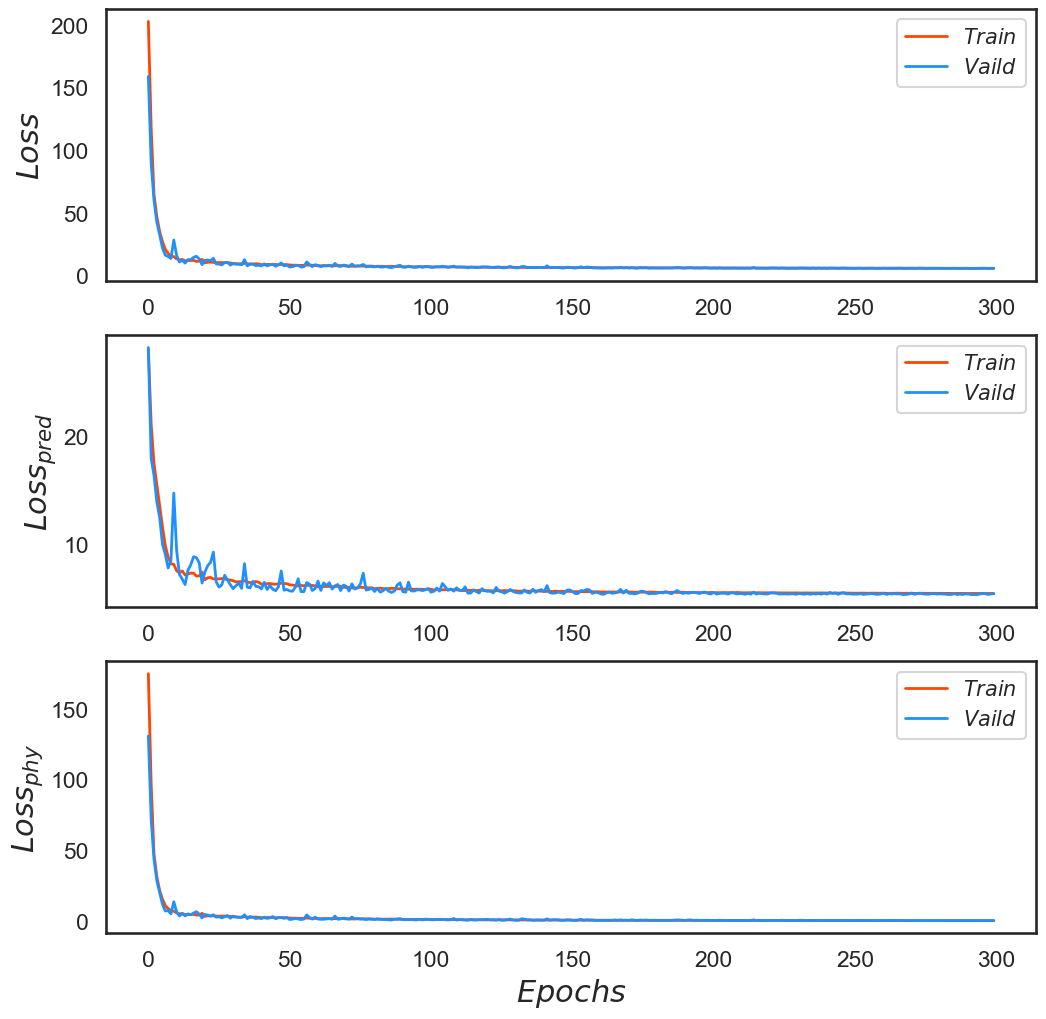

In [17]:
plot_loss_fig(train_epochs_loss,val_epochs_loss)

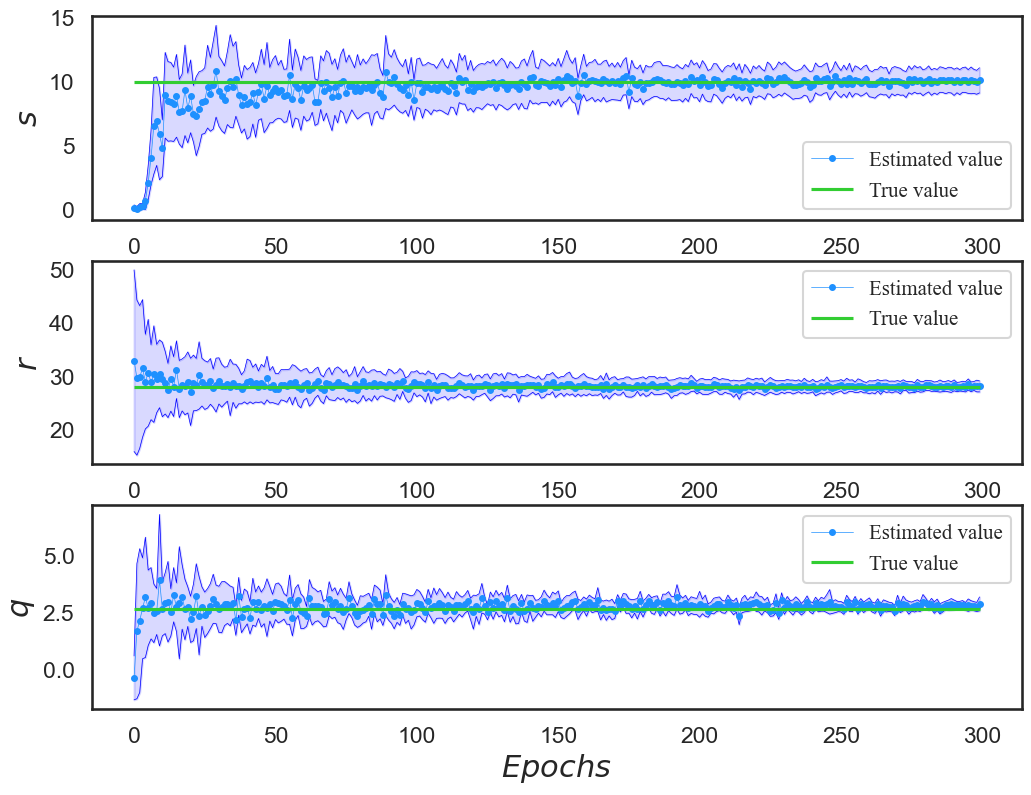

In [18]:
plot_inf_track(val_epochs_inf,val_epochs_loss)

In [19]:
train_end = time.time()
print('train time cost : ',(train_end - train_start)/60,'min')

train time cost :  528.388703262806 min
